# Using `gwent` to Calculate Signal-to-Noise Ratios

Here we present a tutorial on how to use `gwent` to calculate SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an array of coalescing Binary Black Holes.

First, we import important modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as const
import time
import astropy.units as u

import os,sys
gwent_path = '/Users/andrewkaiser/Documents/GradSchool/Research/gwent'
load_directory = gwent_path + '/LoadFiles/'

sys.path.insert(0,gwent_path)
import gwent
from gwent import binary
from gwent import detector
from gwent import snr
from gwent import snrplot

Setting matplotlib preferences

In [3]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'
save_directory = '/Users/andrewkaiser/Documents/GradSchool/Research/LisaParameterization/DetectorDesignSensitivities/Figures/'

## Declaring x and y variables and Sample Rates

The variables for either axis in the SNR calculation can be:

* GLOBAL:

    * 'T_obs' - Detector Observation Time
    
* SOURCE:

    * 'M' - Mass (Solar Units)
    * 'q' - Mass Ratio
    * 'chi1' - Dimensionless Spin of Black Hole 1
    * 'chi2' - Dimensionless Spin of Black Hole 2
    * 'z' - Redshift
    
* LISA ONLY:

    * 'L' - Detector Armlength
    * 'A_acc' - Detector Acceleration Noise
    * 'A_IFO' - Detector Optical Metrology Noise
    * 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
    * 'f_acc_break_high' - The High Acceleration Noise Break Frequency
    * 'f_IFO_break' - The Optical Metrology Noise Break Frequency
    
* PTAs ONLY:

    * 'N_p' - Number of Pulsars
    * 'sigma' - Root-Mean-Squared Timing Error
    * 'cadence' - Observation Cadence

In [5]:
#Number of SNRMatrix rows
sampleRate_y = 10
#Number of SNRMatrix columns
sampleRate_x = 10

## Source Selection Function

Takes in a an instrument model that dictates reasonable mass ranges for the particular detector mass regime and instantiates a source with the variable ranges limited by the waveform calibration region.

The source parameters must be set (ie. M,q,z,chi1,chi2), but one only needs to set the minima and maxima of the selected SNR axes variables.

In [31]:
def Get_Source(model):
    if model in [0,1]:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model in [2,3,4,5,6,7]:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 9e8
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

## Instrument Selection Function

Takes in an instrument model then assigns the fiducial noise and detector values. The model only assigns ranges of calculation for quick variable calculations, but one only needs to set the minima and maxima if they wish to use other selected SNR axes variables.

If loading a detector, the file should be frequency in the first column and either strain, effective strain noise spectral density, or amplitude spectral density in the second column.

For generating a detector, one must assign a value to each of the different instrument parameters (see the section on Declaring x and y variables and Sample Rates).

In [27]:
def Get_Instrument(model):
    if model in [0,1]:
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        if model == 0: #Einstein Telescope
            #Loaded from http://www.et-gw.eu/index.php/etsensitivities
            load_name = 'ET_D_data.txt'
            load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
            instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        elif model == 1: #aLIGO
            #Loaded from https://dcc.ligo.org/T1800044/public
            load_name = 'aLIGODesign.txt'
            load_location = load_directory + 'aLIGO/StrainFiles/' + load_name
            instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        
    elif model in [2,3,4,5]:
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 5*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        sigma_min = 100*u.ns.to('s')*u.s
        sigma_max = 500*u.ns.to('s')*u.s
        
        N_p = 18 #Number of pulsars
        N_p_min = 18
        N_p_max = 40
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        
        if model == 2: #NANOGrav 15 yr WN only
            instrument = detector.PTA('NANOGrav_WN',T_obs,N_p,sigma,cadence)
        elif model == 3: #NANOGrav 15 yr WN + RN
            instrument = detector.PTA('NANOGrav_WN_RN',T_obs,N_p,sigma,cadence,
                                      A_rn=[1e-16,1e-12],alpha_rn=[-1/2,1.25])
        elif model == 4: #NANOGrav 11 yr real data
            #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
            load_name = 'NANOGrav_11yr_S_eff.txt'
            load_location = load_directory + 'NANOGrav/StrainFiles/' + load_name
            T_obs = 11.42*u.yr #Observing time in years
            instrument = detector.PTA('NANOGrav_11yr',load_location=load_location,I_type='E')
        elif model == 5: #NANOGrav realistic noise
            instrument = detector.PTA('NANOGrav_realistic_noise',T_obs,N_p,cadence,use_11yr=True)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.N_p = [N_p,N_p_min,N_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model in [6,7]: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        sigma_min = 10*u.ns.to('s')*u.s
        sigma_max = 100*u.ns.to('s')*u.s
        
        N_p = 20 #Number of pulsars
        N_p_min = 18
        N_p_max = 200
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        if model == 6:
            instrument = detector.PTA('SKA',T_obs,N_p,sigma,cadence)
        elif model == 7:
            instrument = detector.PTA('SKA_realistic_noise',T_obs,N_p,cadence,use_11yr=True)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.N_p = [N_p,N_p_min,N_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model >= 8:
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        A_acc = 3e-15*u.m/u.s/u.s
        A_acc_min = 1e-16*u.m/u.s/u.s
        A_acc_max = 1e-14*u.m/u.s/u.s
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_min = .1*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_max = 1.0*u.mHz.to('Hz')*u.Hz
        
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_min = 1.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_max = 10.*u.mHz.to('Hz')*u.Hz
        
        f_IFO_break = 2.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_min = 1.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_max = 5.*u.mHz.to('Hz')*u.Hz
        
        A_IFO_min = 1.0e-12*u.m
        A_IFO_max = 2.0e-11*u.m
        
        if model == 8: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
            A_IFO = 1.5e-11*u.m
            Background = False
            T_type = 'A'

            instrument = detector.SpaceBased('Alt_LISA',\
                                           T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                           Background=Background,T_type=T_type)

        else: #L3 proposal
            #Default Params from https://arxiv.org/abs/1702.00786
            A_IFO = 10e-12*u.m
            Background = False
            T_type = 'N'
        
            instrument = detector.SpaceBased('LISA_ESA',\
                                           T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                           Background=Background,T_type=T_type)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        instrument.A_acc = [A_acc,A_acc_min,A_acc_max]
        instrument.f_acc_break_low = [f_acc_break_low,f_acc_break_low_min,f_acc_break_low_max]
        instrument.f_acc_break_high = [f_acc_break_high,f_acc_break_high_min,f_acc_break_high_max]
        instrument.A_IFO = [A_IFO,A_IFO_min,A_IFO_max]
        instrument.f_IFO_break = [f_IFO_break,f_IFO_break_min,f_IFO_break_max]
        
    return instrument

## SNR Calculation

Based on the selected model, we use `Get_Instrument` and `Get_Source` to instantiate both the instrument and the model for the SNR Calculation.

In [28]:
#Variable on y-axis
var_y = 'A_acc'
#Variable on x-axis
var_x = 'M'
model = 9
instrument = Get_Instrument(model)
source = Get_Source(model)

We now use `Get_SNR_Matrix` with the variables given and the data range to sample the space either logrithmically or linearly based on the selection of variables. 
It computes the SNR for each value, then returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the `sampleRate1`X`sampleRate2`

In [17]:
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

[ 18  36  54  72  90 108 126 144 162 180 198 200]
976.2837579250336


Plot the SNR using the initial variables and the returns from `Get_SNR_Matrix`

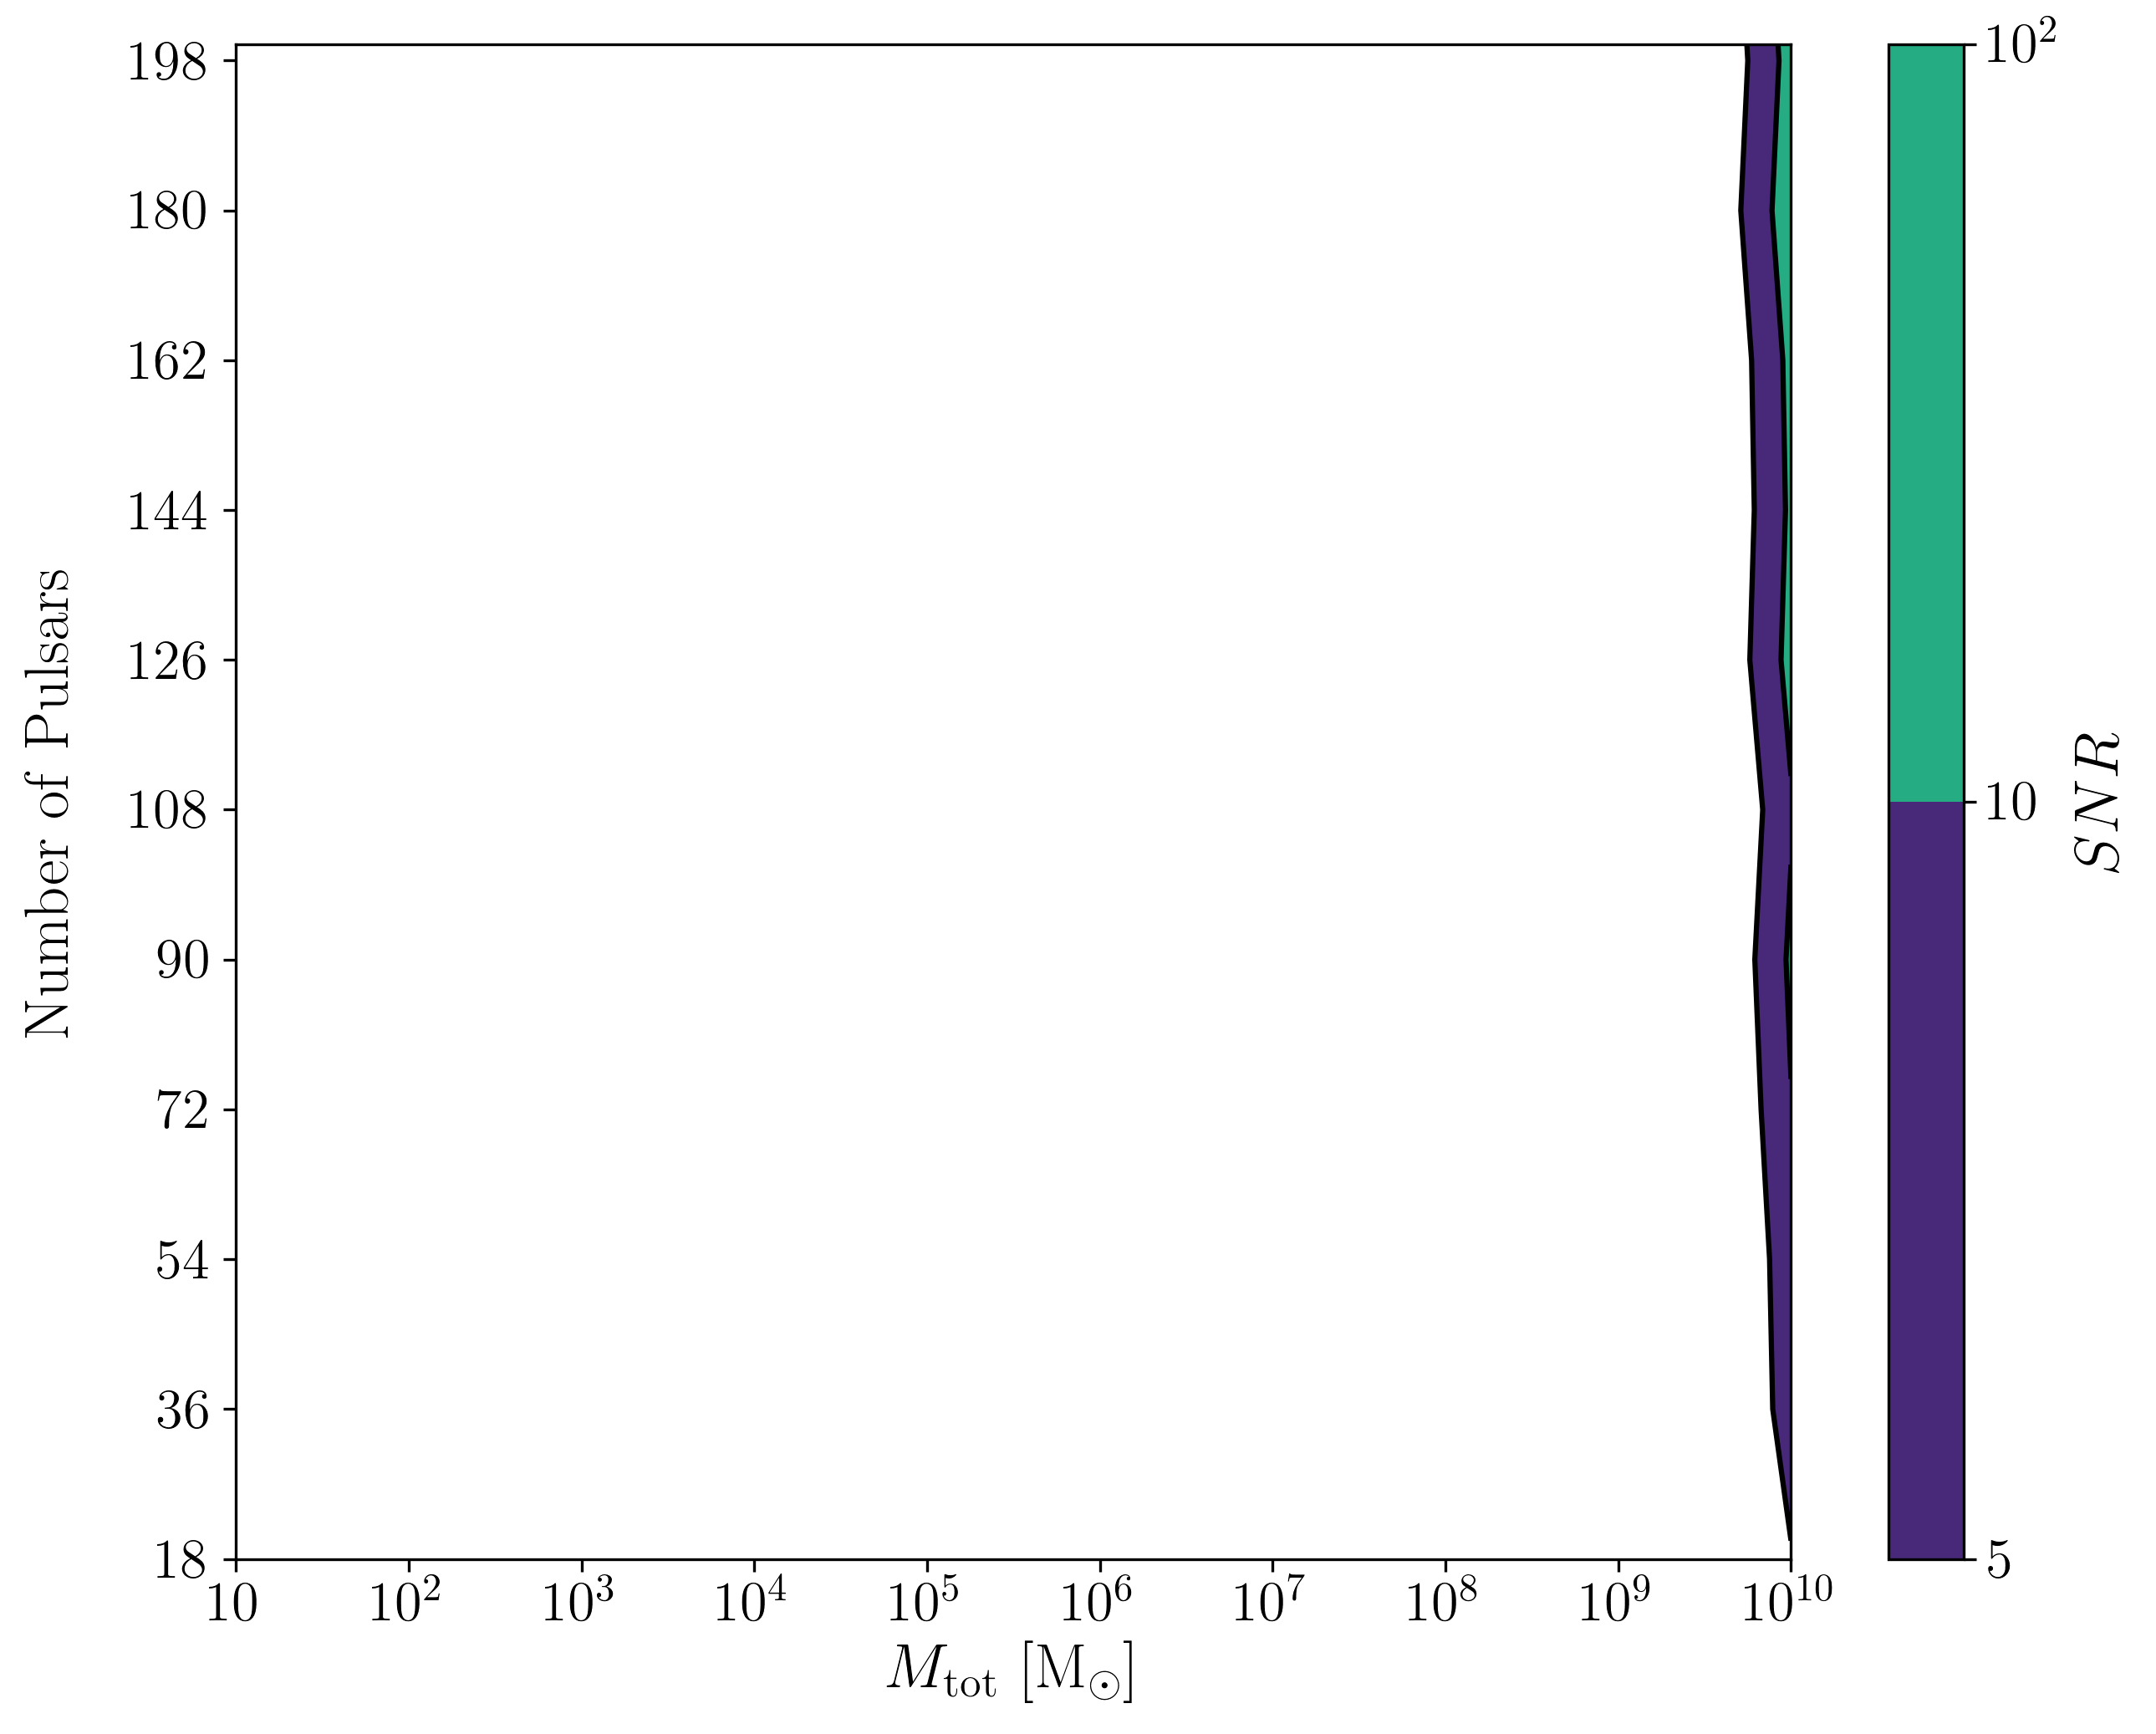

In [26]:
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,smooth_contours=False)

## Create of SNR Matrices and Samples for all models

### PTA Only Params

* 'N_p' - Number of Pulsars
* 'sigma' - Root-Mean-Squared Timing Error
* 'cadence' - Observation Cadence

In [11]:
#Variable on y-axis
var_ys = ['N_p','sigma','cadence','T_obs']
#Variable on x-axis
var_x = 'M'
models = [7]

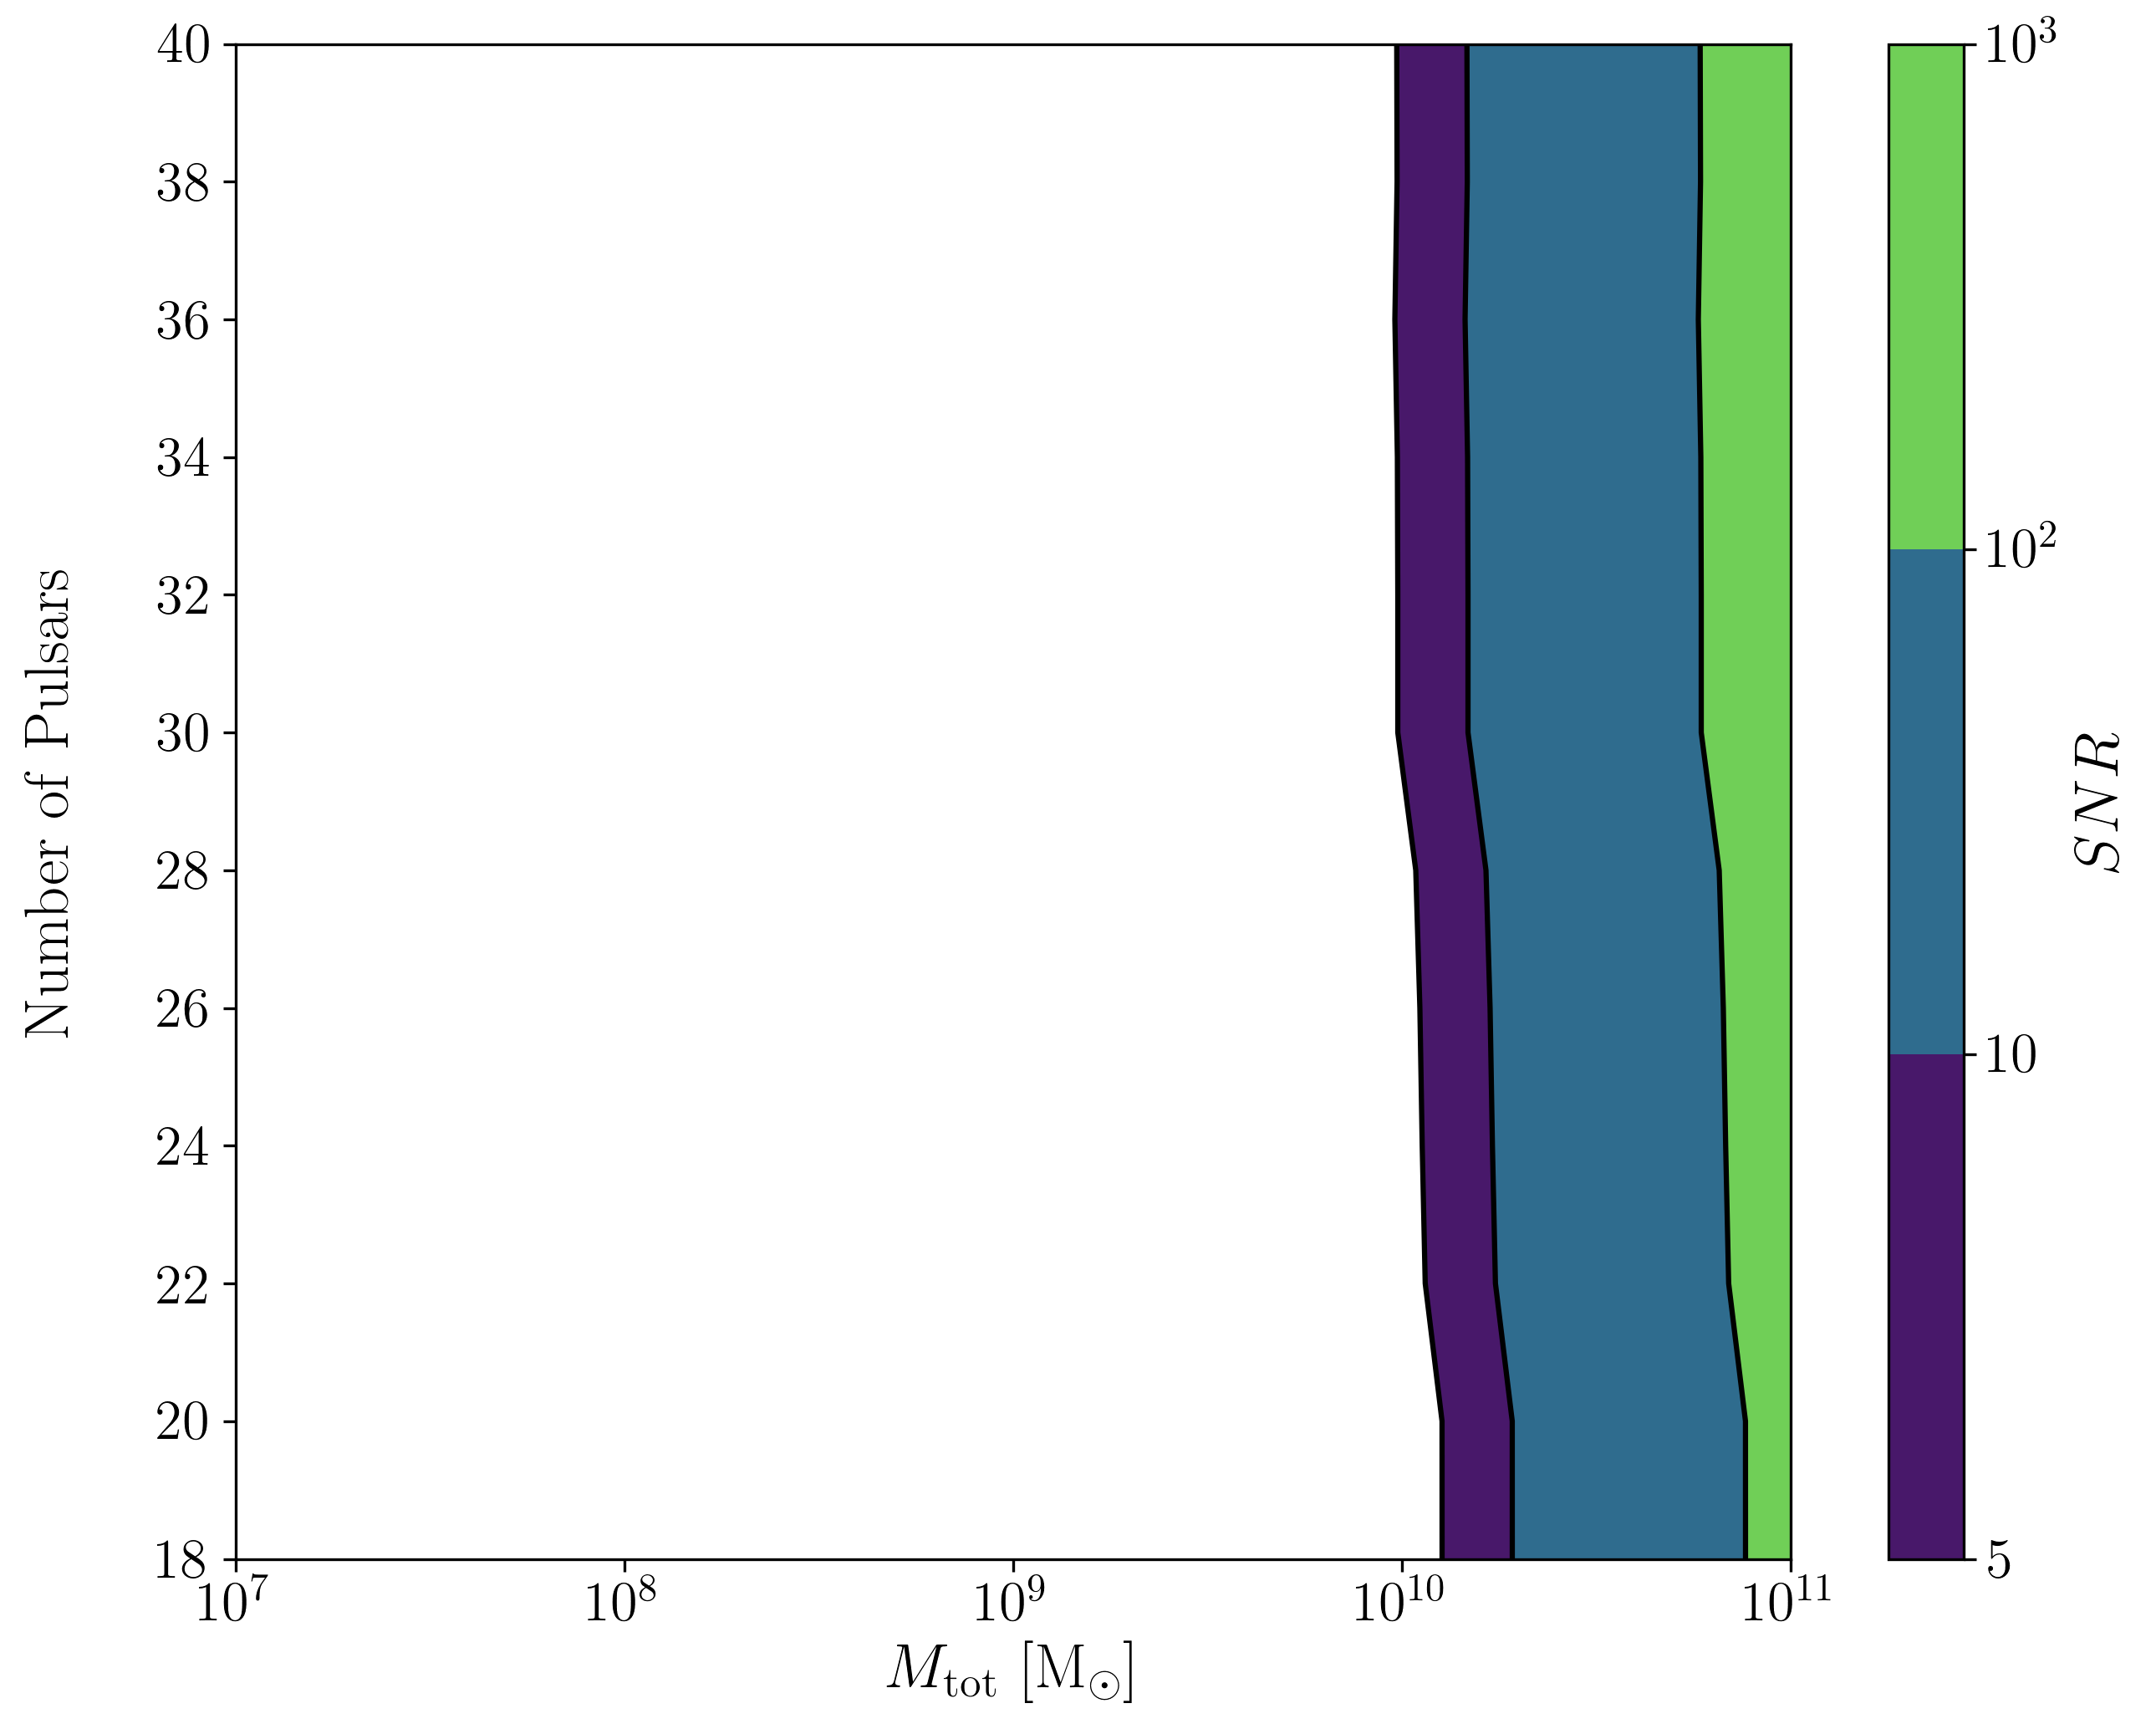

Model:  NANOGrav_realistic_noise ,  done. t = :  83.81164503097534


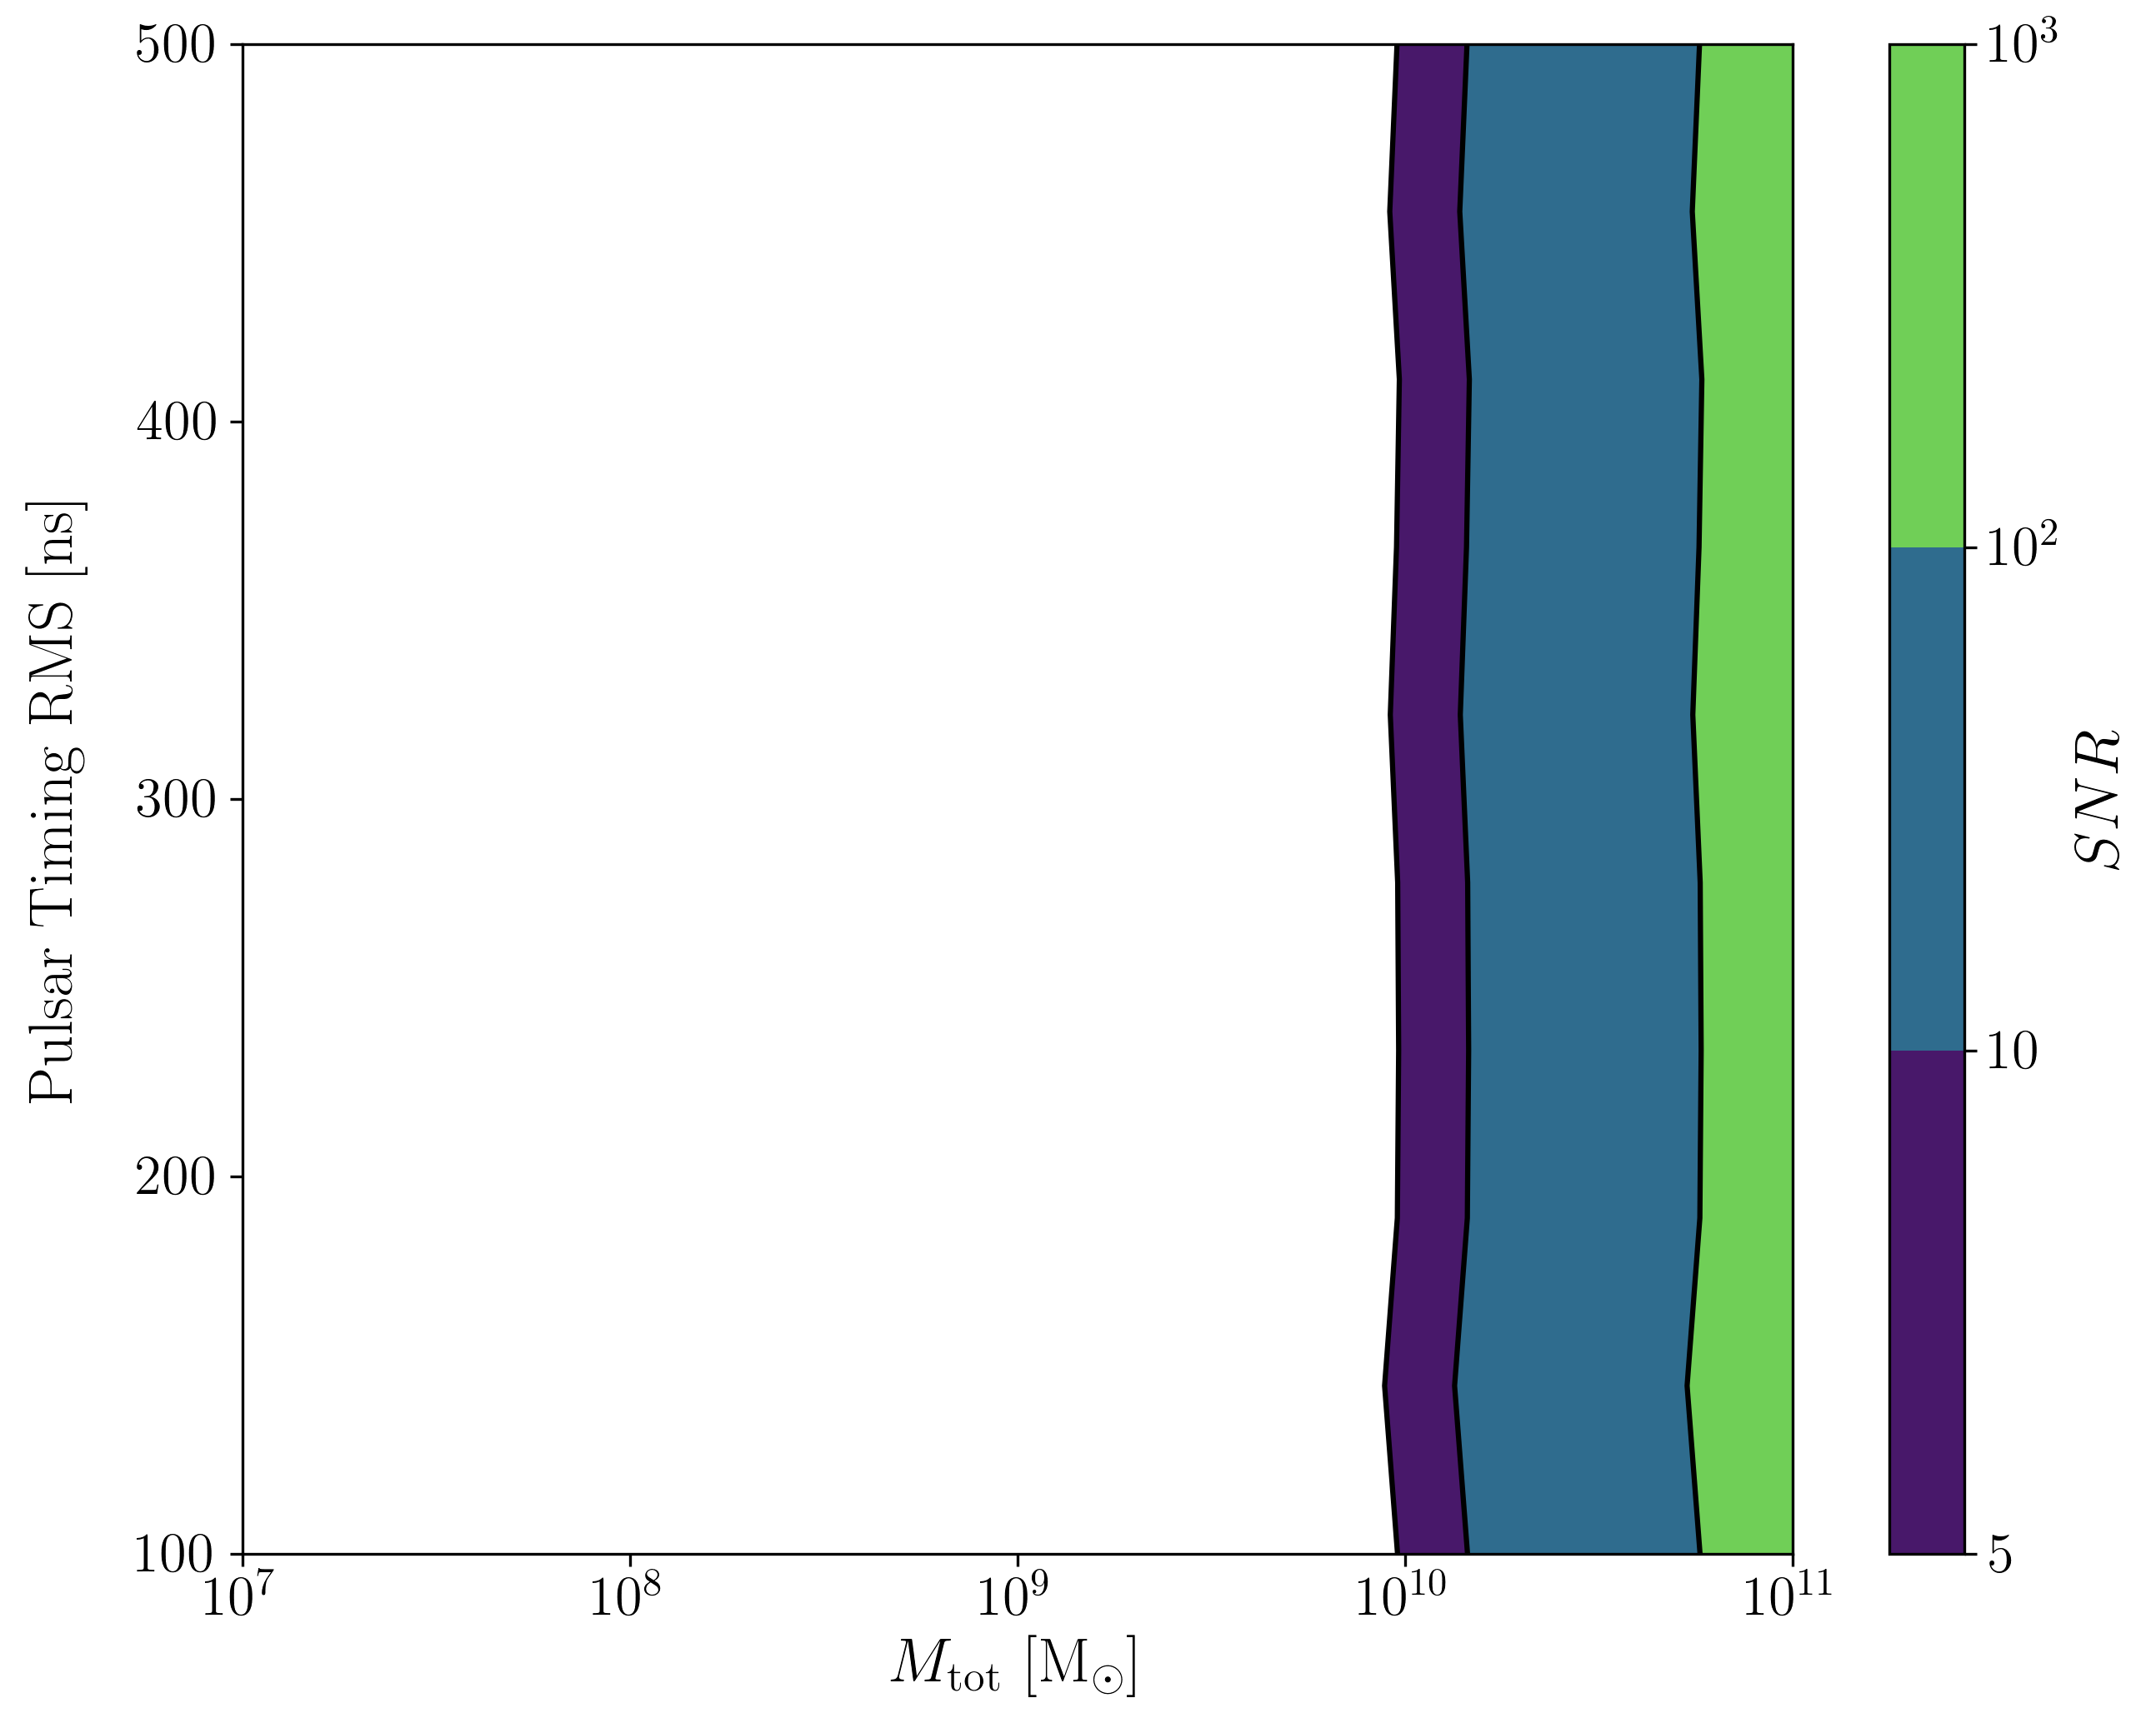

Model:  NANOGrav_realistic_noise ,  done. t = :  91.9506528377533


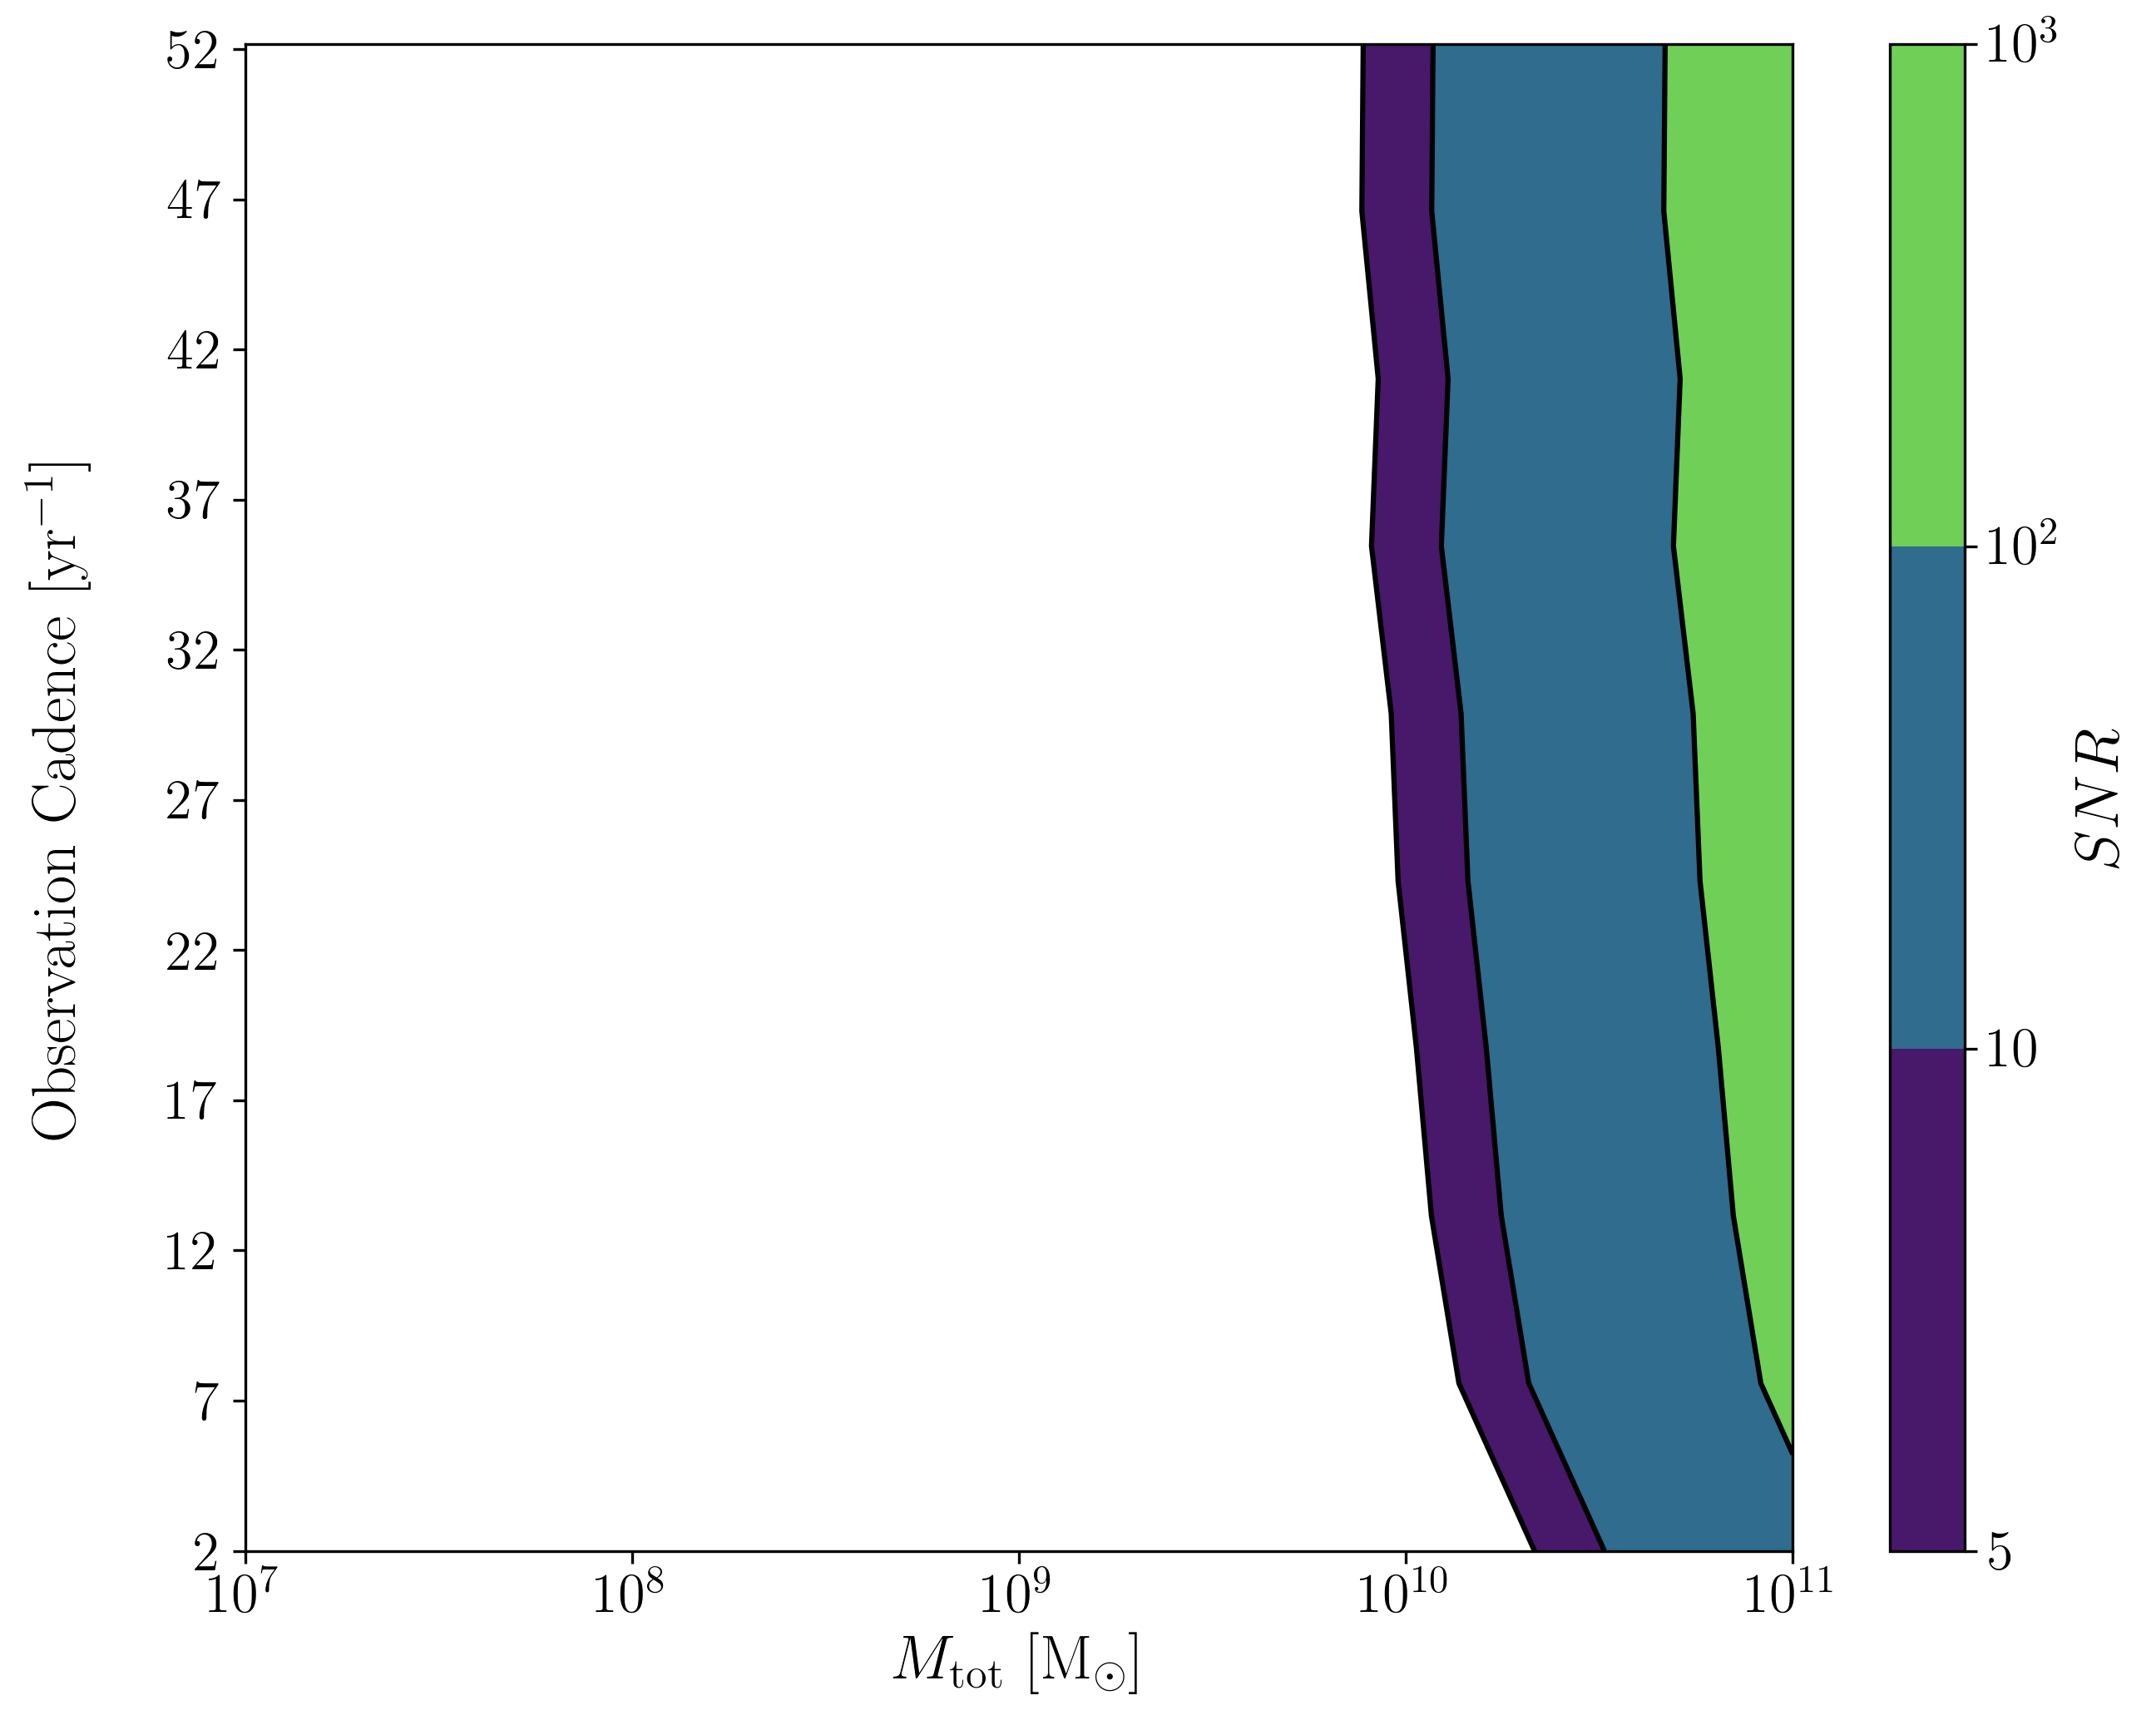

Model:  NANOGrav_realistic_noise ,  done. t = :  114.3228669166565


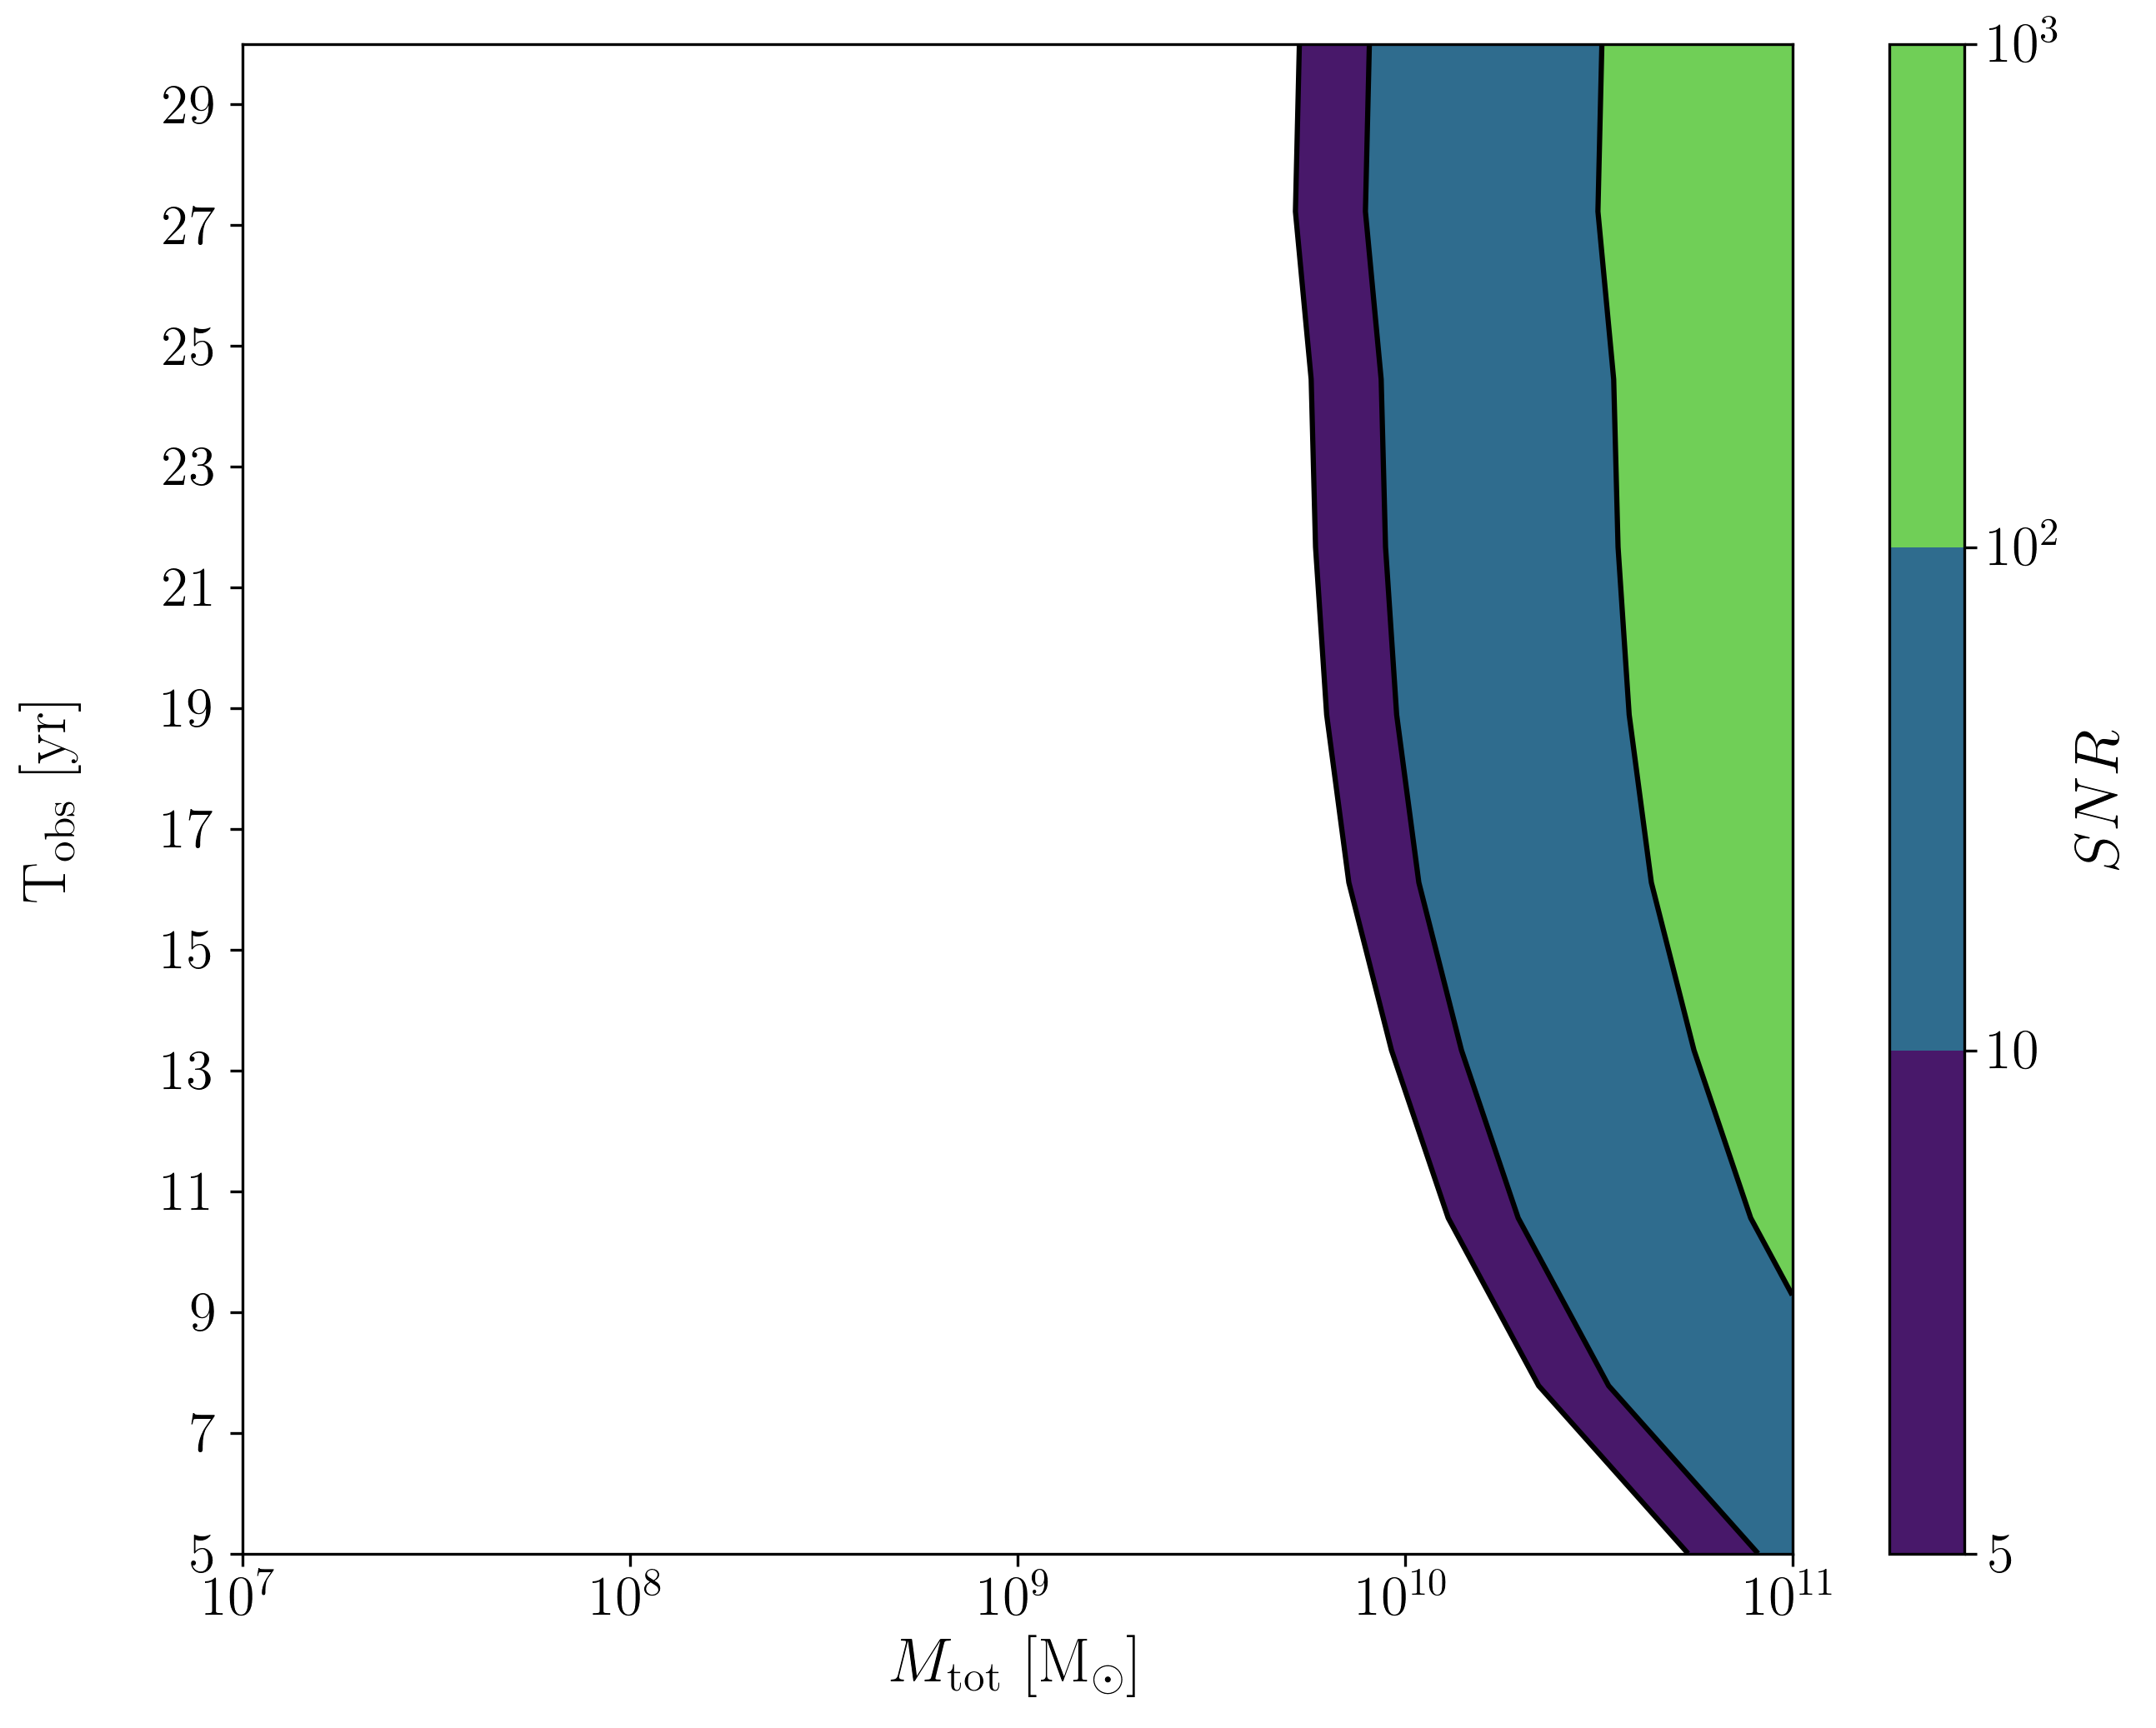

Model:  NANOGrav_realistic_noise ,  done. t = :  424.51572728157043


KeyboardInterrupt: 

In [15]:
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    for var_y in var_ys:
        figloc = save_directory + 'SNR_' + instrument.name + '_' + var_y + '_v3'+ '.png'
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False)
        print('Model: ',instrument.name,',',' done. t = : ',end-start)

### LISA Only Params

* 'L' - Detector Armlength
* 'A_acc' - Detector Acceleration Noise
* 'A_IFO' - Detector Optical Metrology Noise
* 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
* 'f_acc_break_high' - The High Acceleration Noise Break Frequency
* 'f_IFO_break' - The Optical Metrology Noise Break Frequency

In [28]:
#Variable on y-axis
var_ys = ['L','A_acc','A_IFO','f_acc_break_low','f_acc_break_high','f_IFO_break']
#Variable on x-axis
var_x = 'M'
model = 7

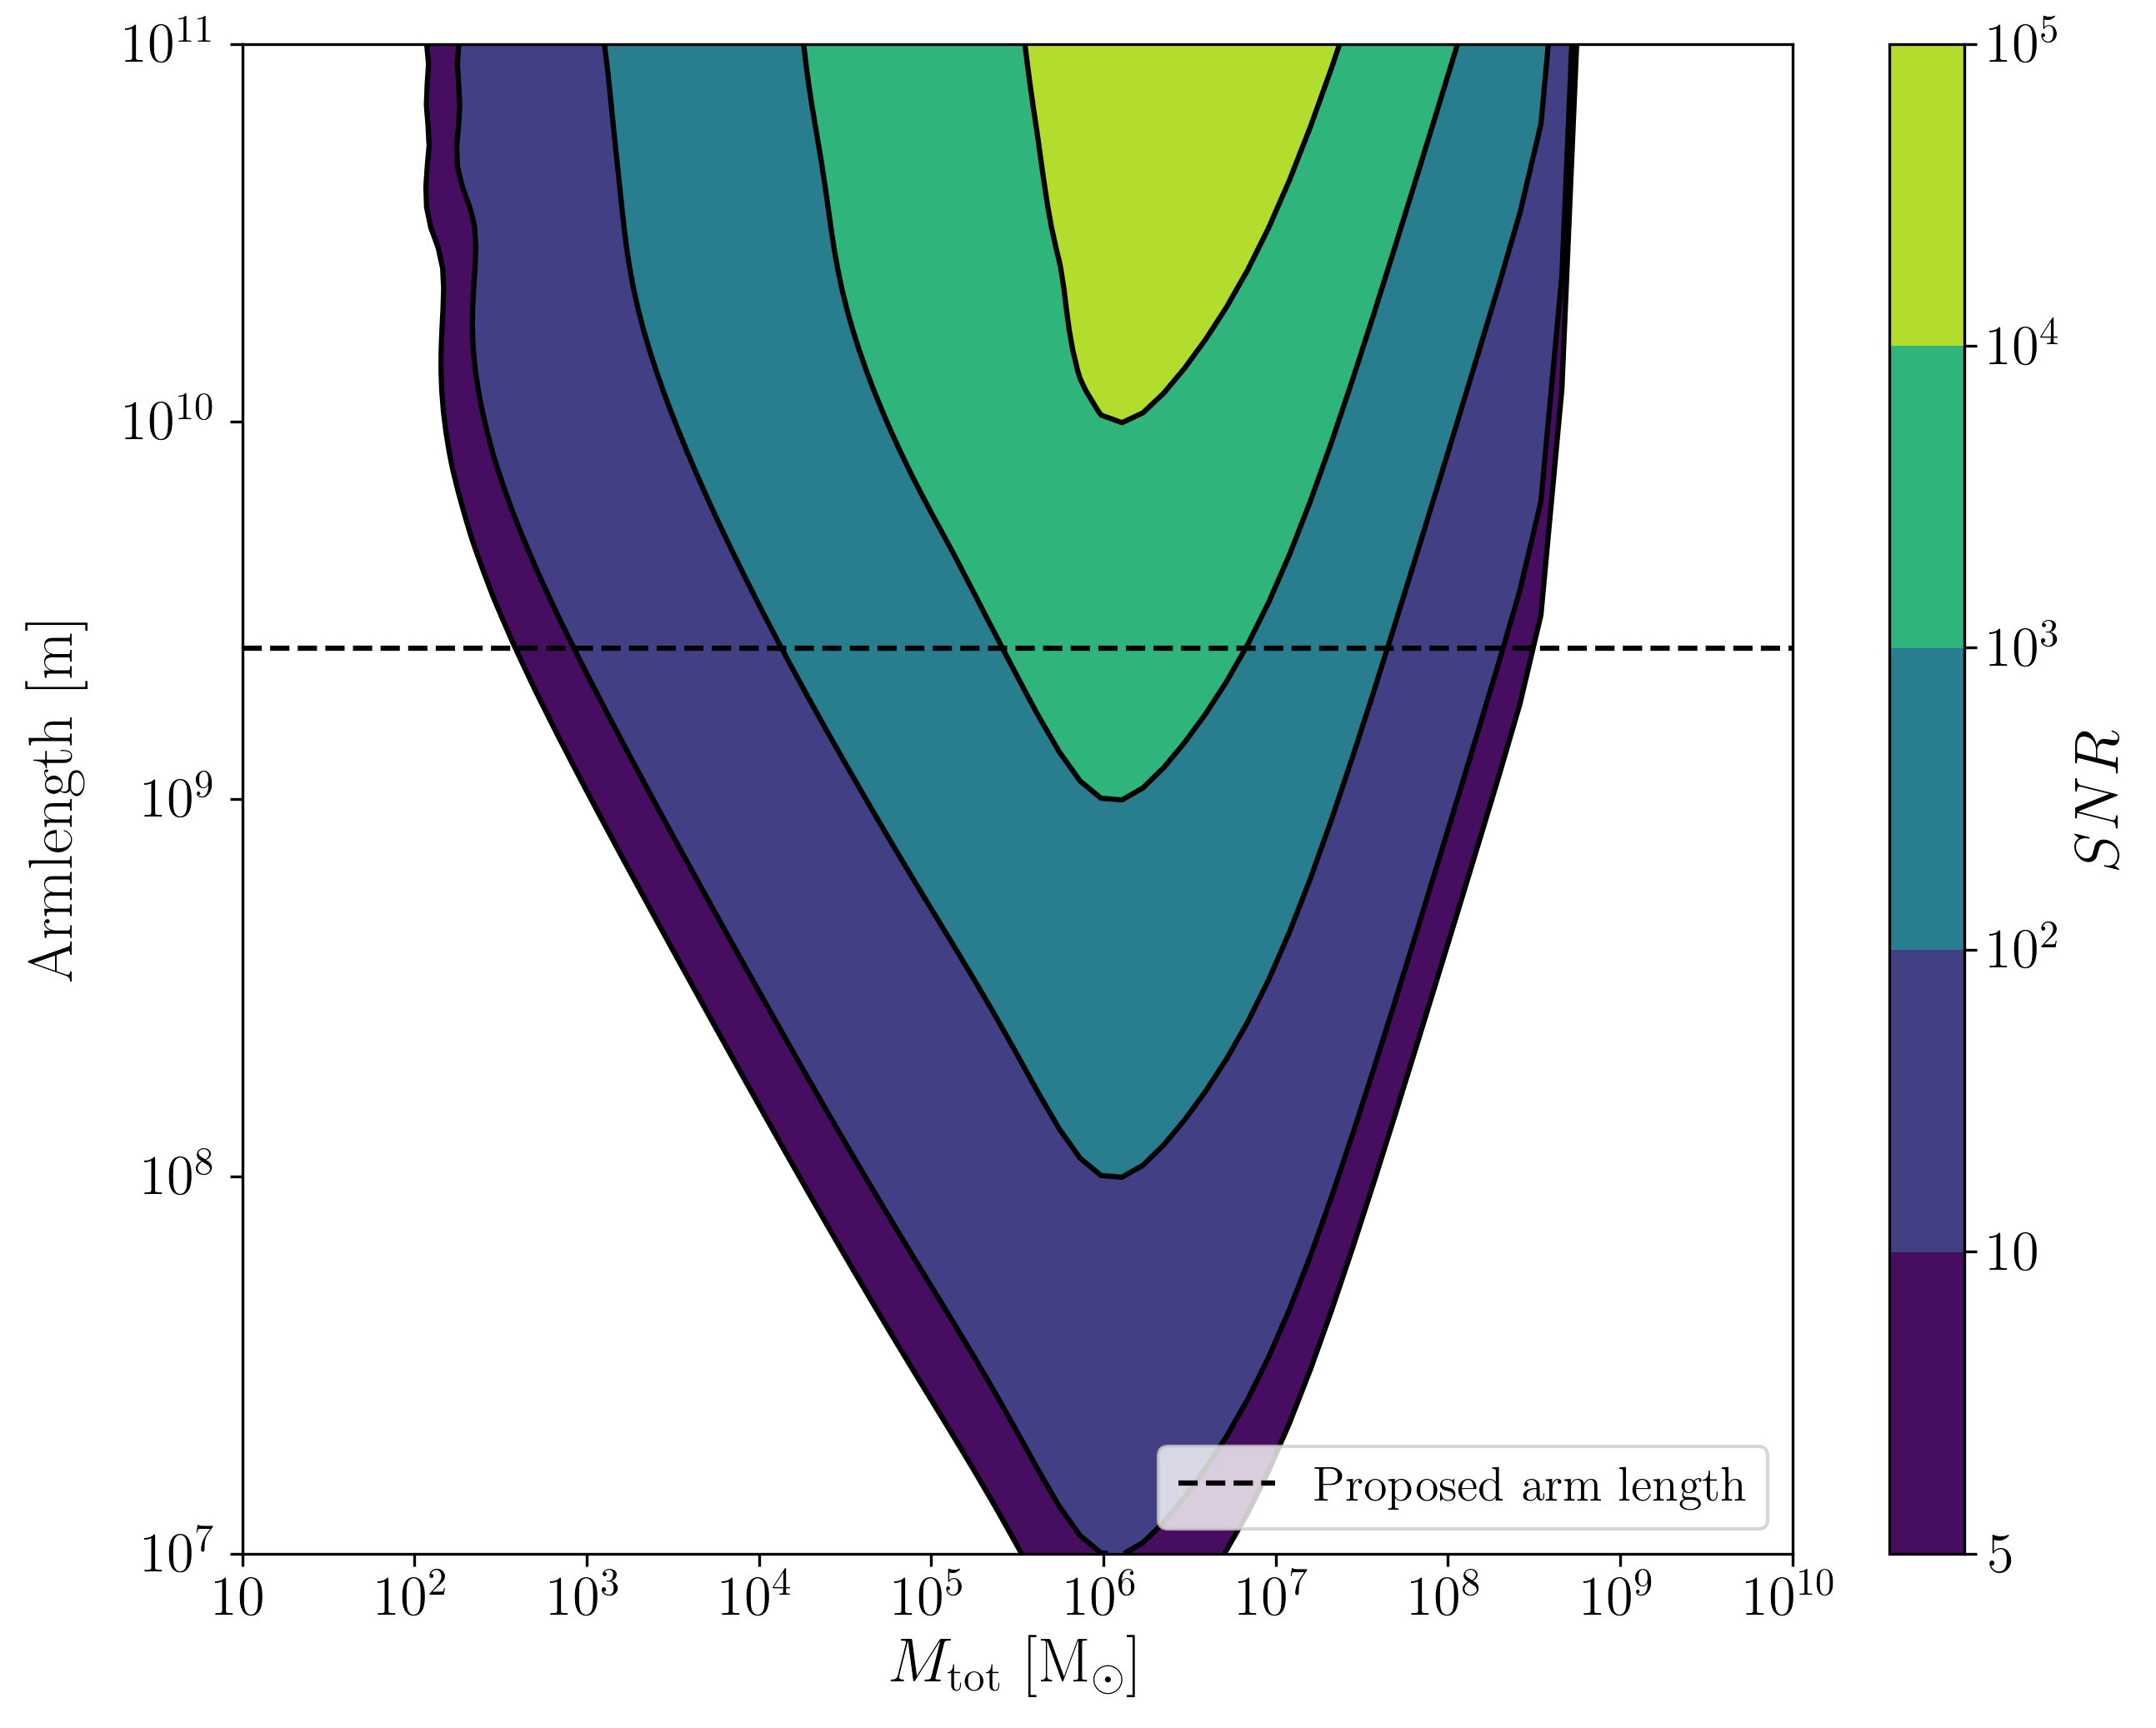

Model:  LISA_ESA ,  done. t = :  39.93300414085388


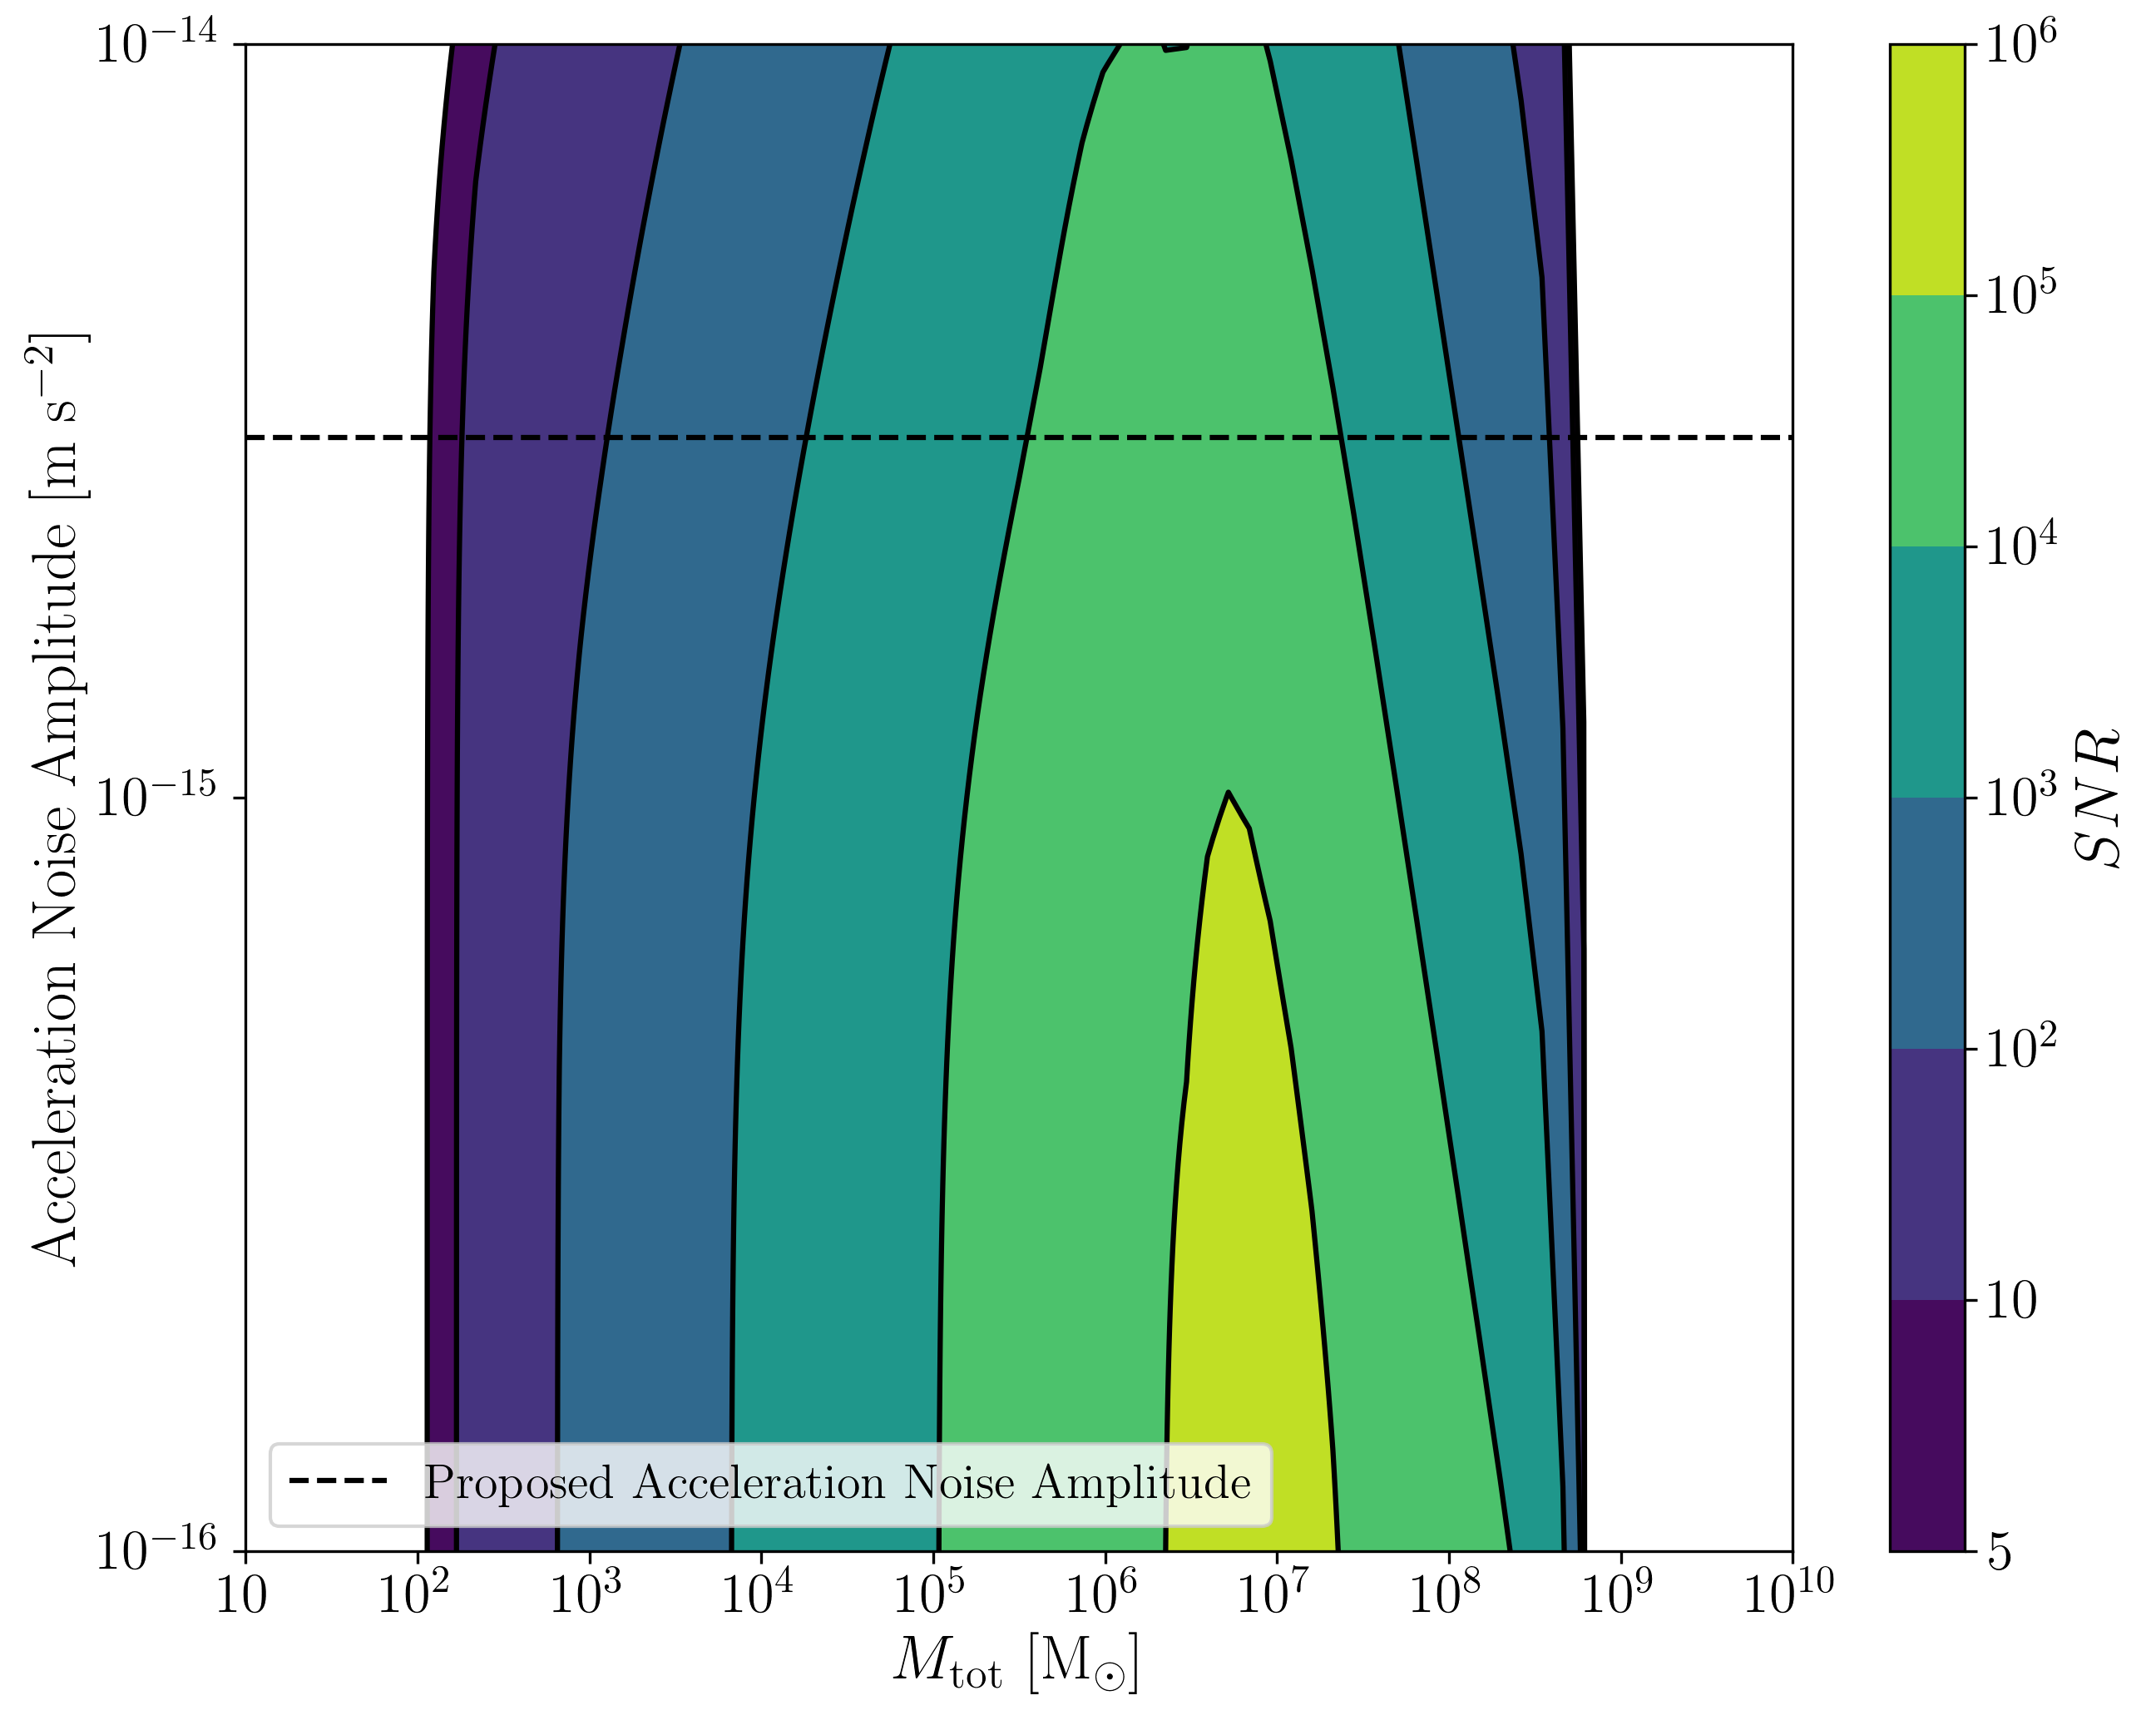

Model:  LISA_ESA ,  done. t = :  35.675442934036255


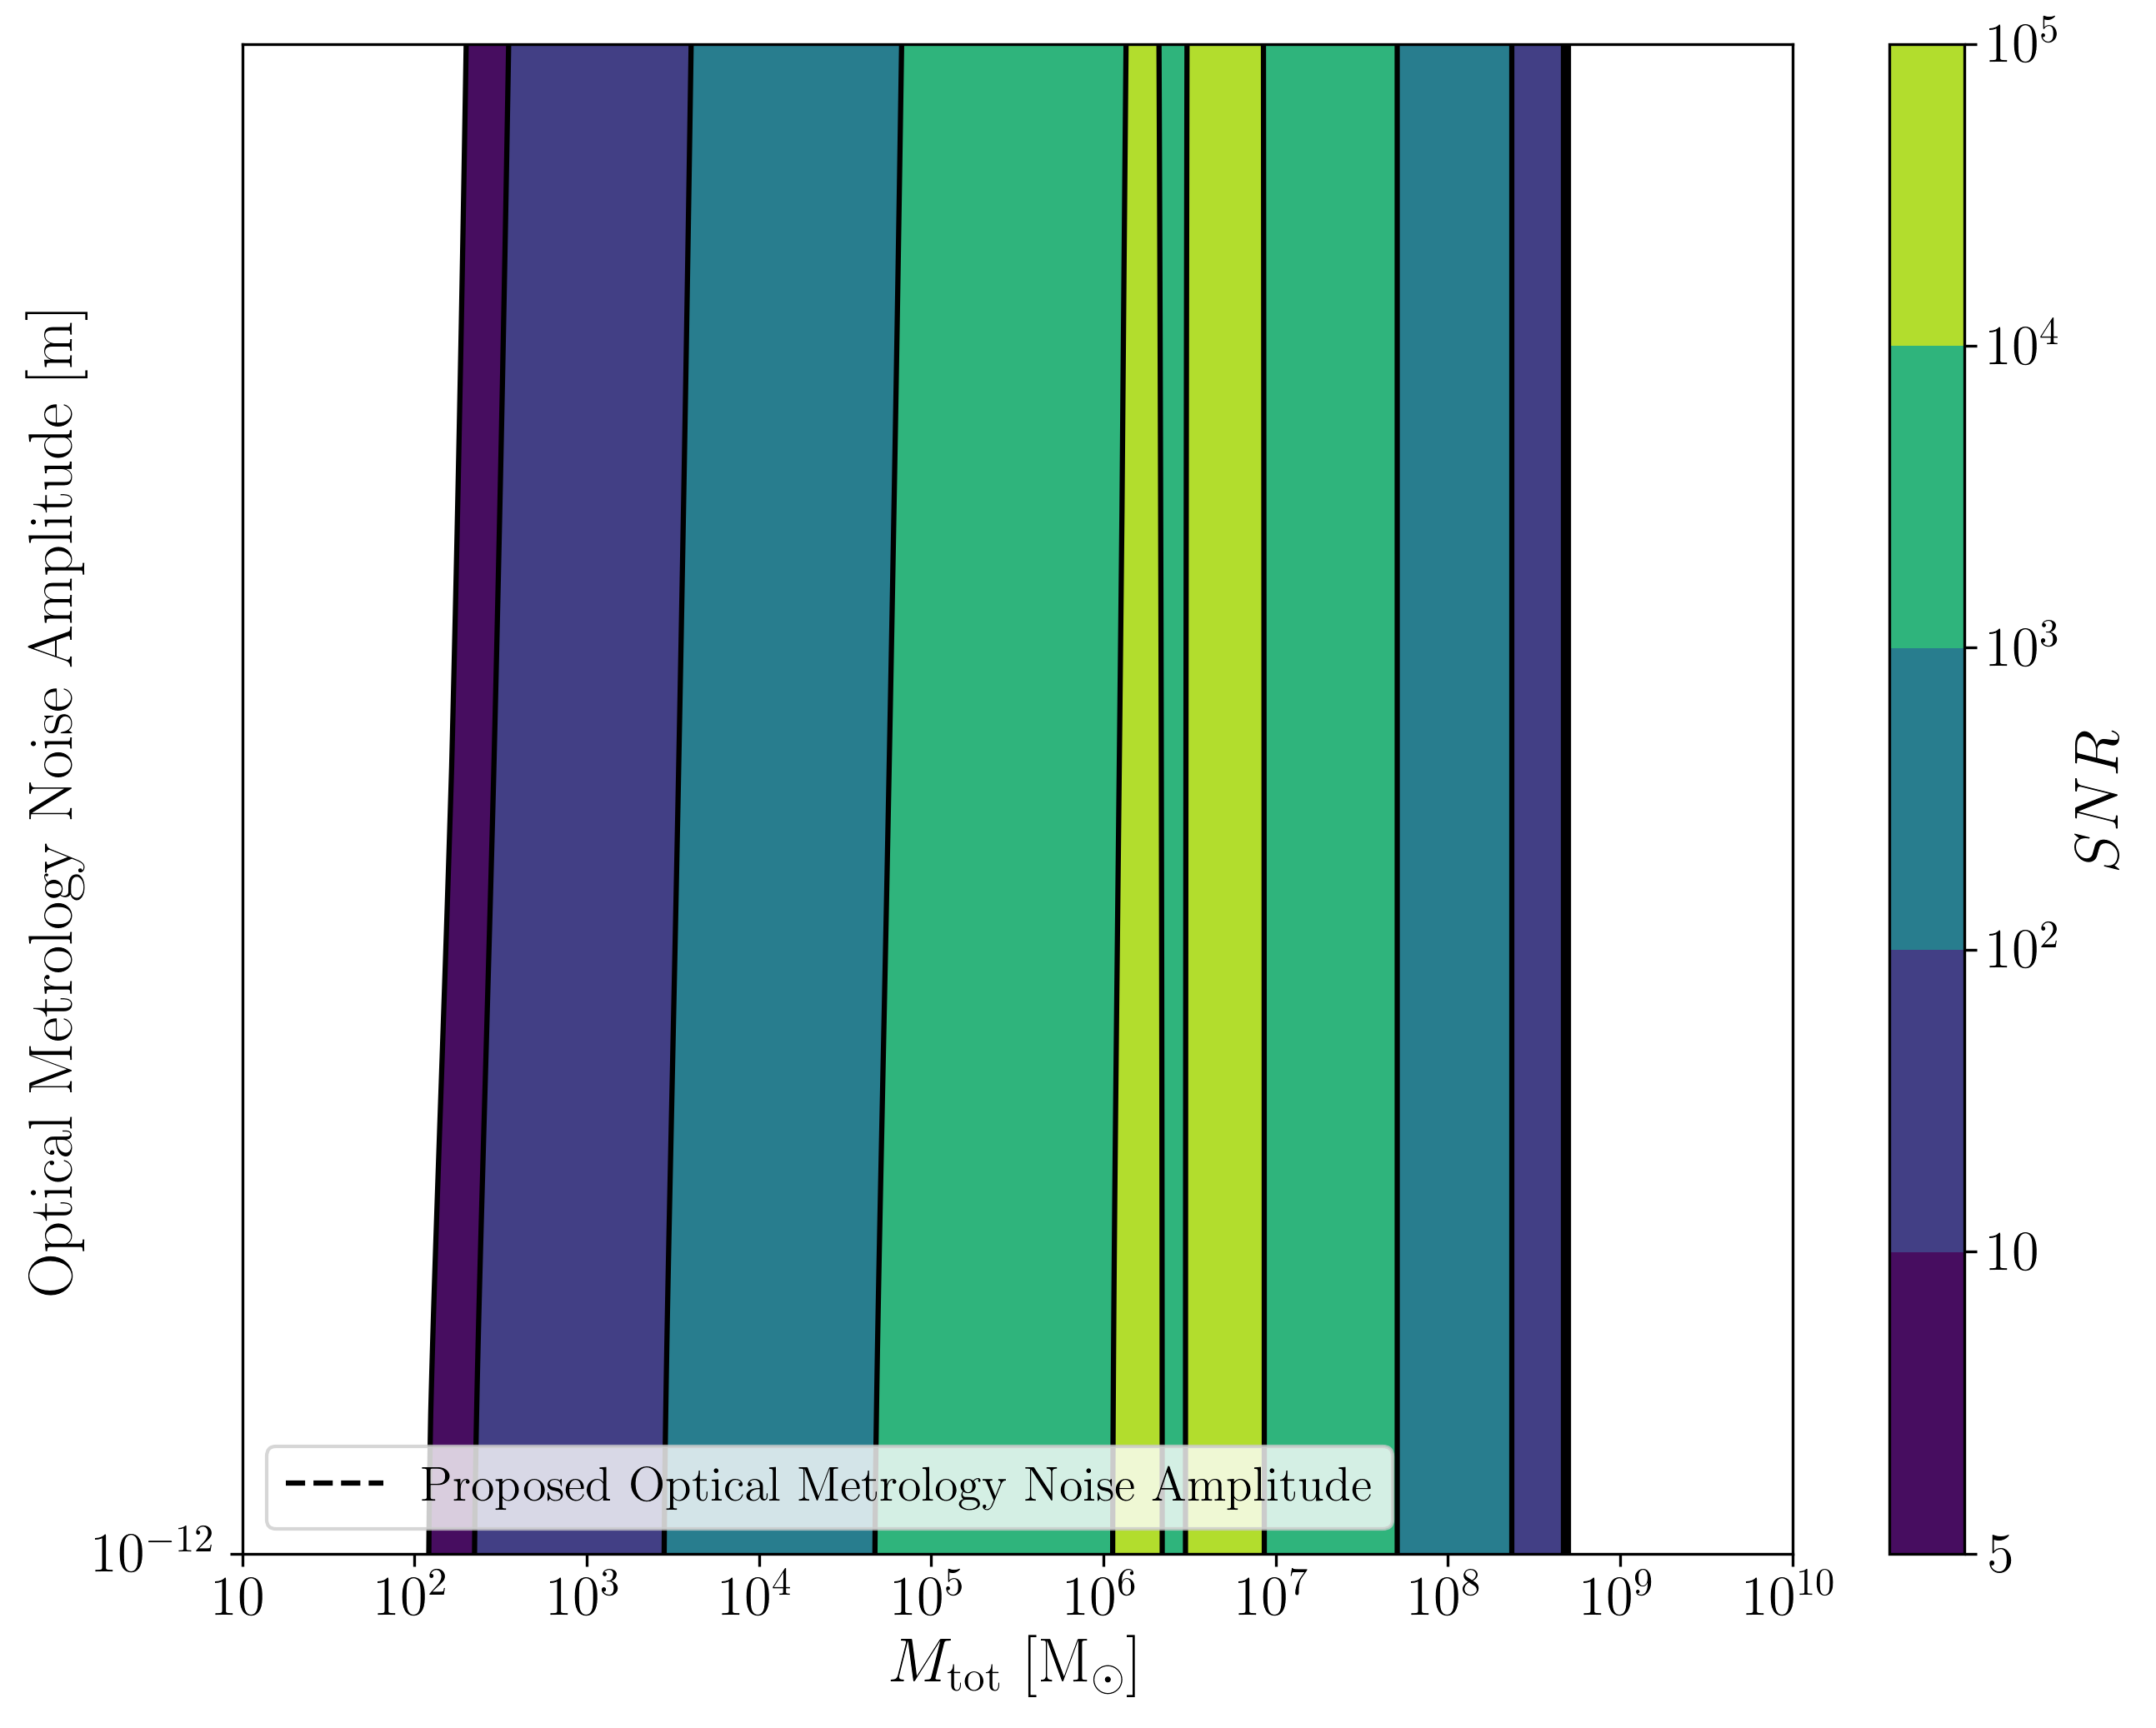

Model:  LISA_ESA ,  done. t = :  36.86849904060364


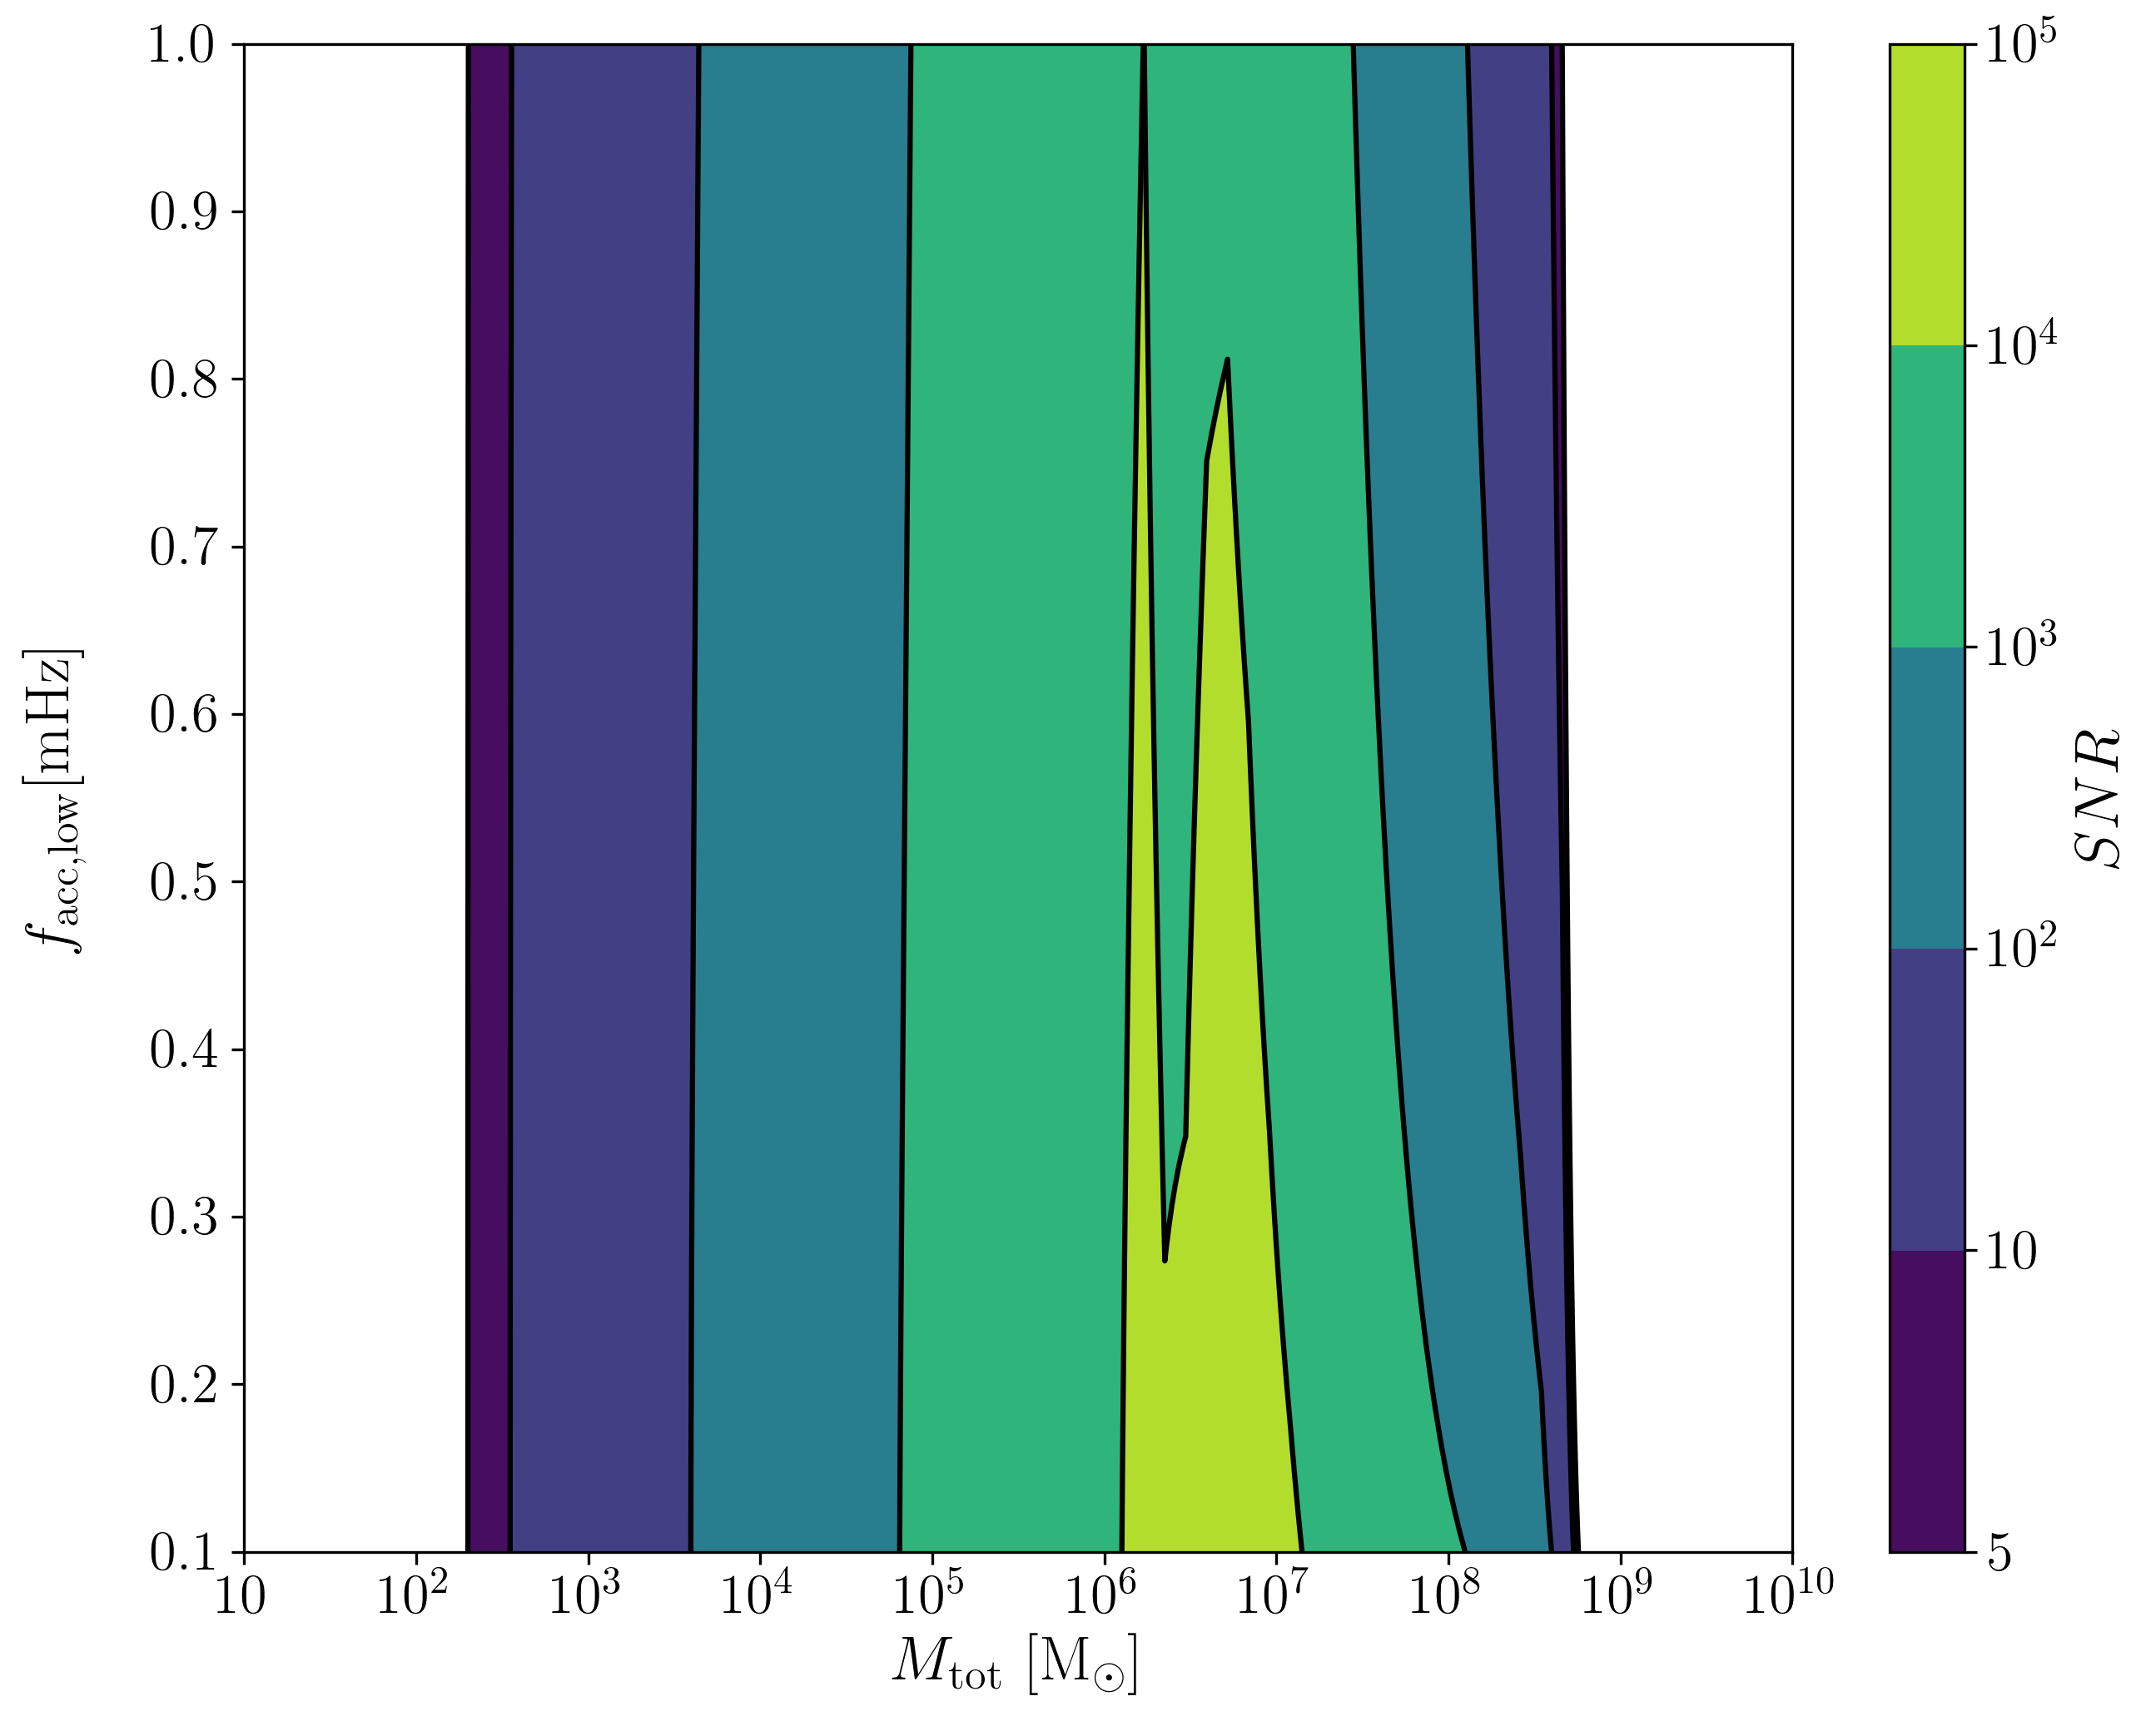

Model:  LISA_ESA ,  done. t = :  36.481127977371216


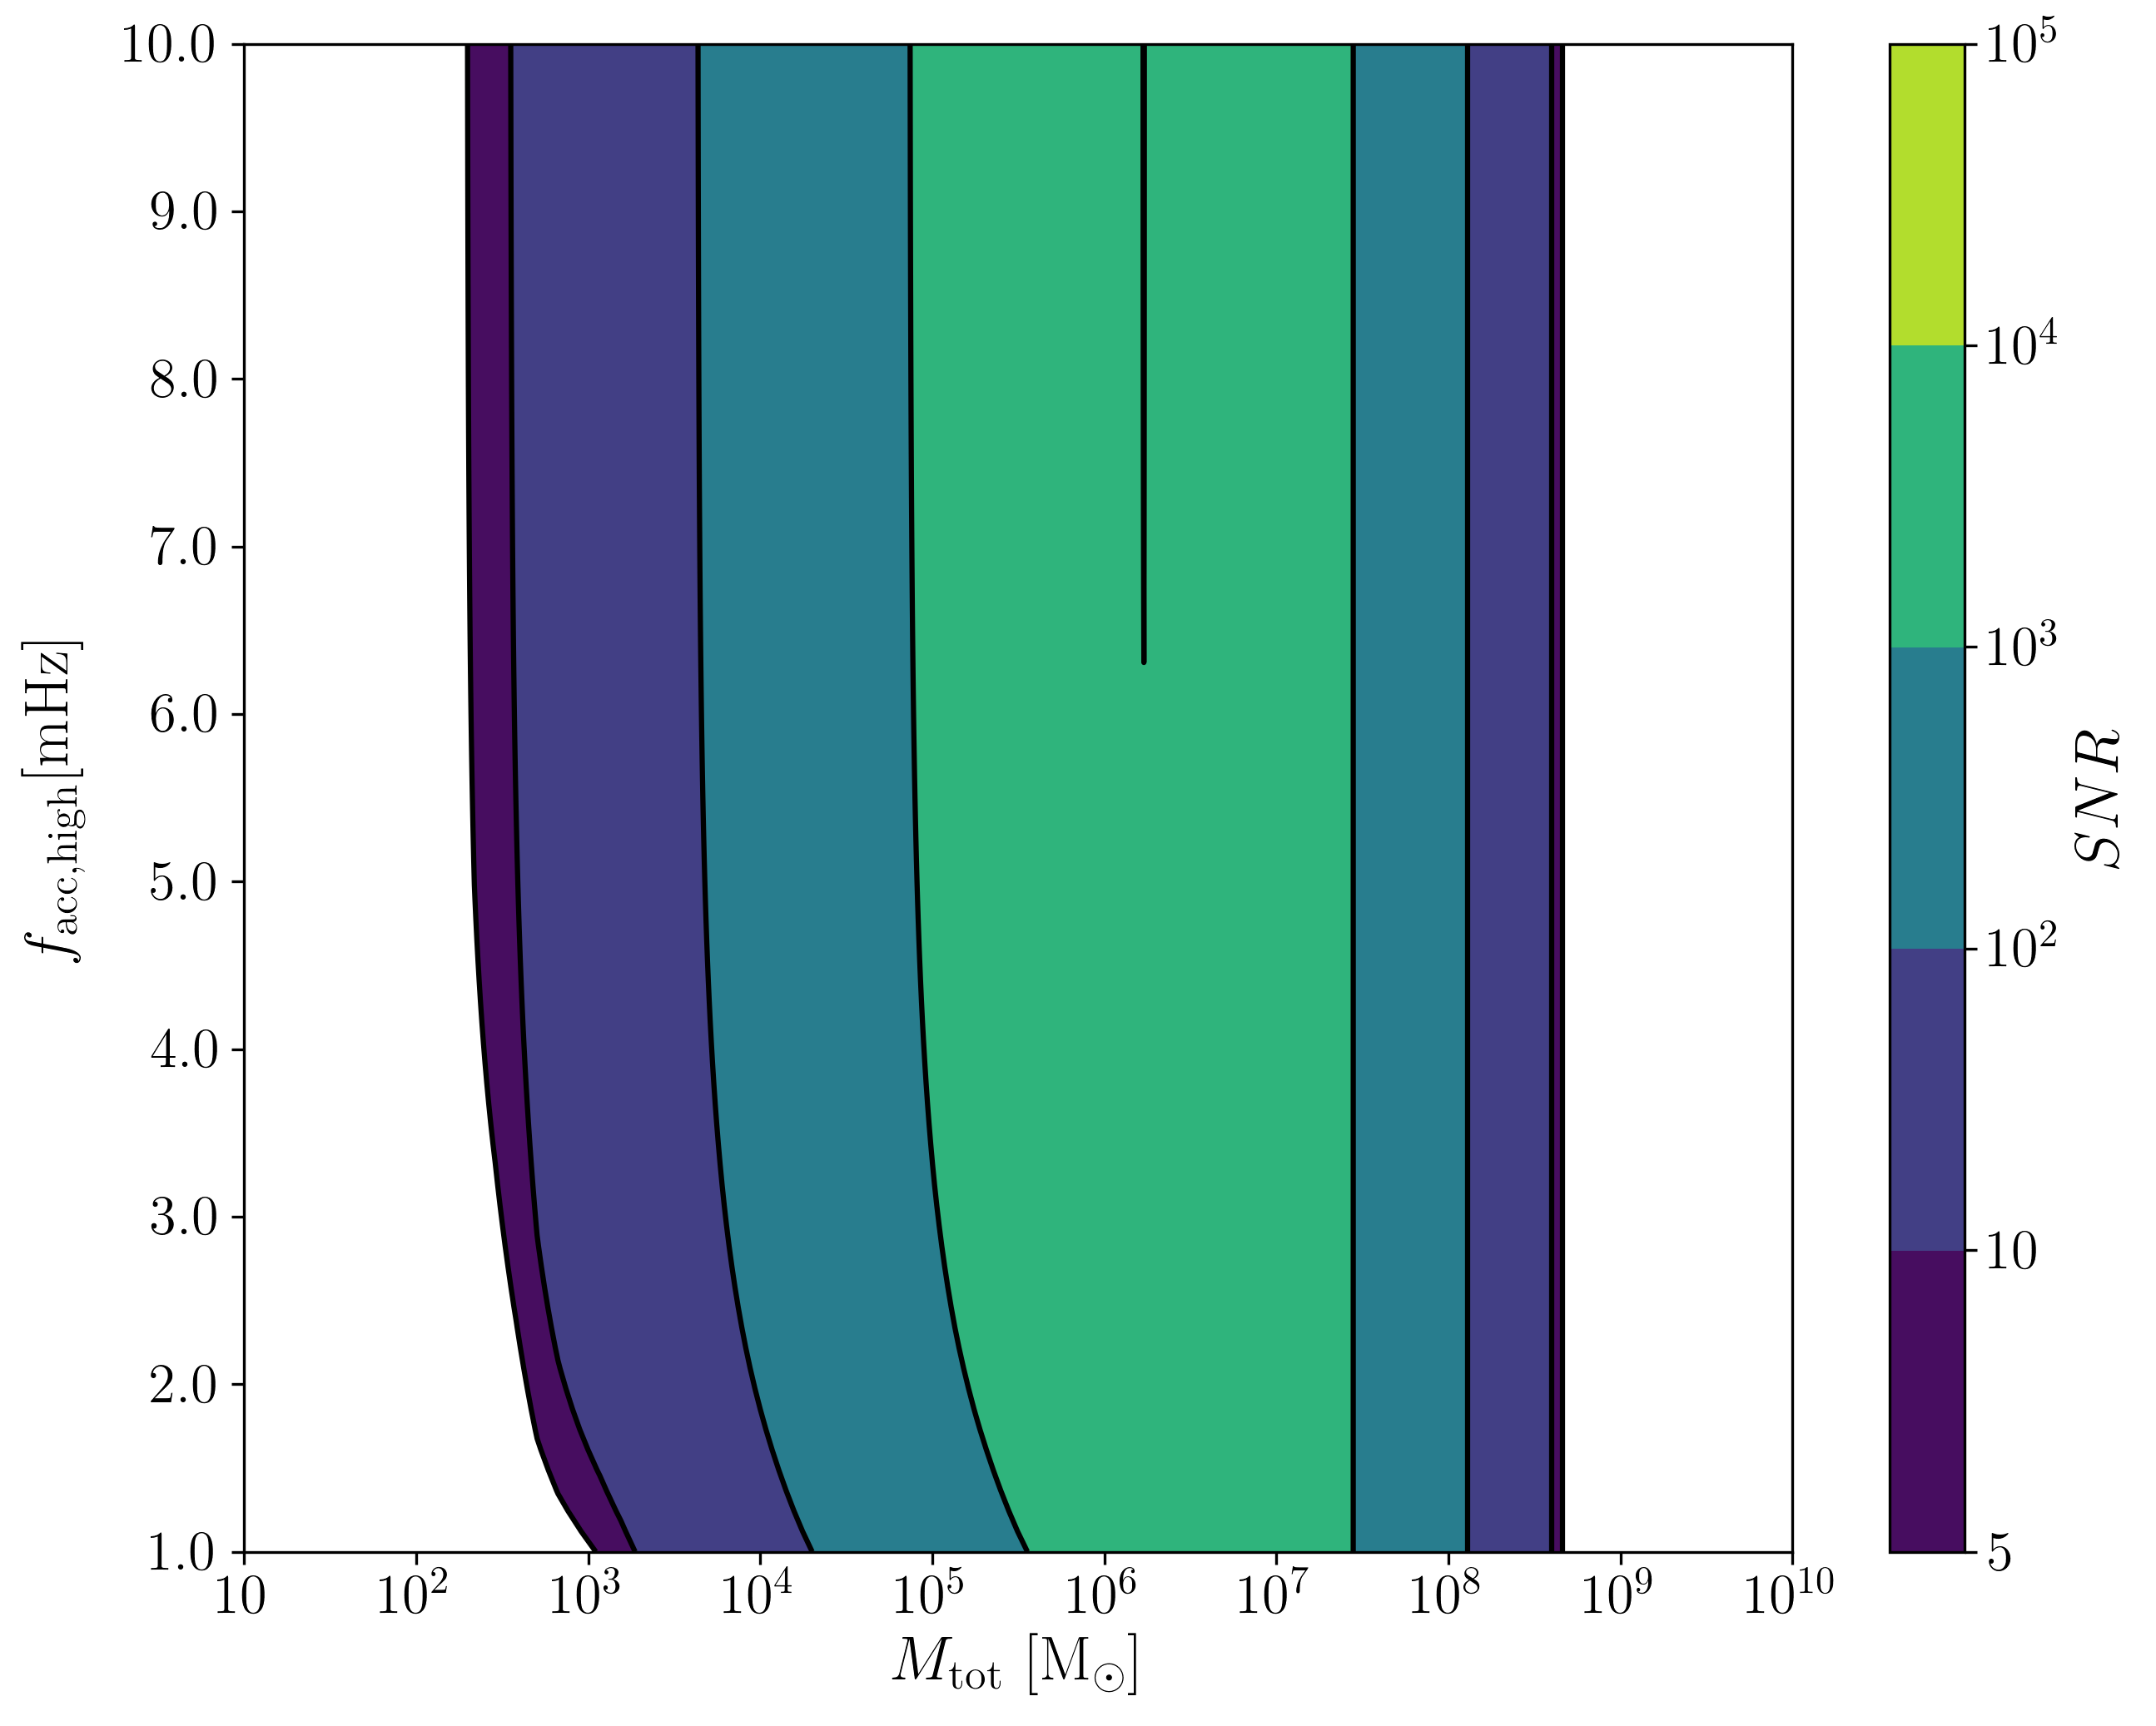

Model:  LISA_ESA ,  done. t = :  38.397035121917725


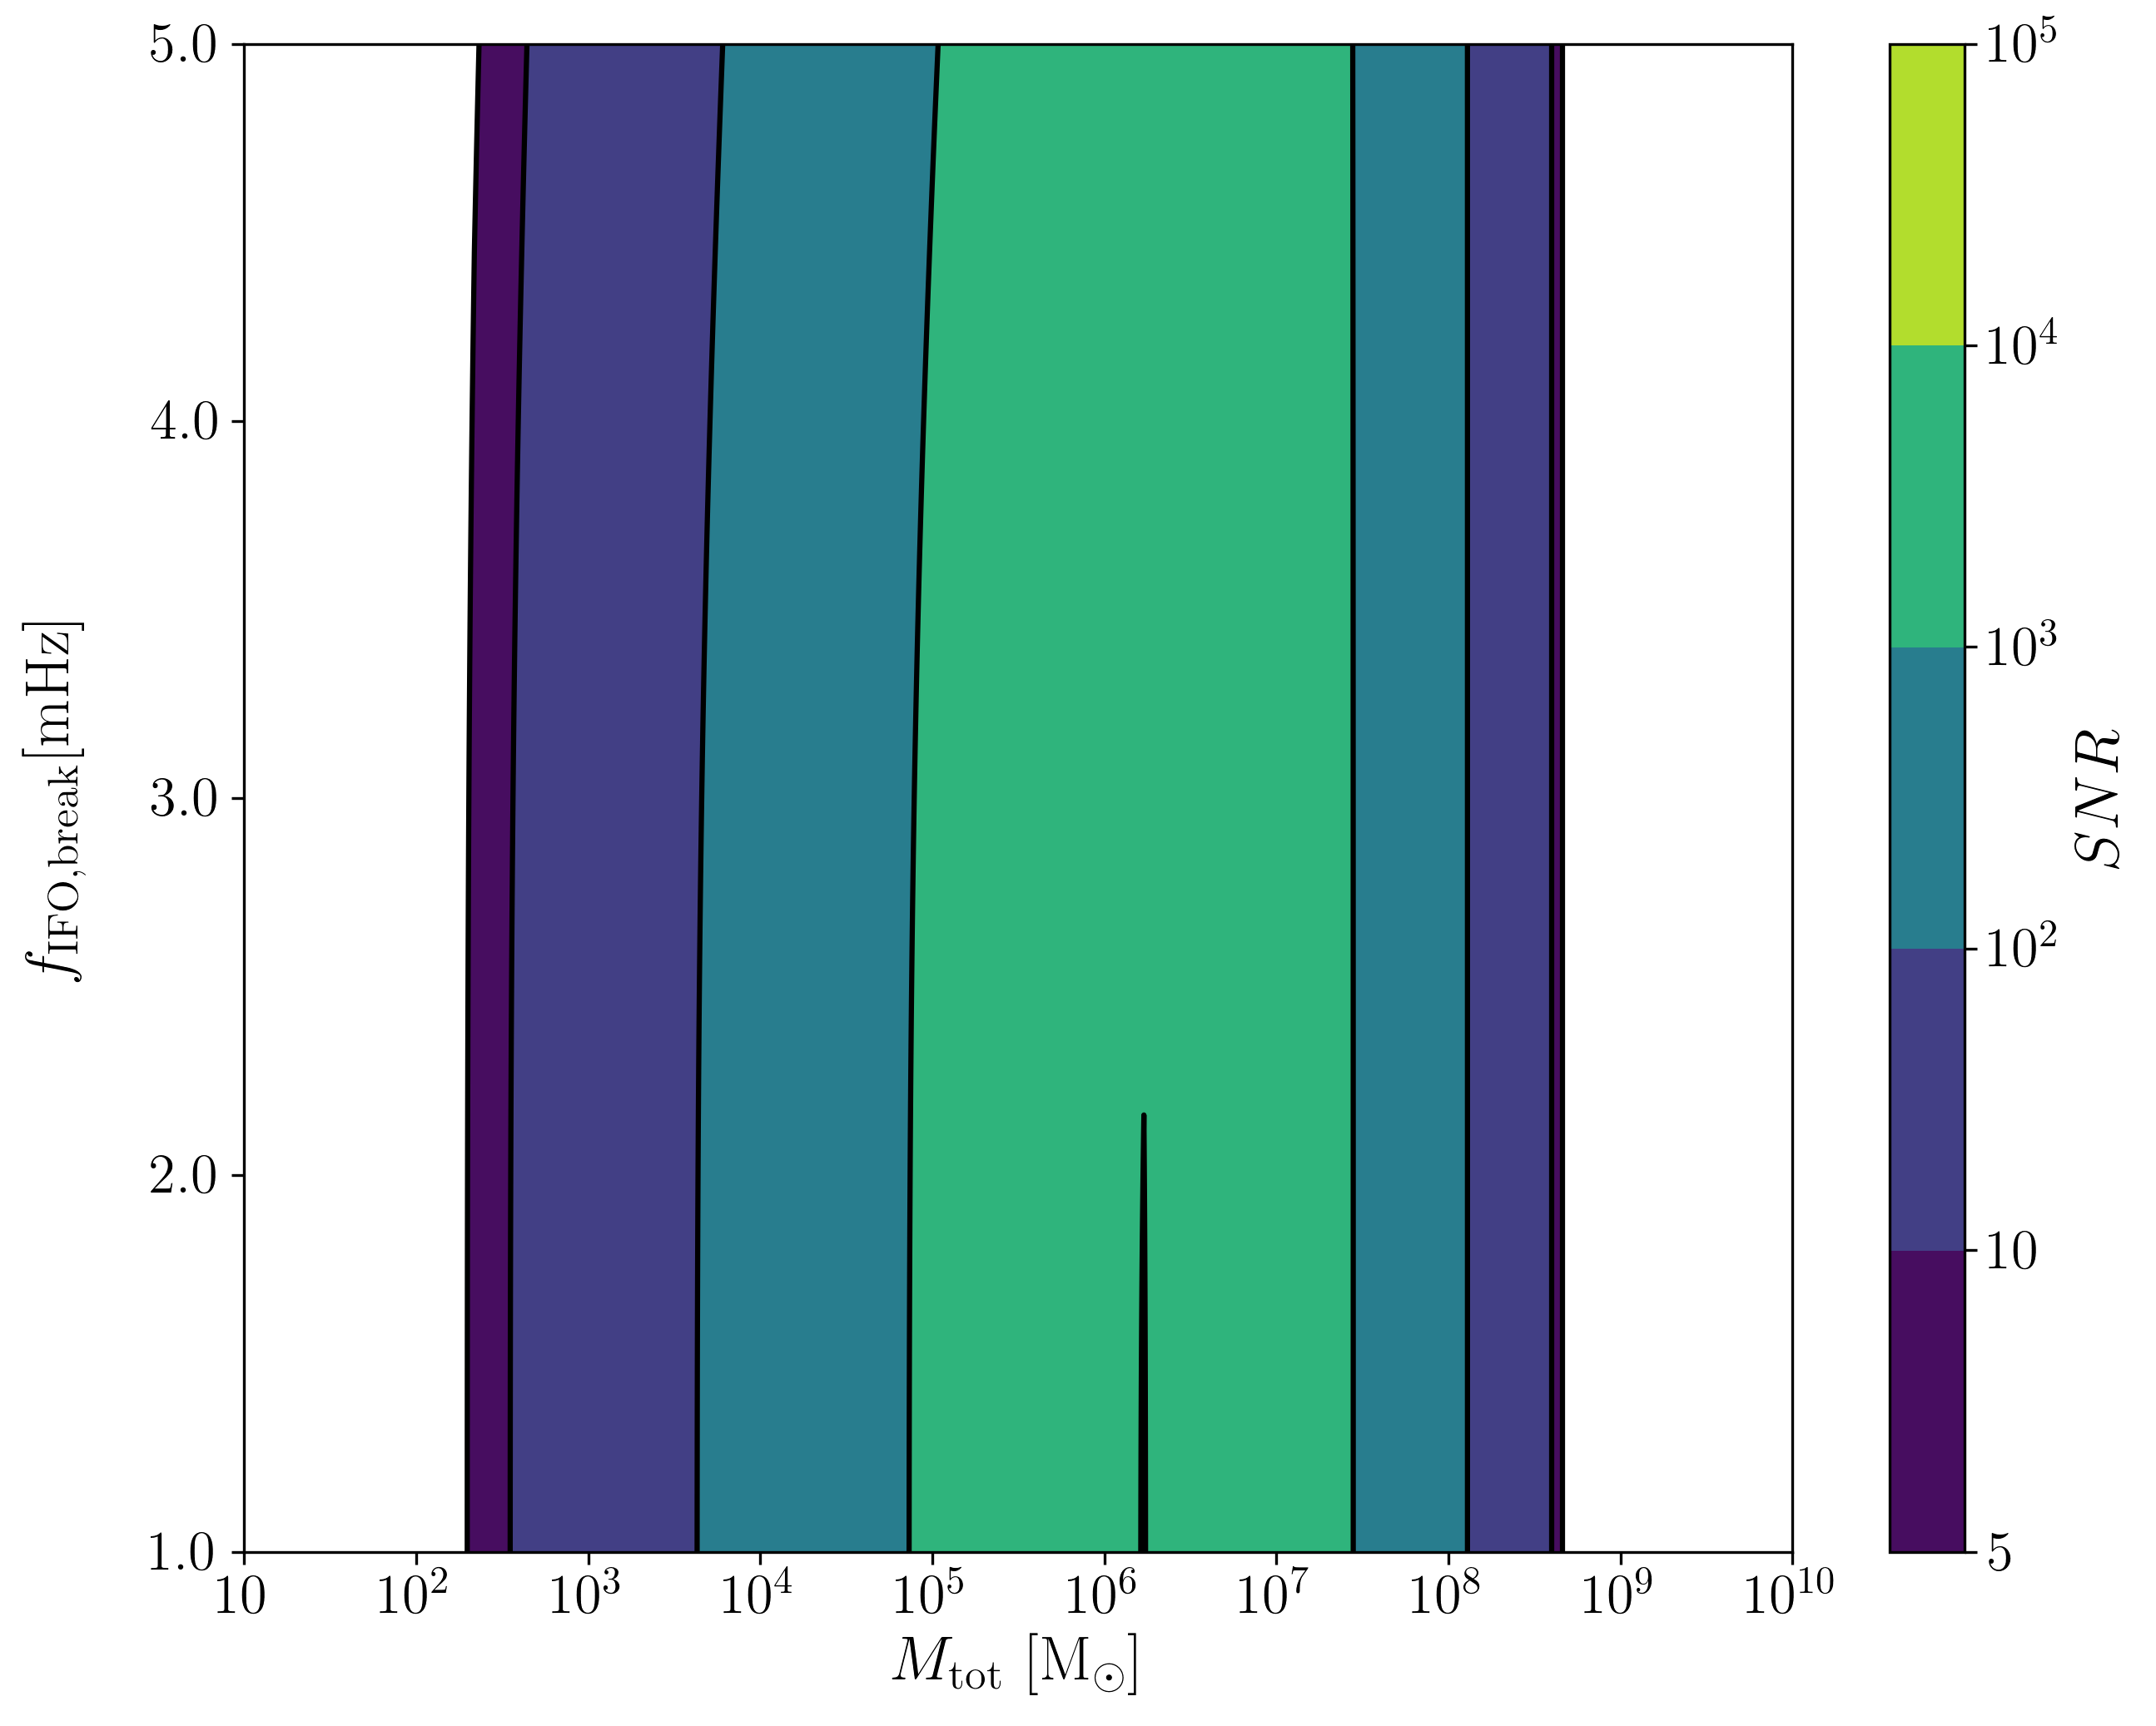

Model:  LISA_ESA ,  done. t = :  36.62411618232727


In [29]:
#Number of SNRMatrix rows
sampleRate_y = 75
#Number of SNRMatrix columns
sampleRate_x = 75
instrument = Get_Instrument(model)
source = Get_Source(model)
for var_y in var_ys:
    figloc = save_directory + 'SNR_' + instrument.name + '_' + var_y + '.png'
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                     dl_axis=False,smooth_contours=False,figloc=figloc)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)

### Global Detector Params

* 'T_obs' - Observation Time Length

In [36]:
#Variable on y-axis
var_y = 'T_obs'
#Variable on x-axis
var_x = 'M'
models = [2,3,5,7]

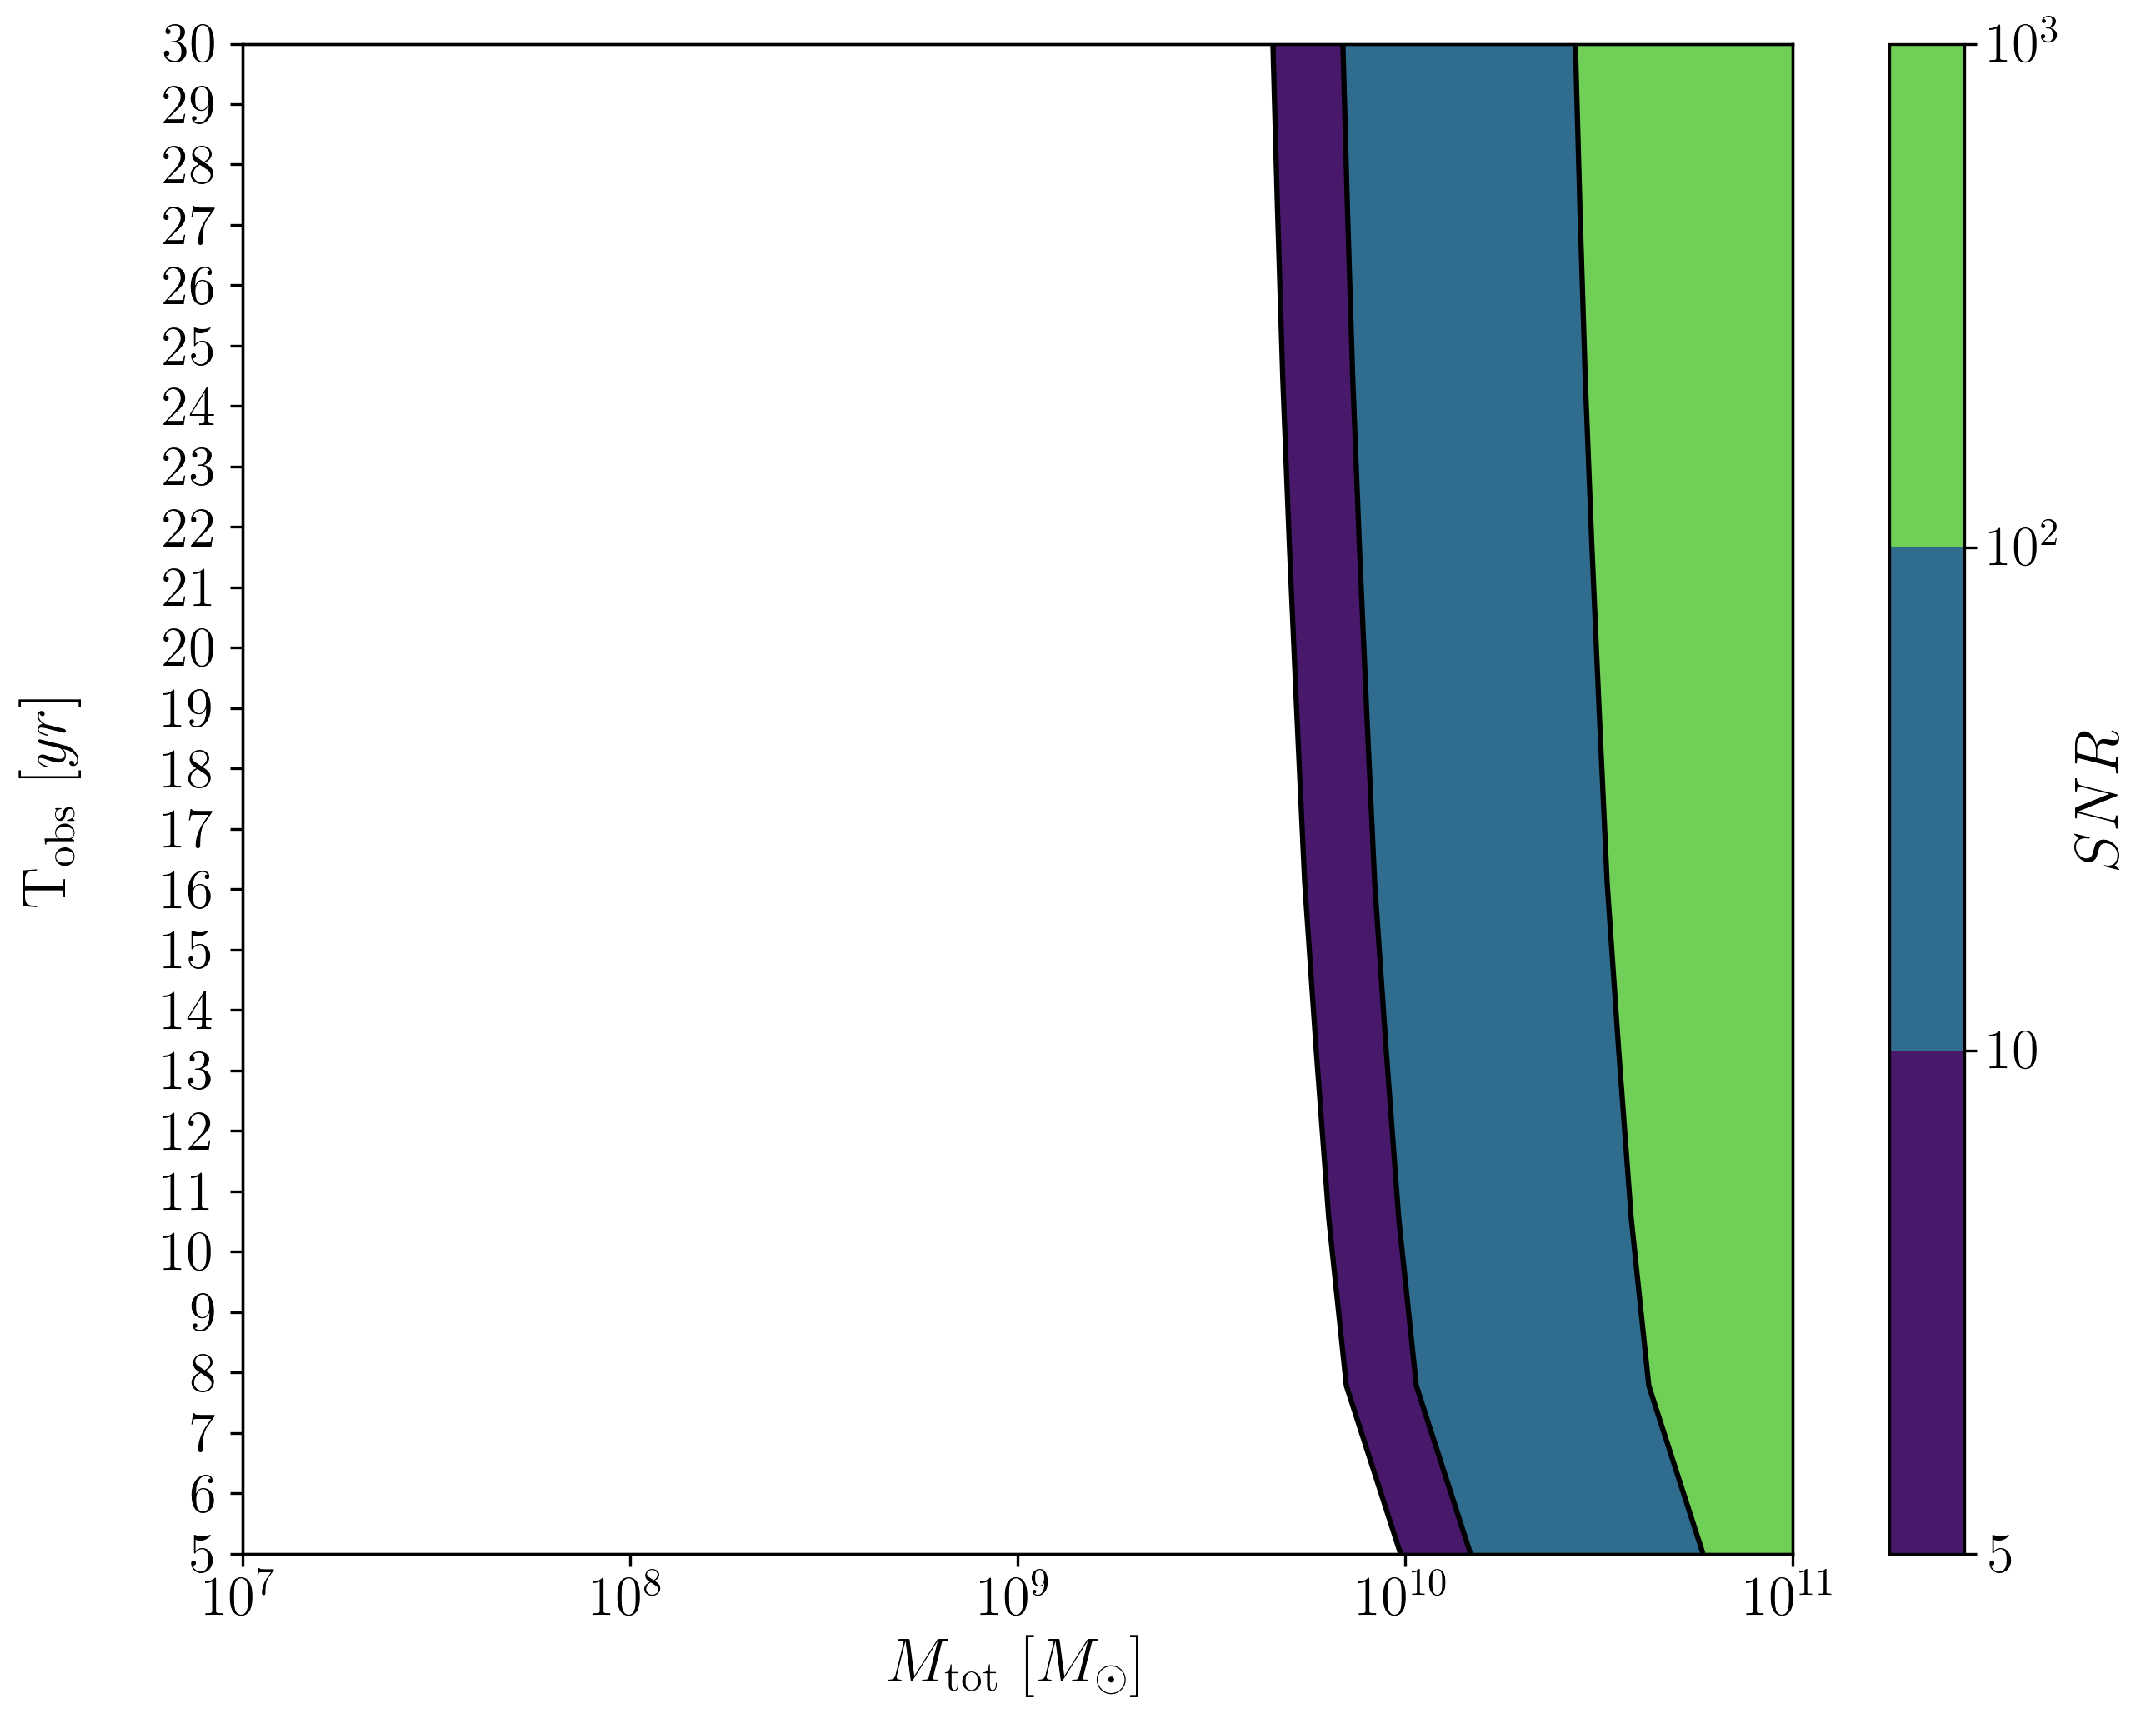

Model:  NANOGrav ,  done. t = :  46.3982470035553


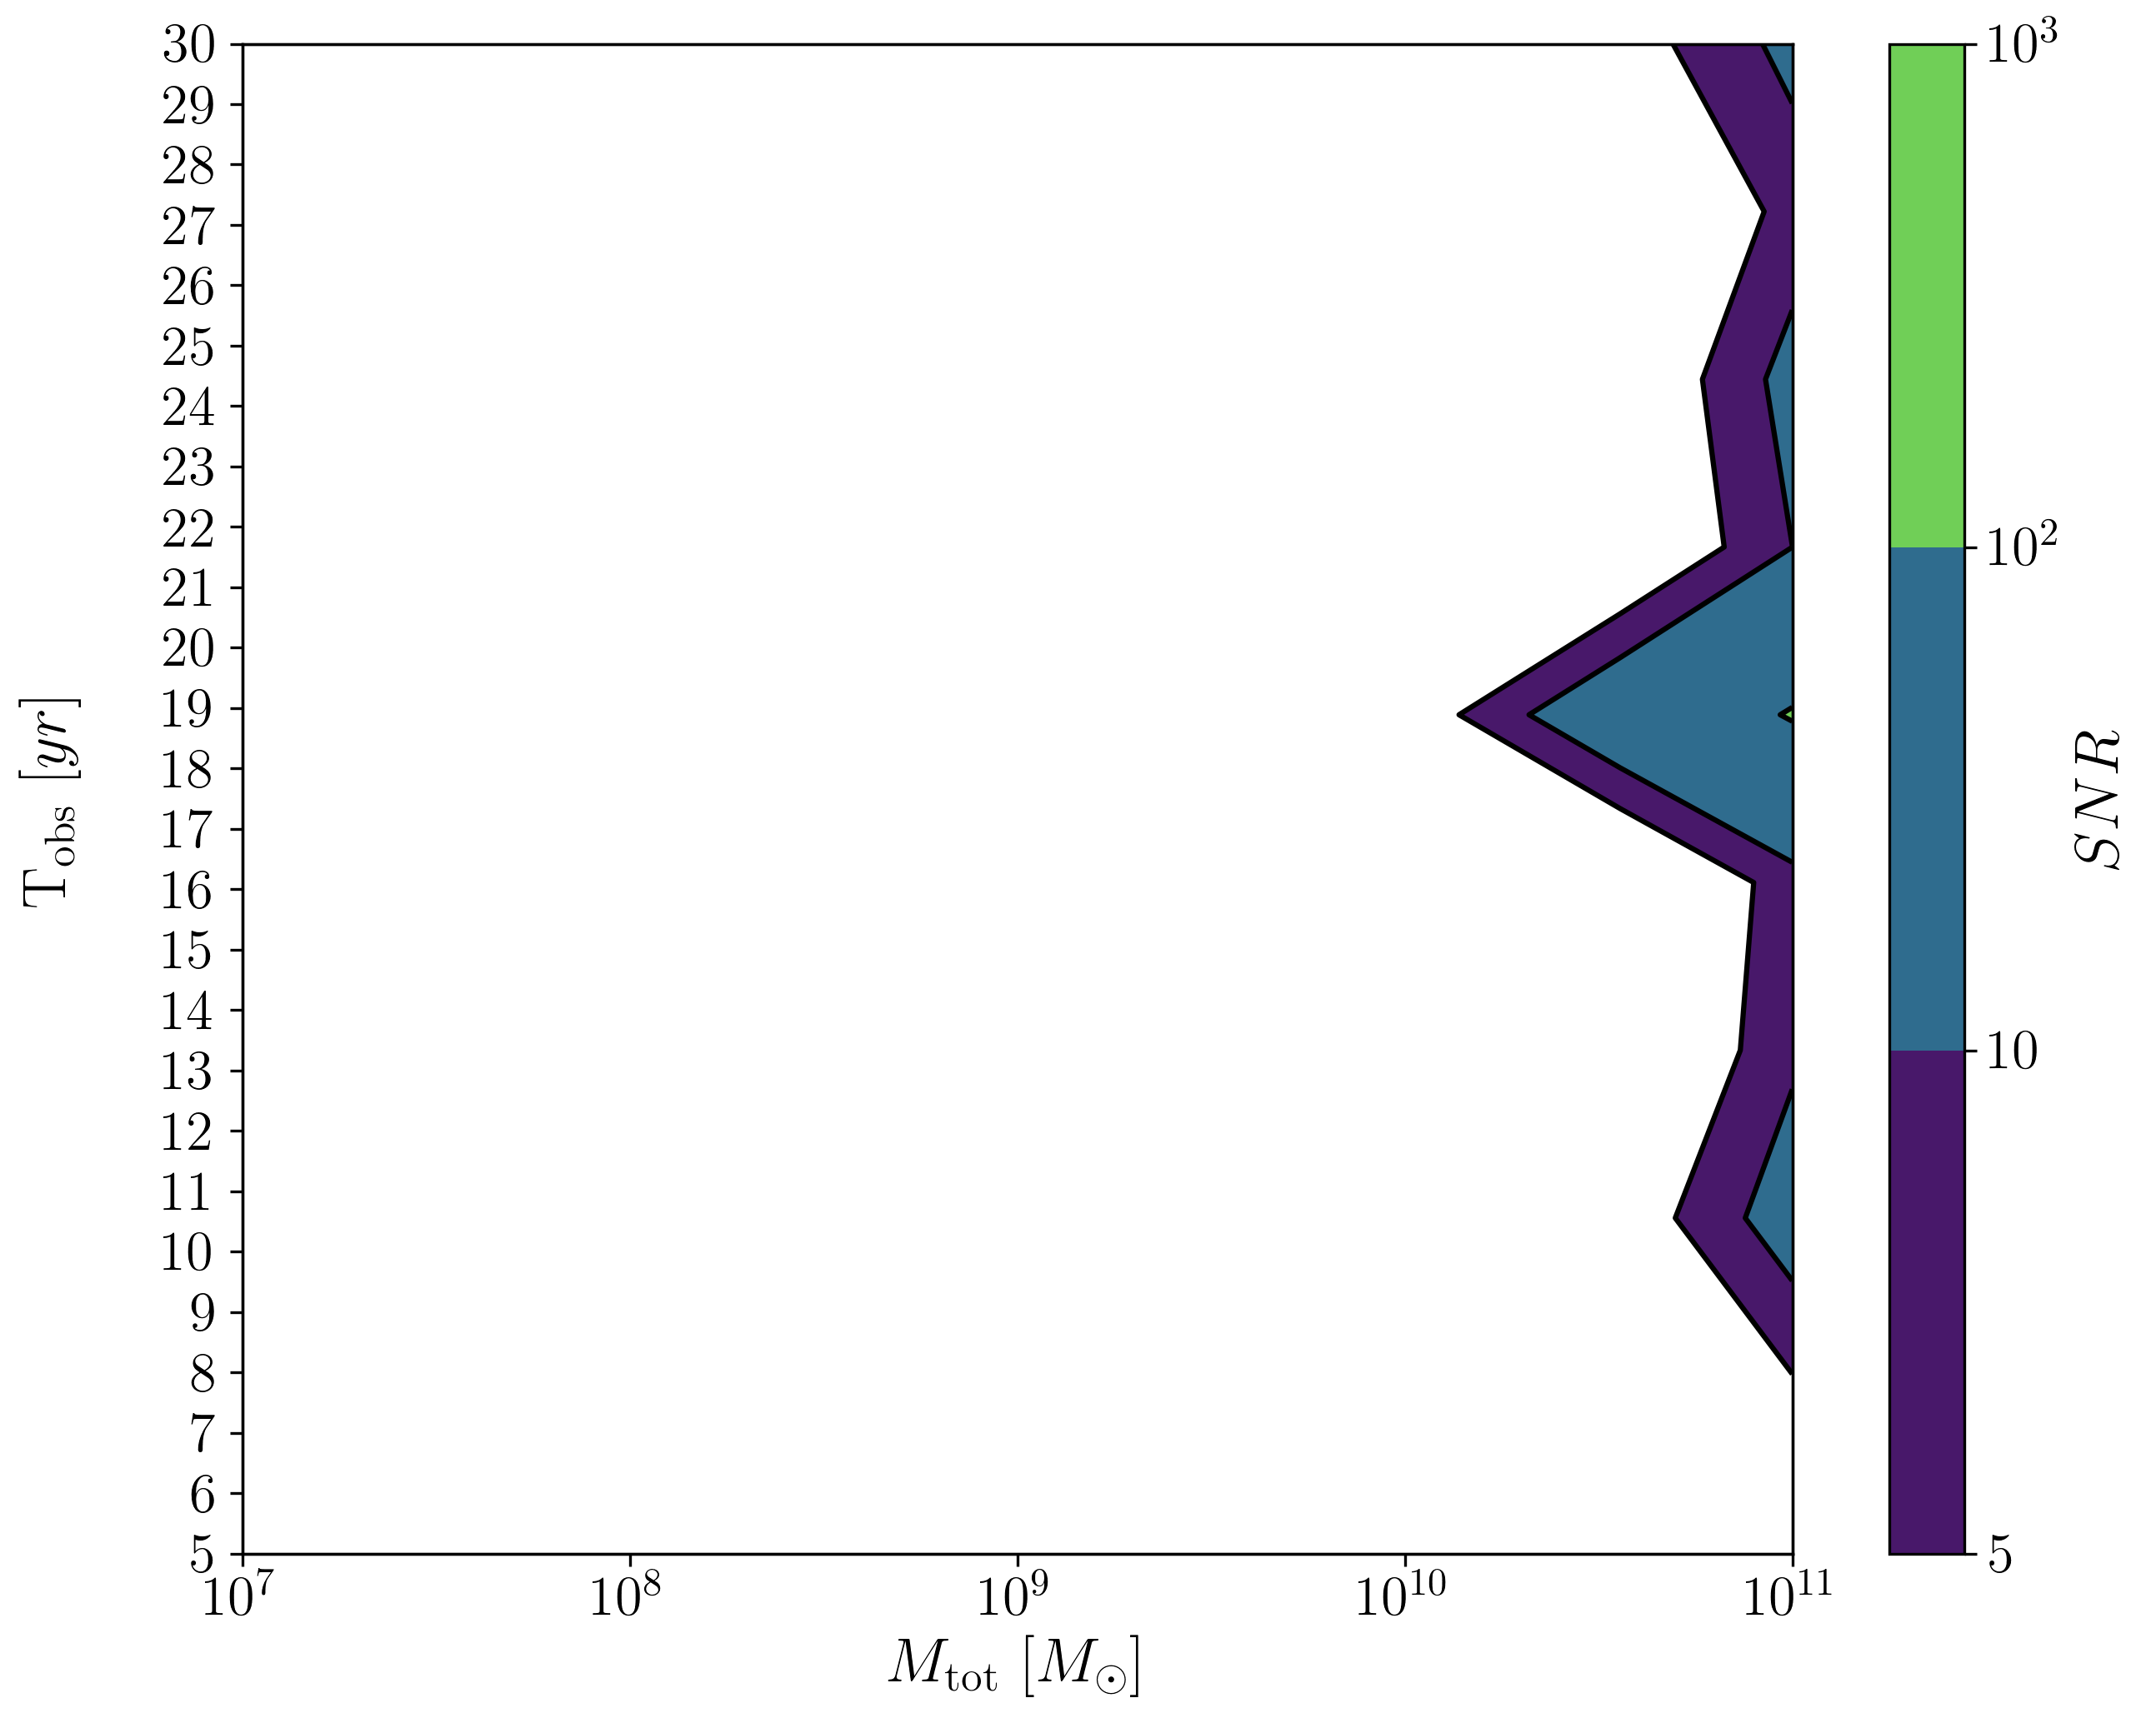

Model:  NANOGrav, WN and RN ,  done. t = :  57.942249059677124


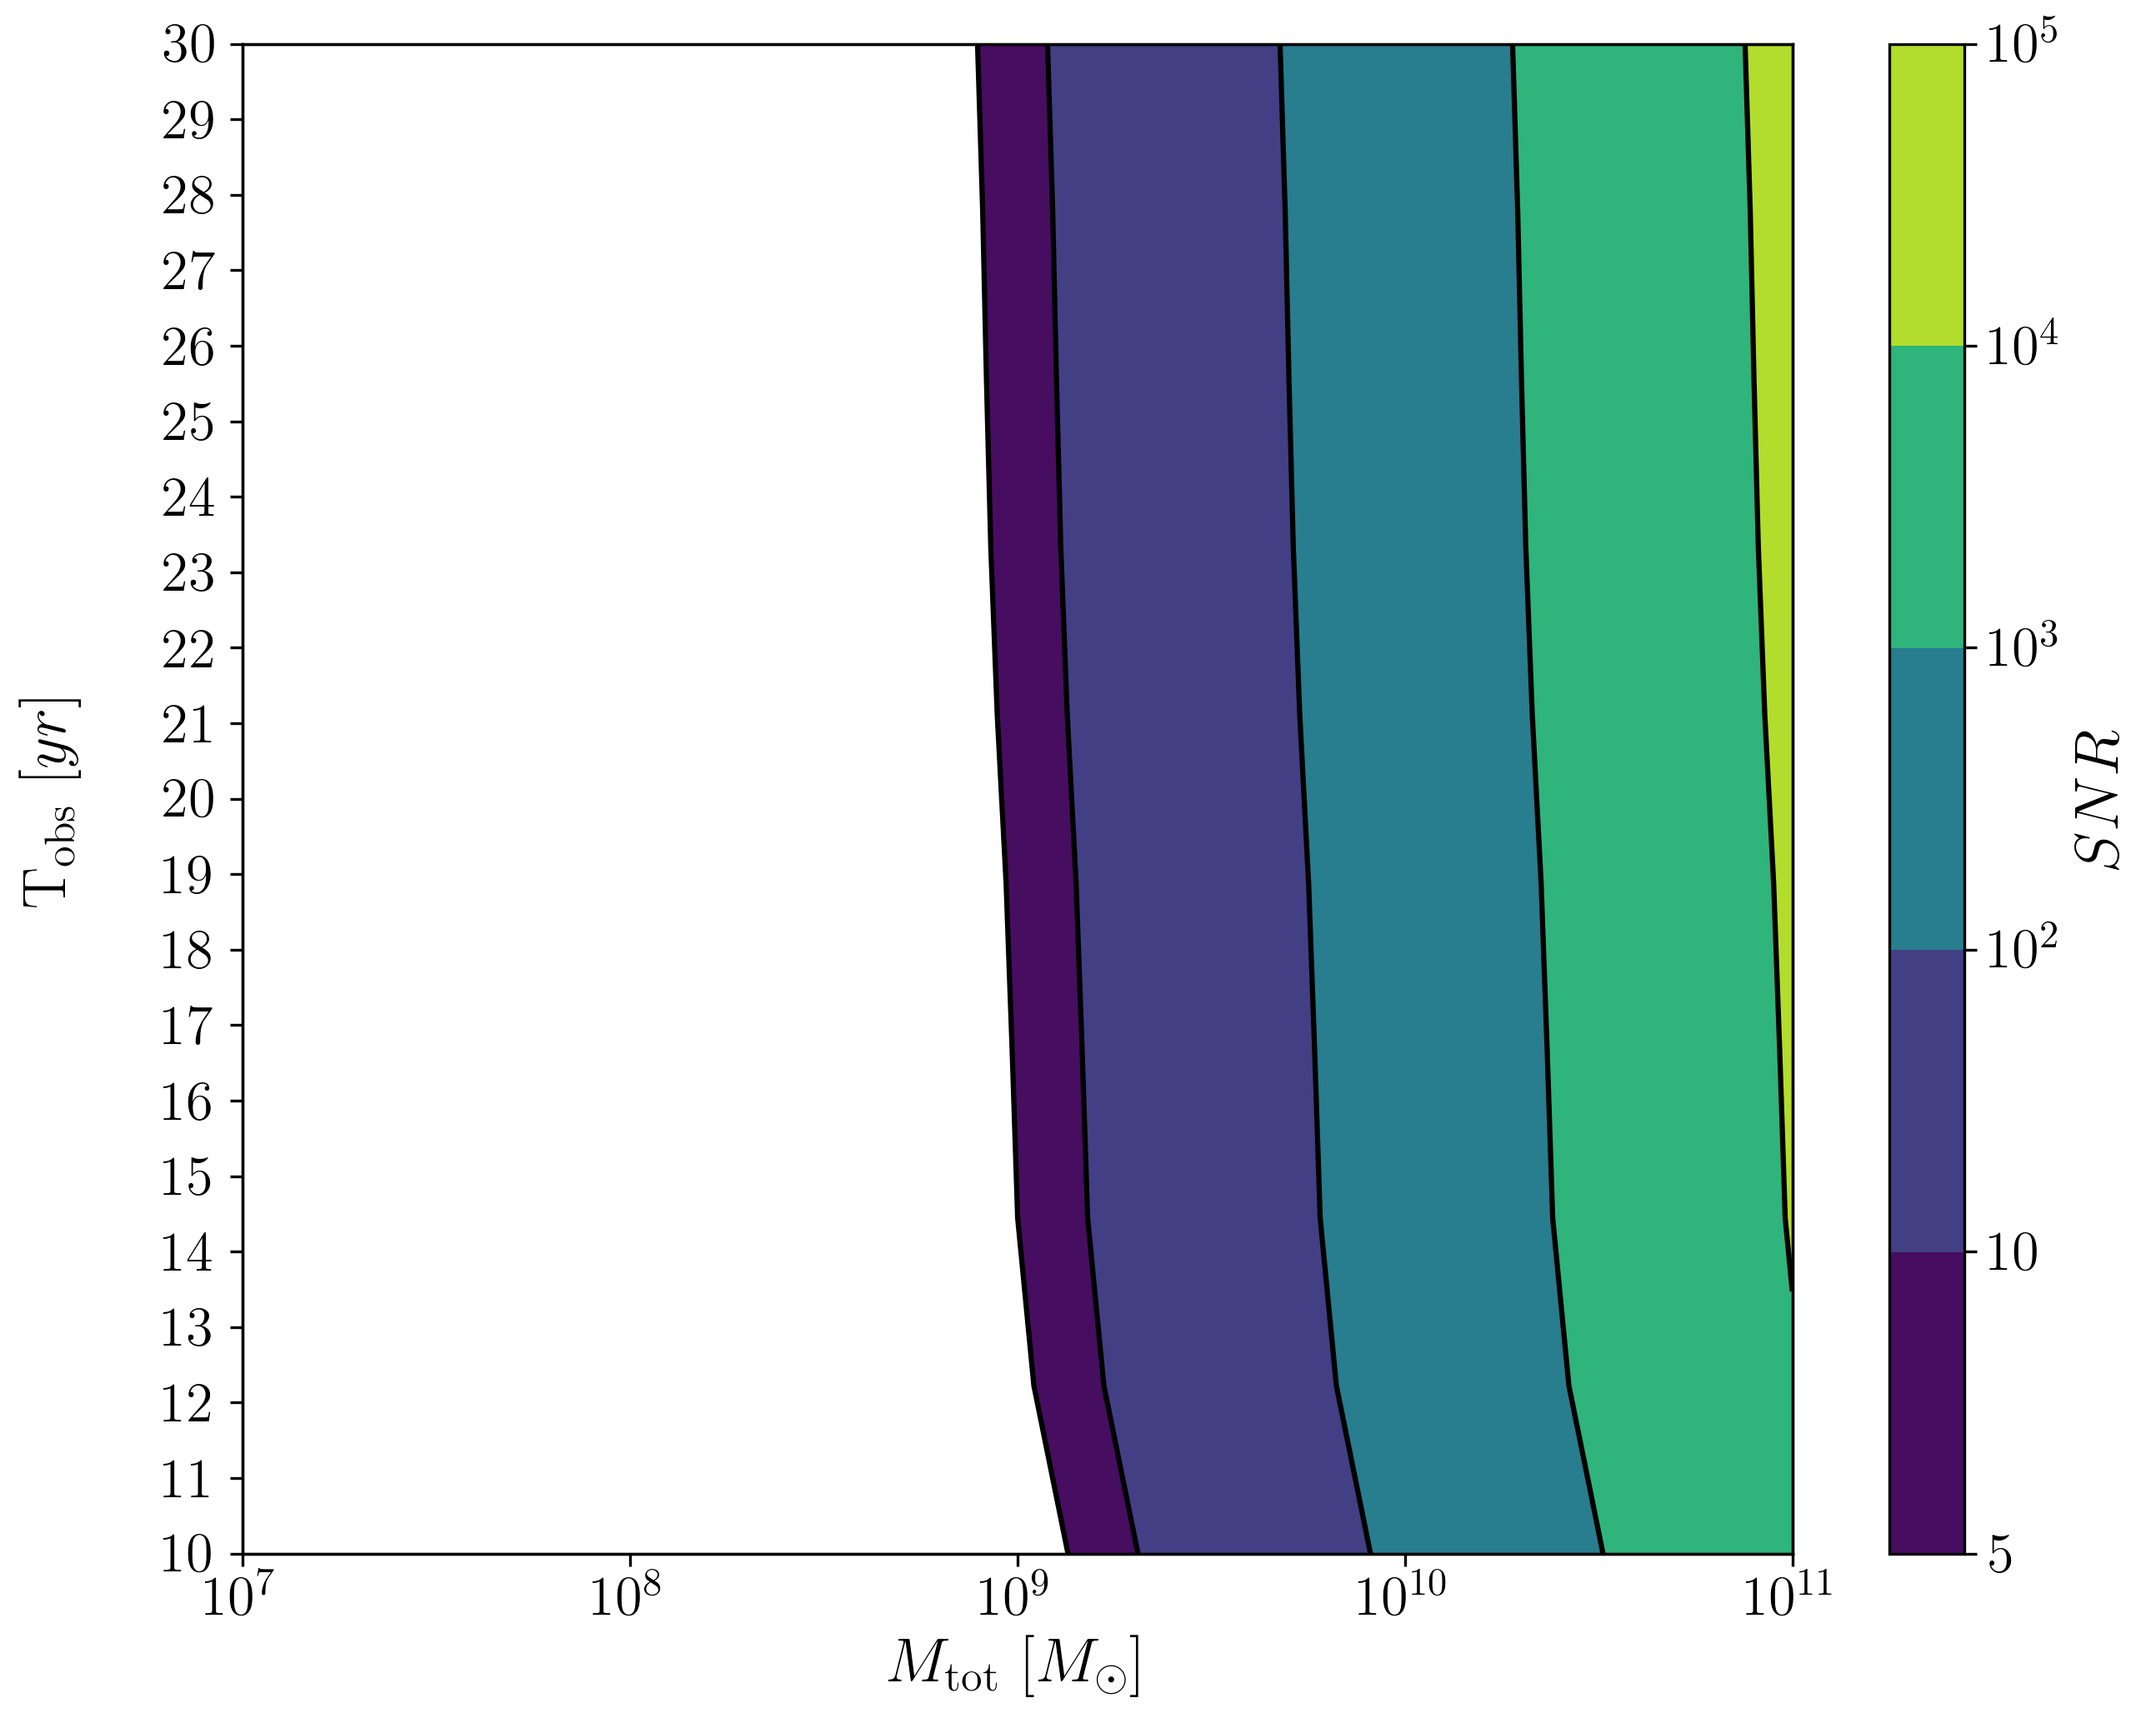

Model:  SKA ,  done. t = :  195.4713590145111


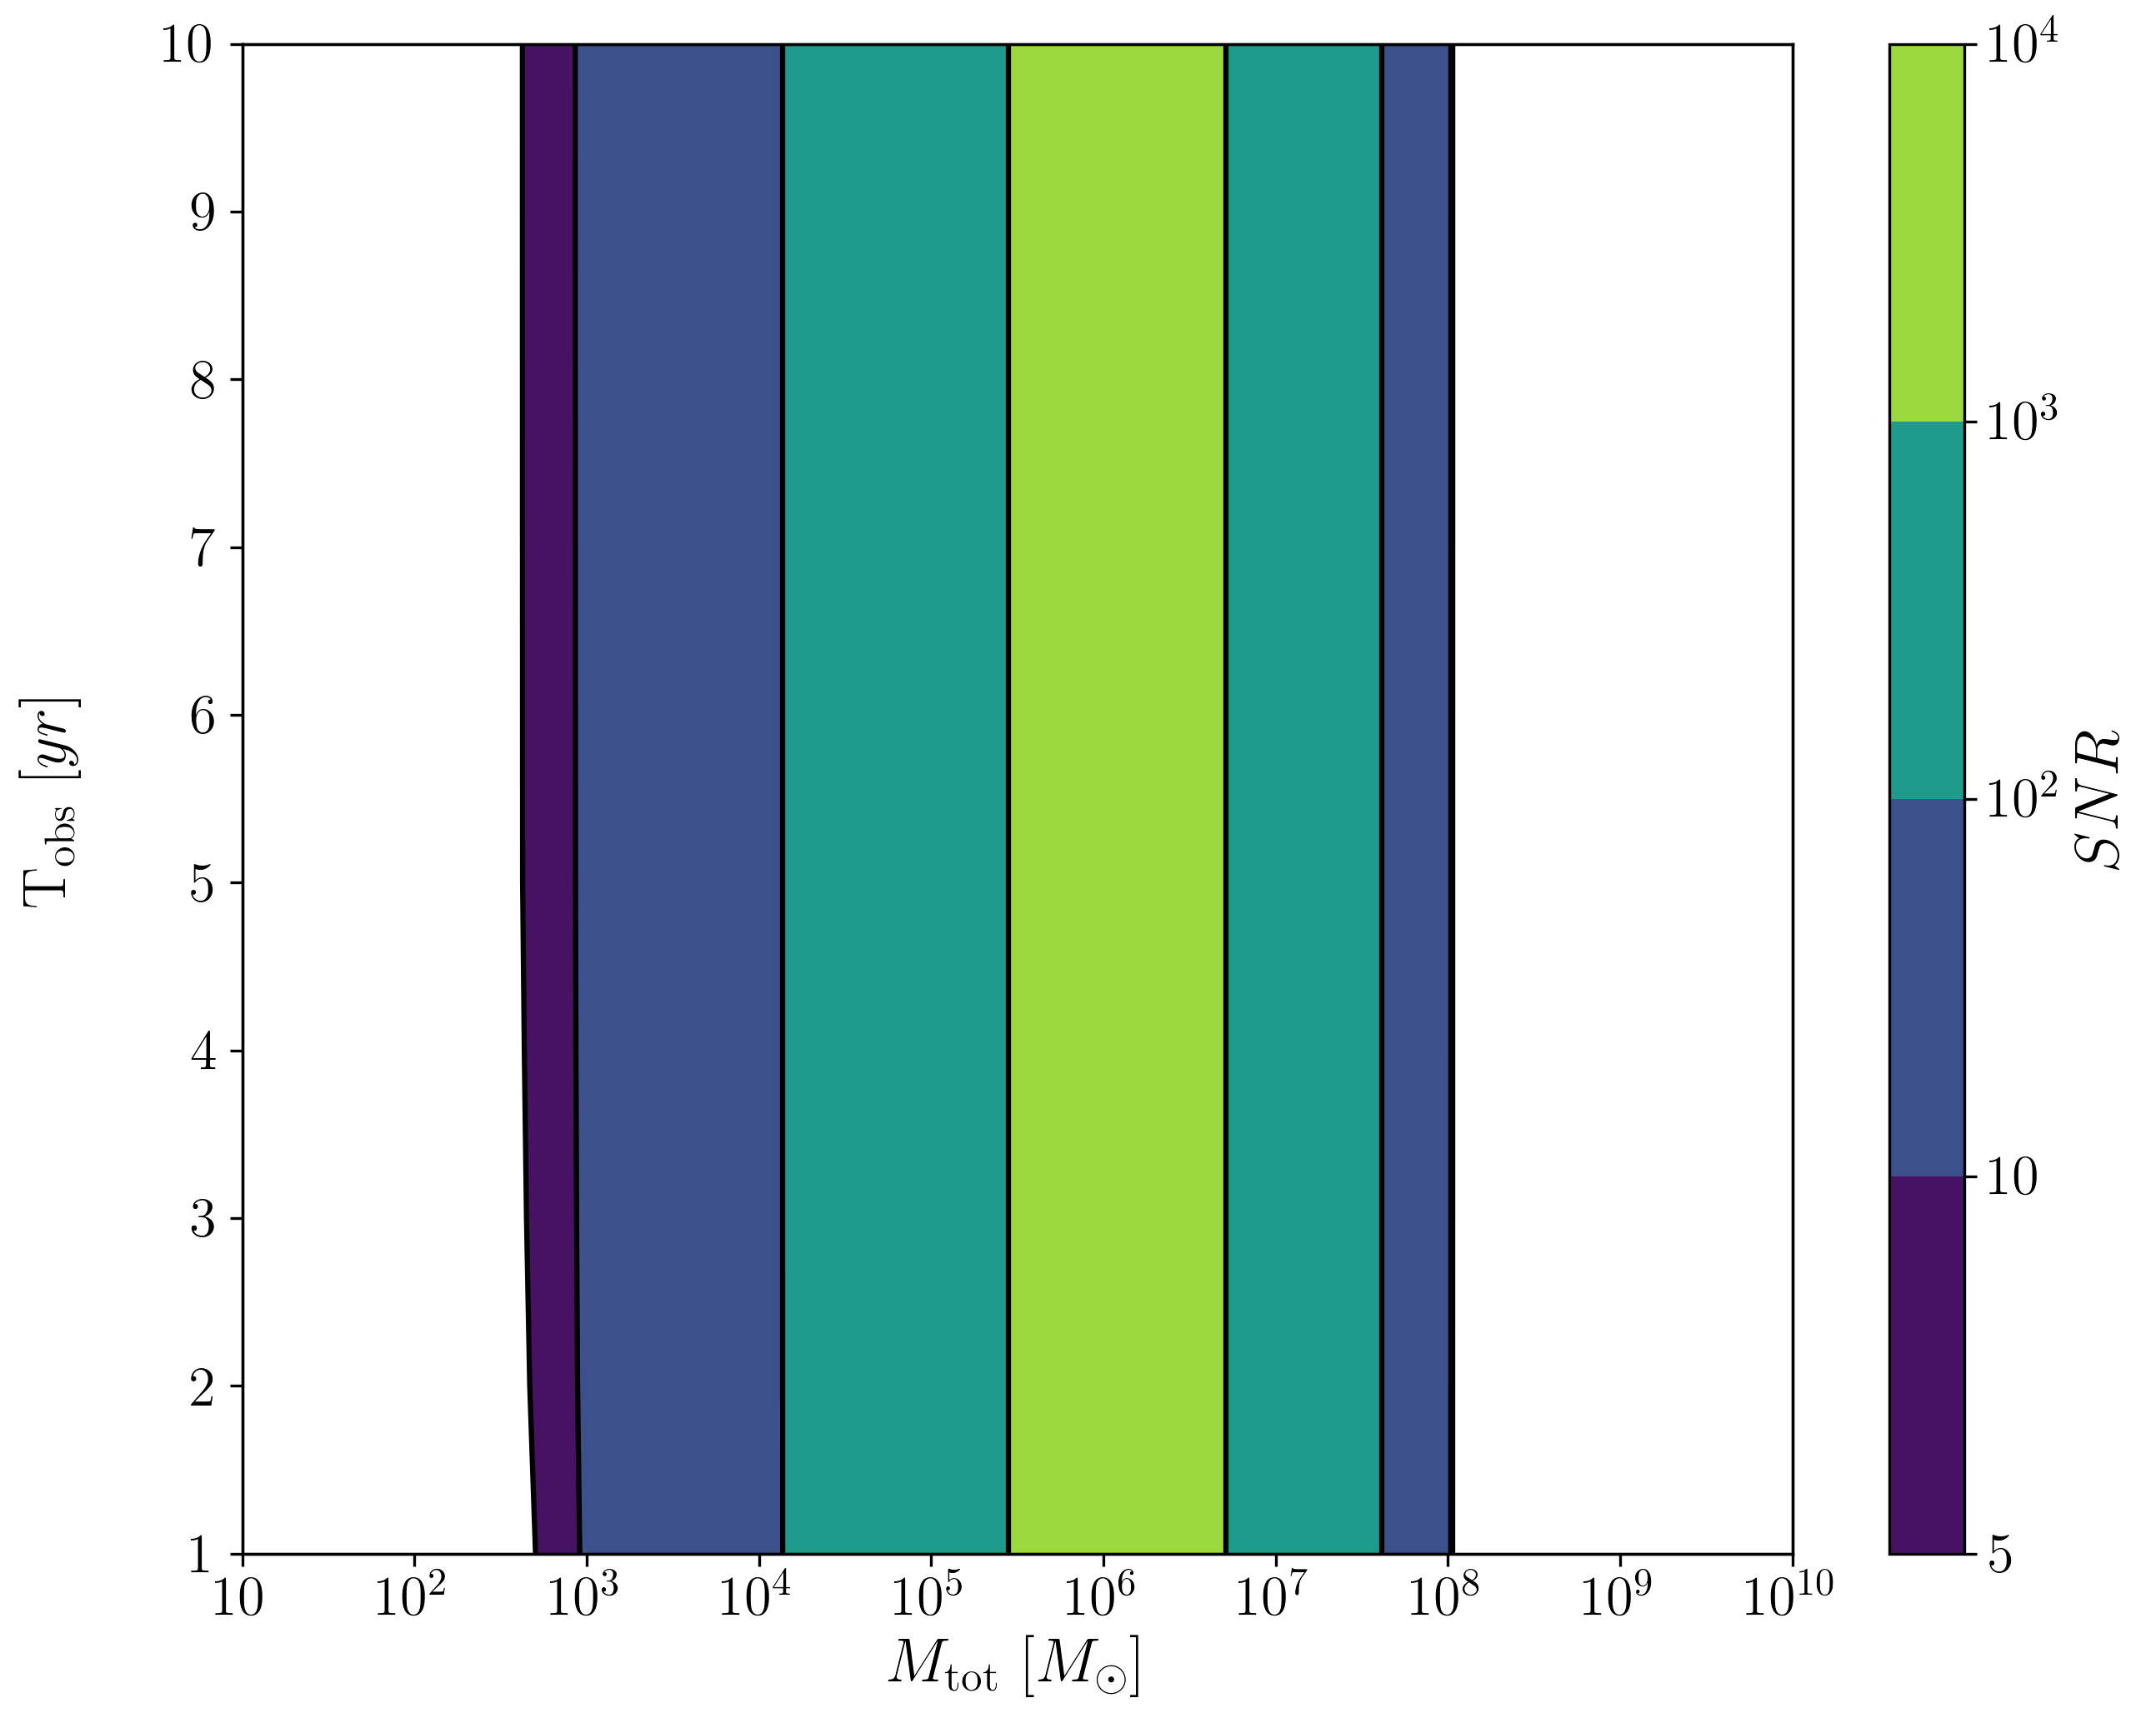

Model:  LISA_ESA ,  done. t = :  0.7642087936401367


In [37]:
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)

    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,dl_axis=False,smooth_contours=False)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)

### Global Source Params for all Fiducial Detectors

* 'M' - Mass (Solar Units)
* 'q' - Mass Ratio
* 'chi1' - Dimensionless Spin of Black Hole 1
* 'chi2' - Dimensionless Spin of Black Hole 2
* 'z' - Redshift

In [36]:
#Variable on y-axis
var_ys = ['q','chi1']
#Variable on x-axis
var_x = 'M'
models = range(8)

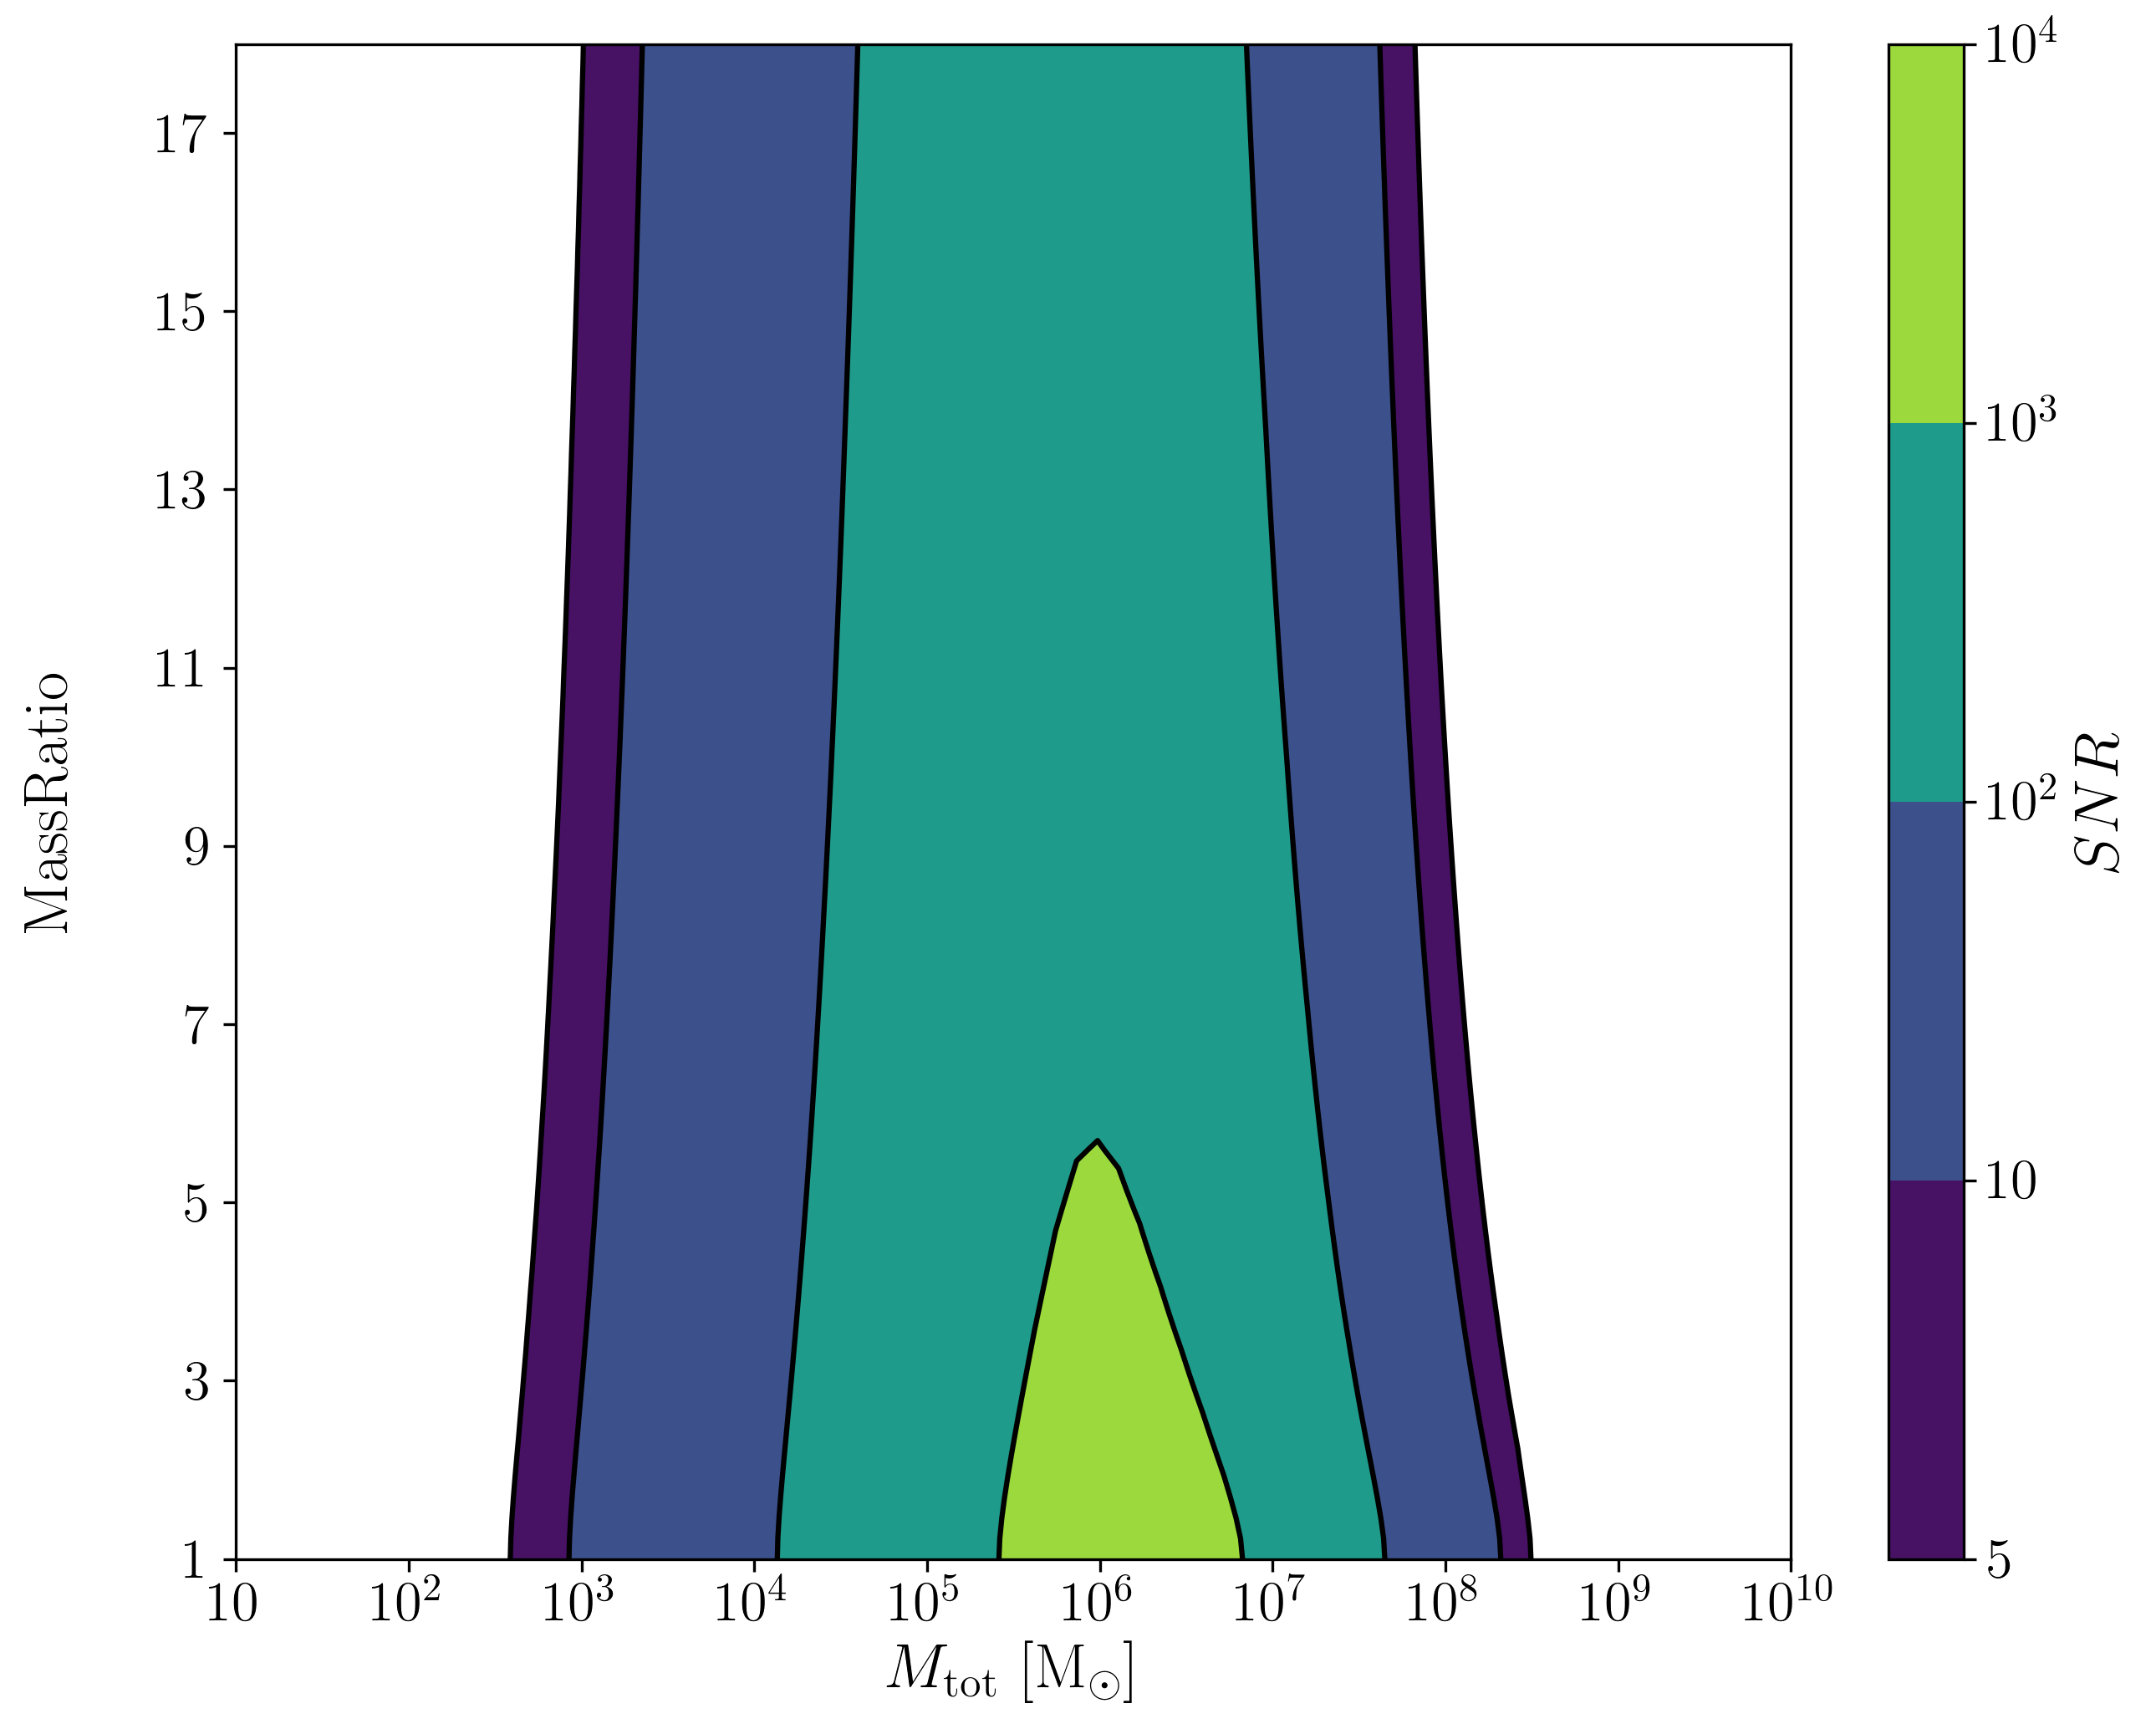

Model:  LISA_ESA ,  done. t = :  45.29520010948181


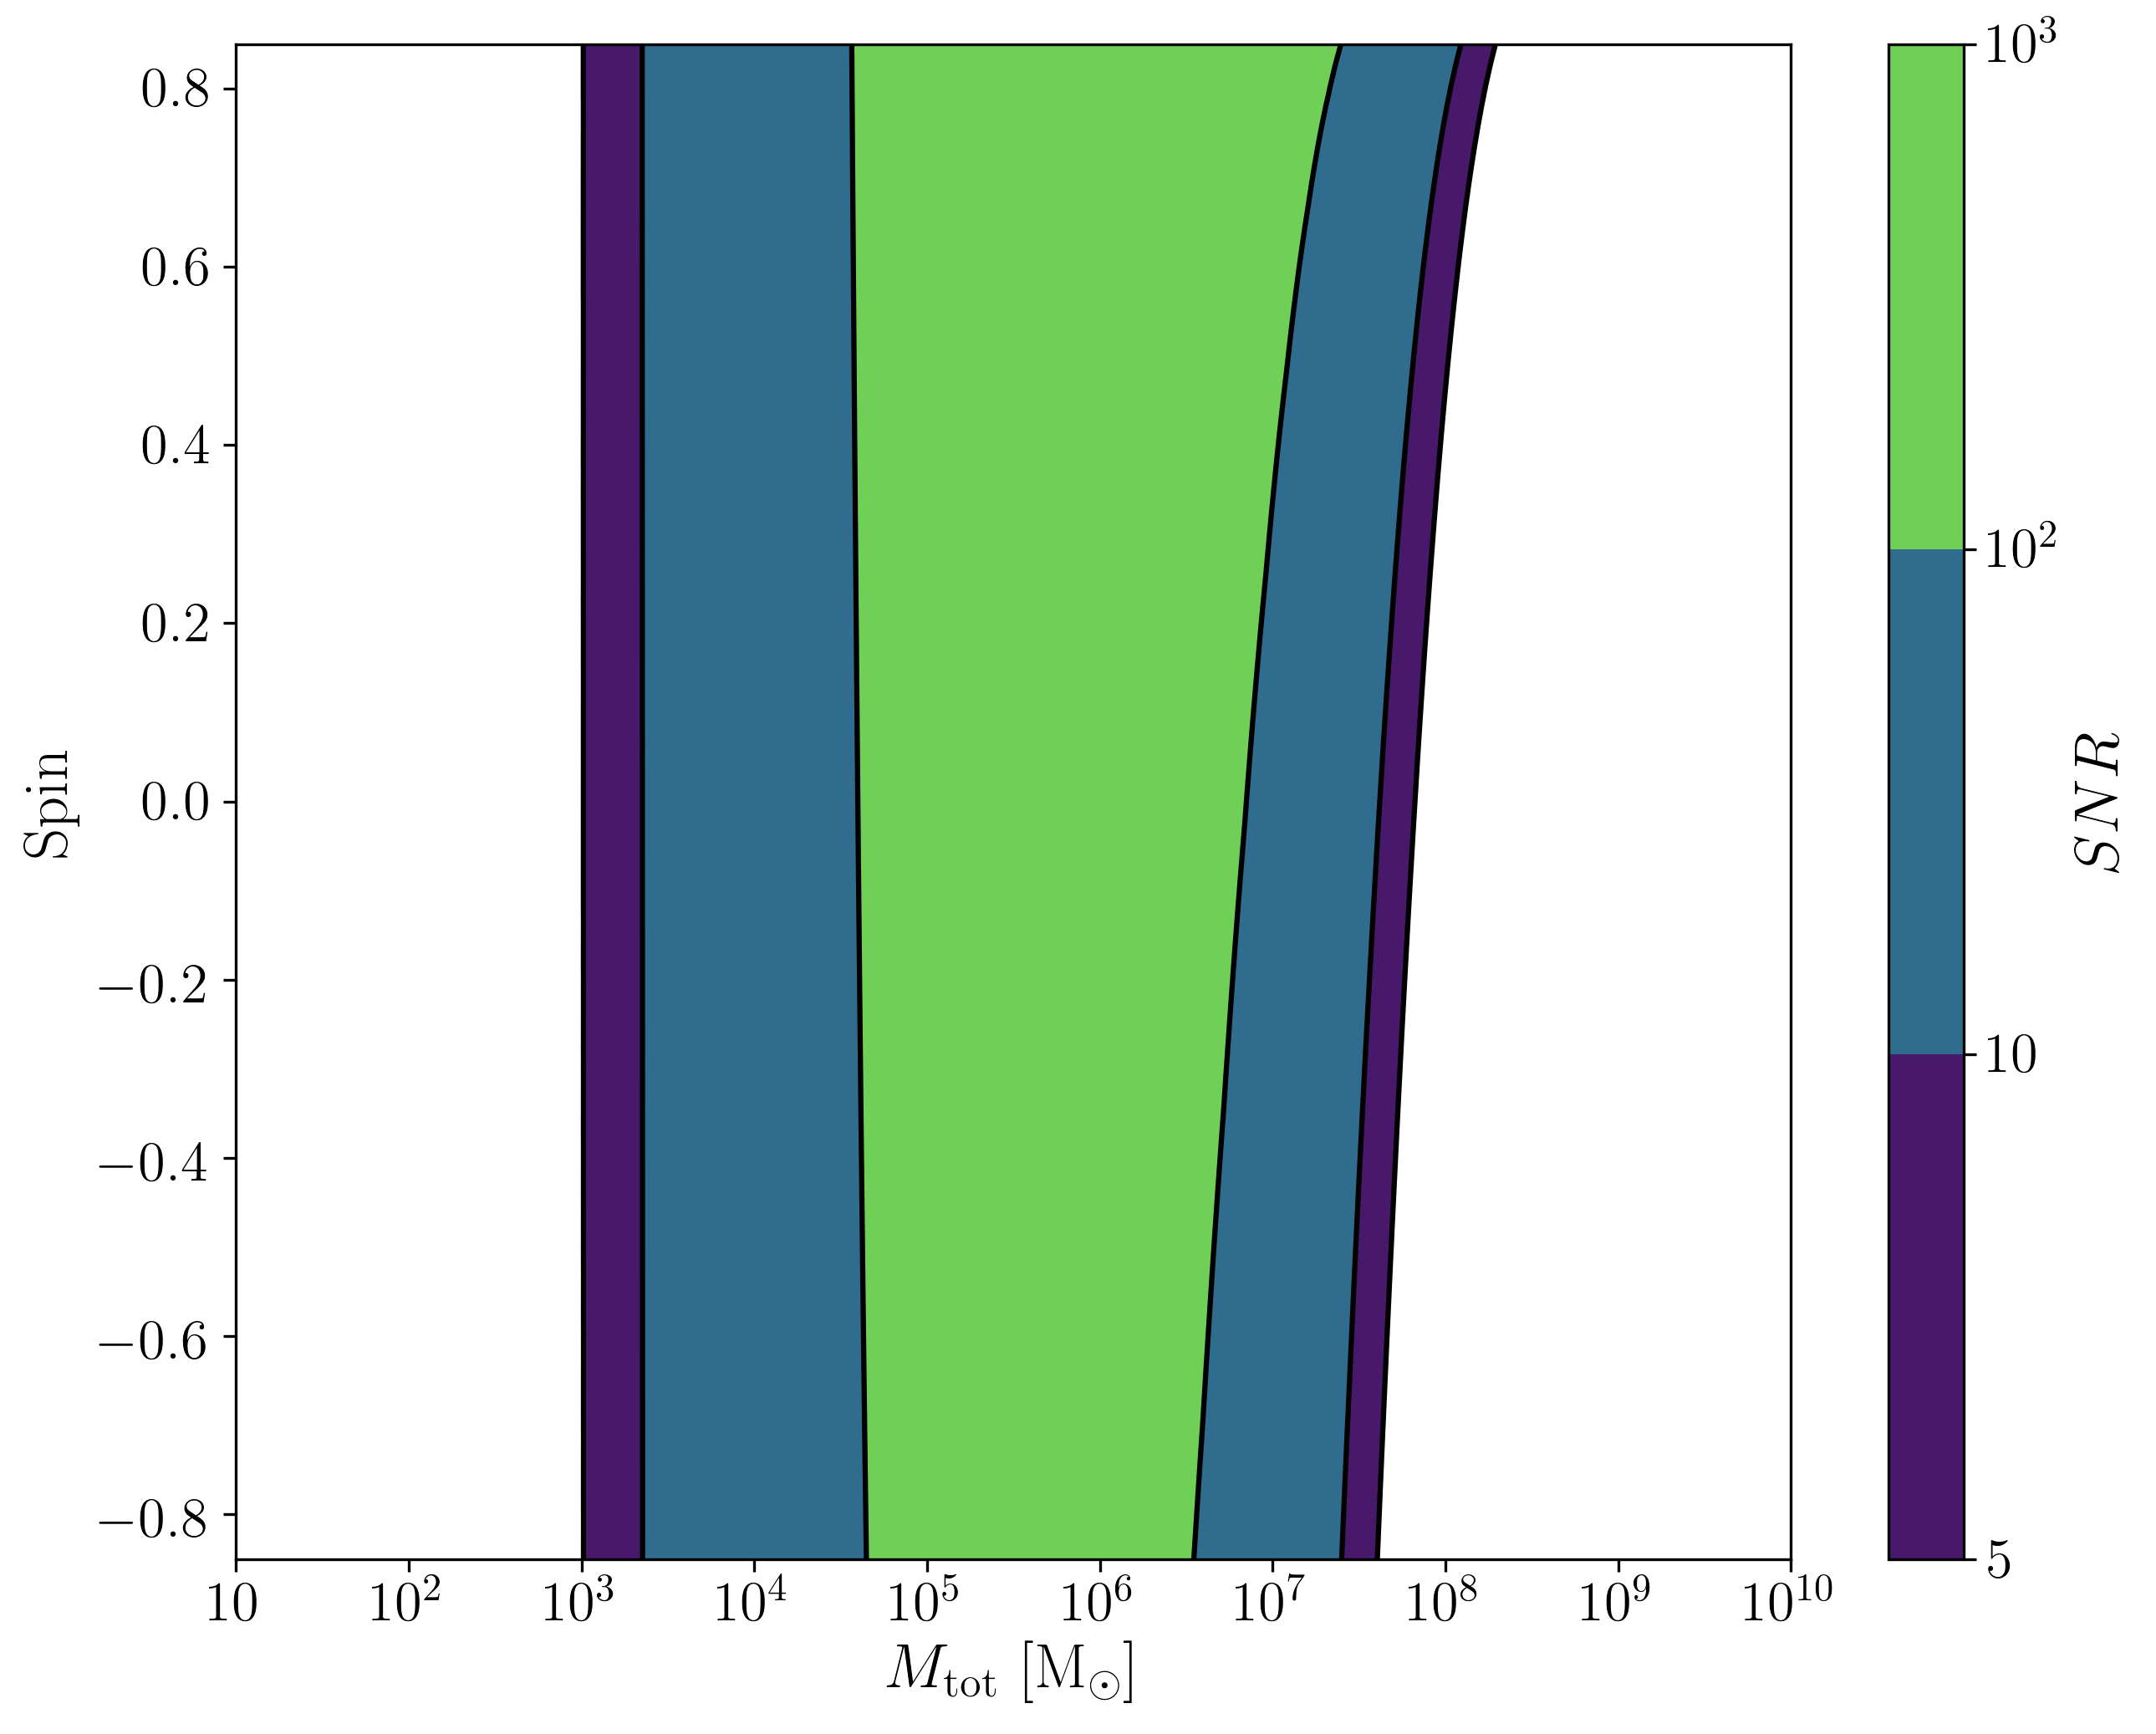

Model:  LISA_ESA ,  done. t = :  47.351938009262085


In [37]:
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    for var_y in var_ys:
        figloc = save_directory + 'SNR_' + instrument.name + '_' + var_y + '.png'
        start = time.time()
        [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                           var_x,sampleRate_x,
                                                           var_y,sampleRate_y)
        end = time.time()
        #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
        snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                         dl_axis=False,smooth_contours=False,figloc=figloc)
        print('Model: ',instrument.name,',',' done. t = : ',end-start)

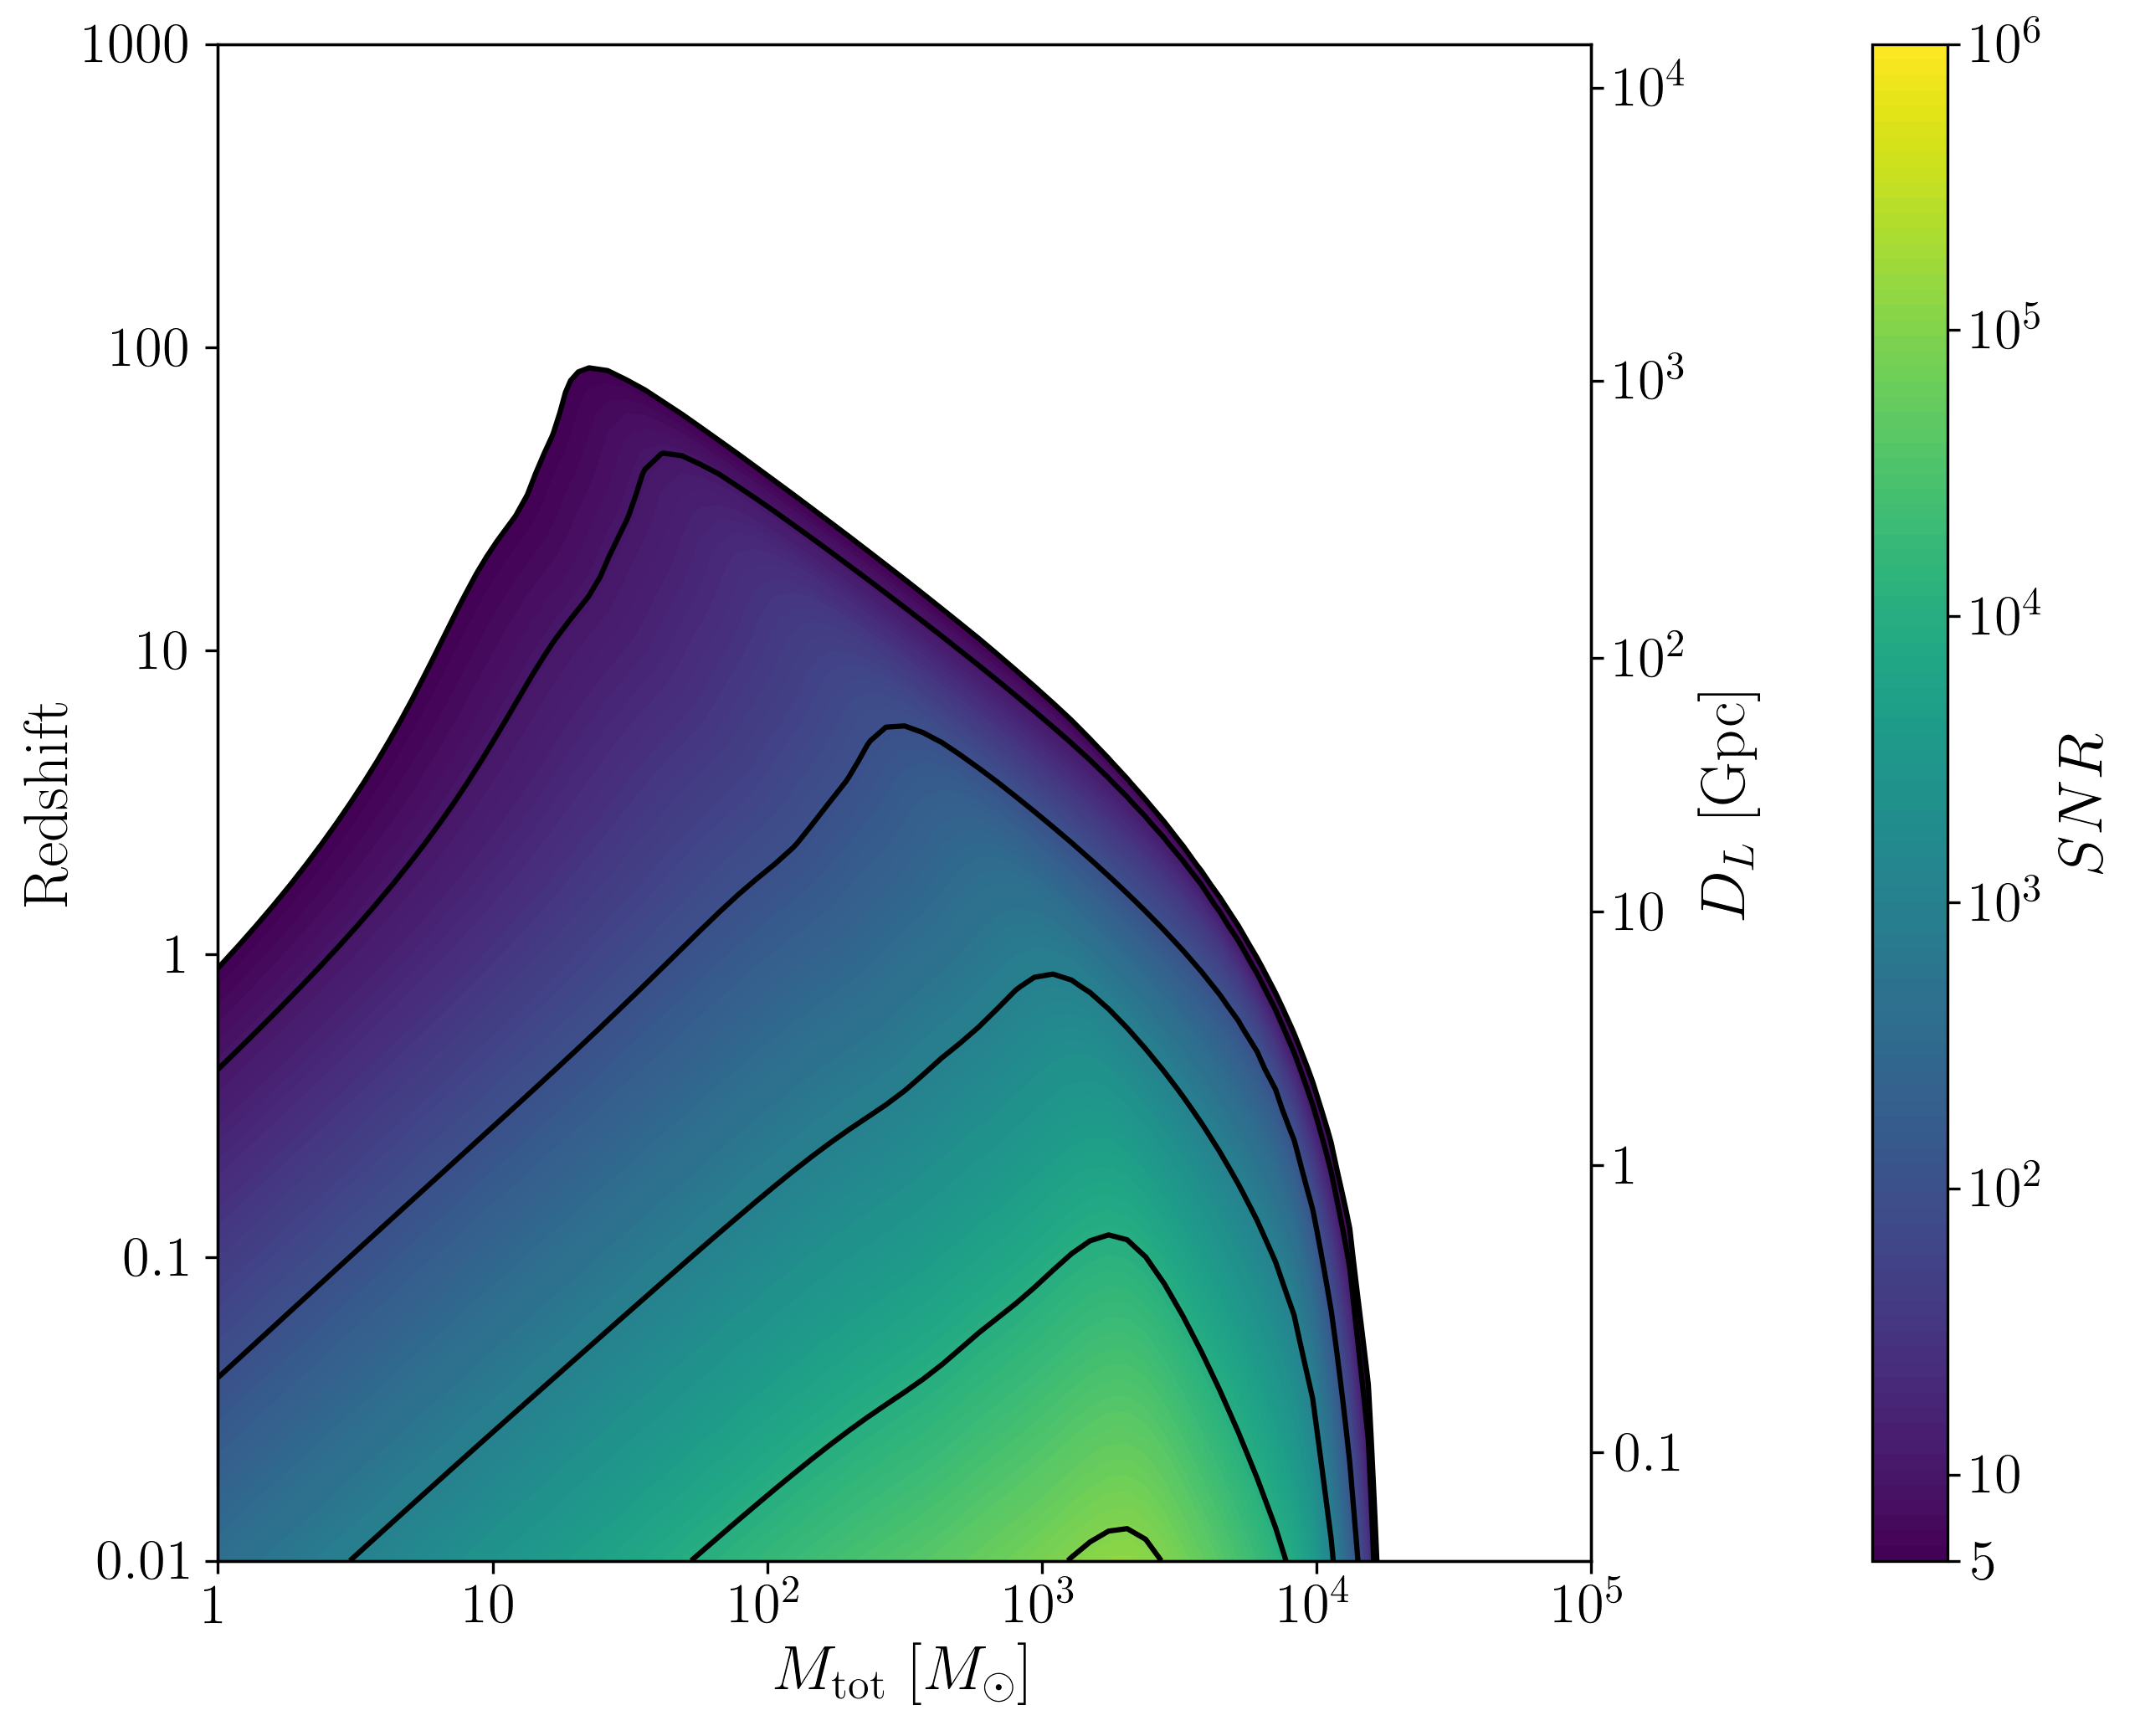

Model:  ET ,  done. t = :  33.874545097351074


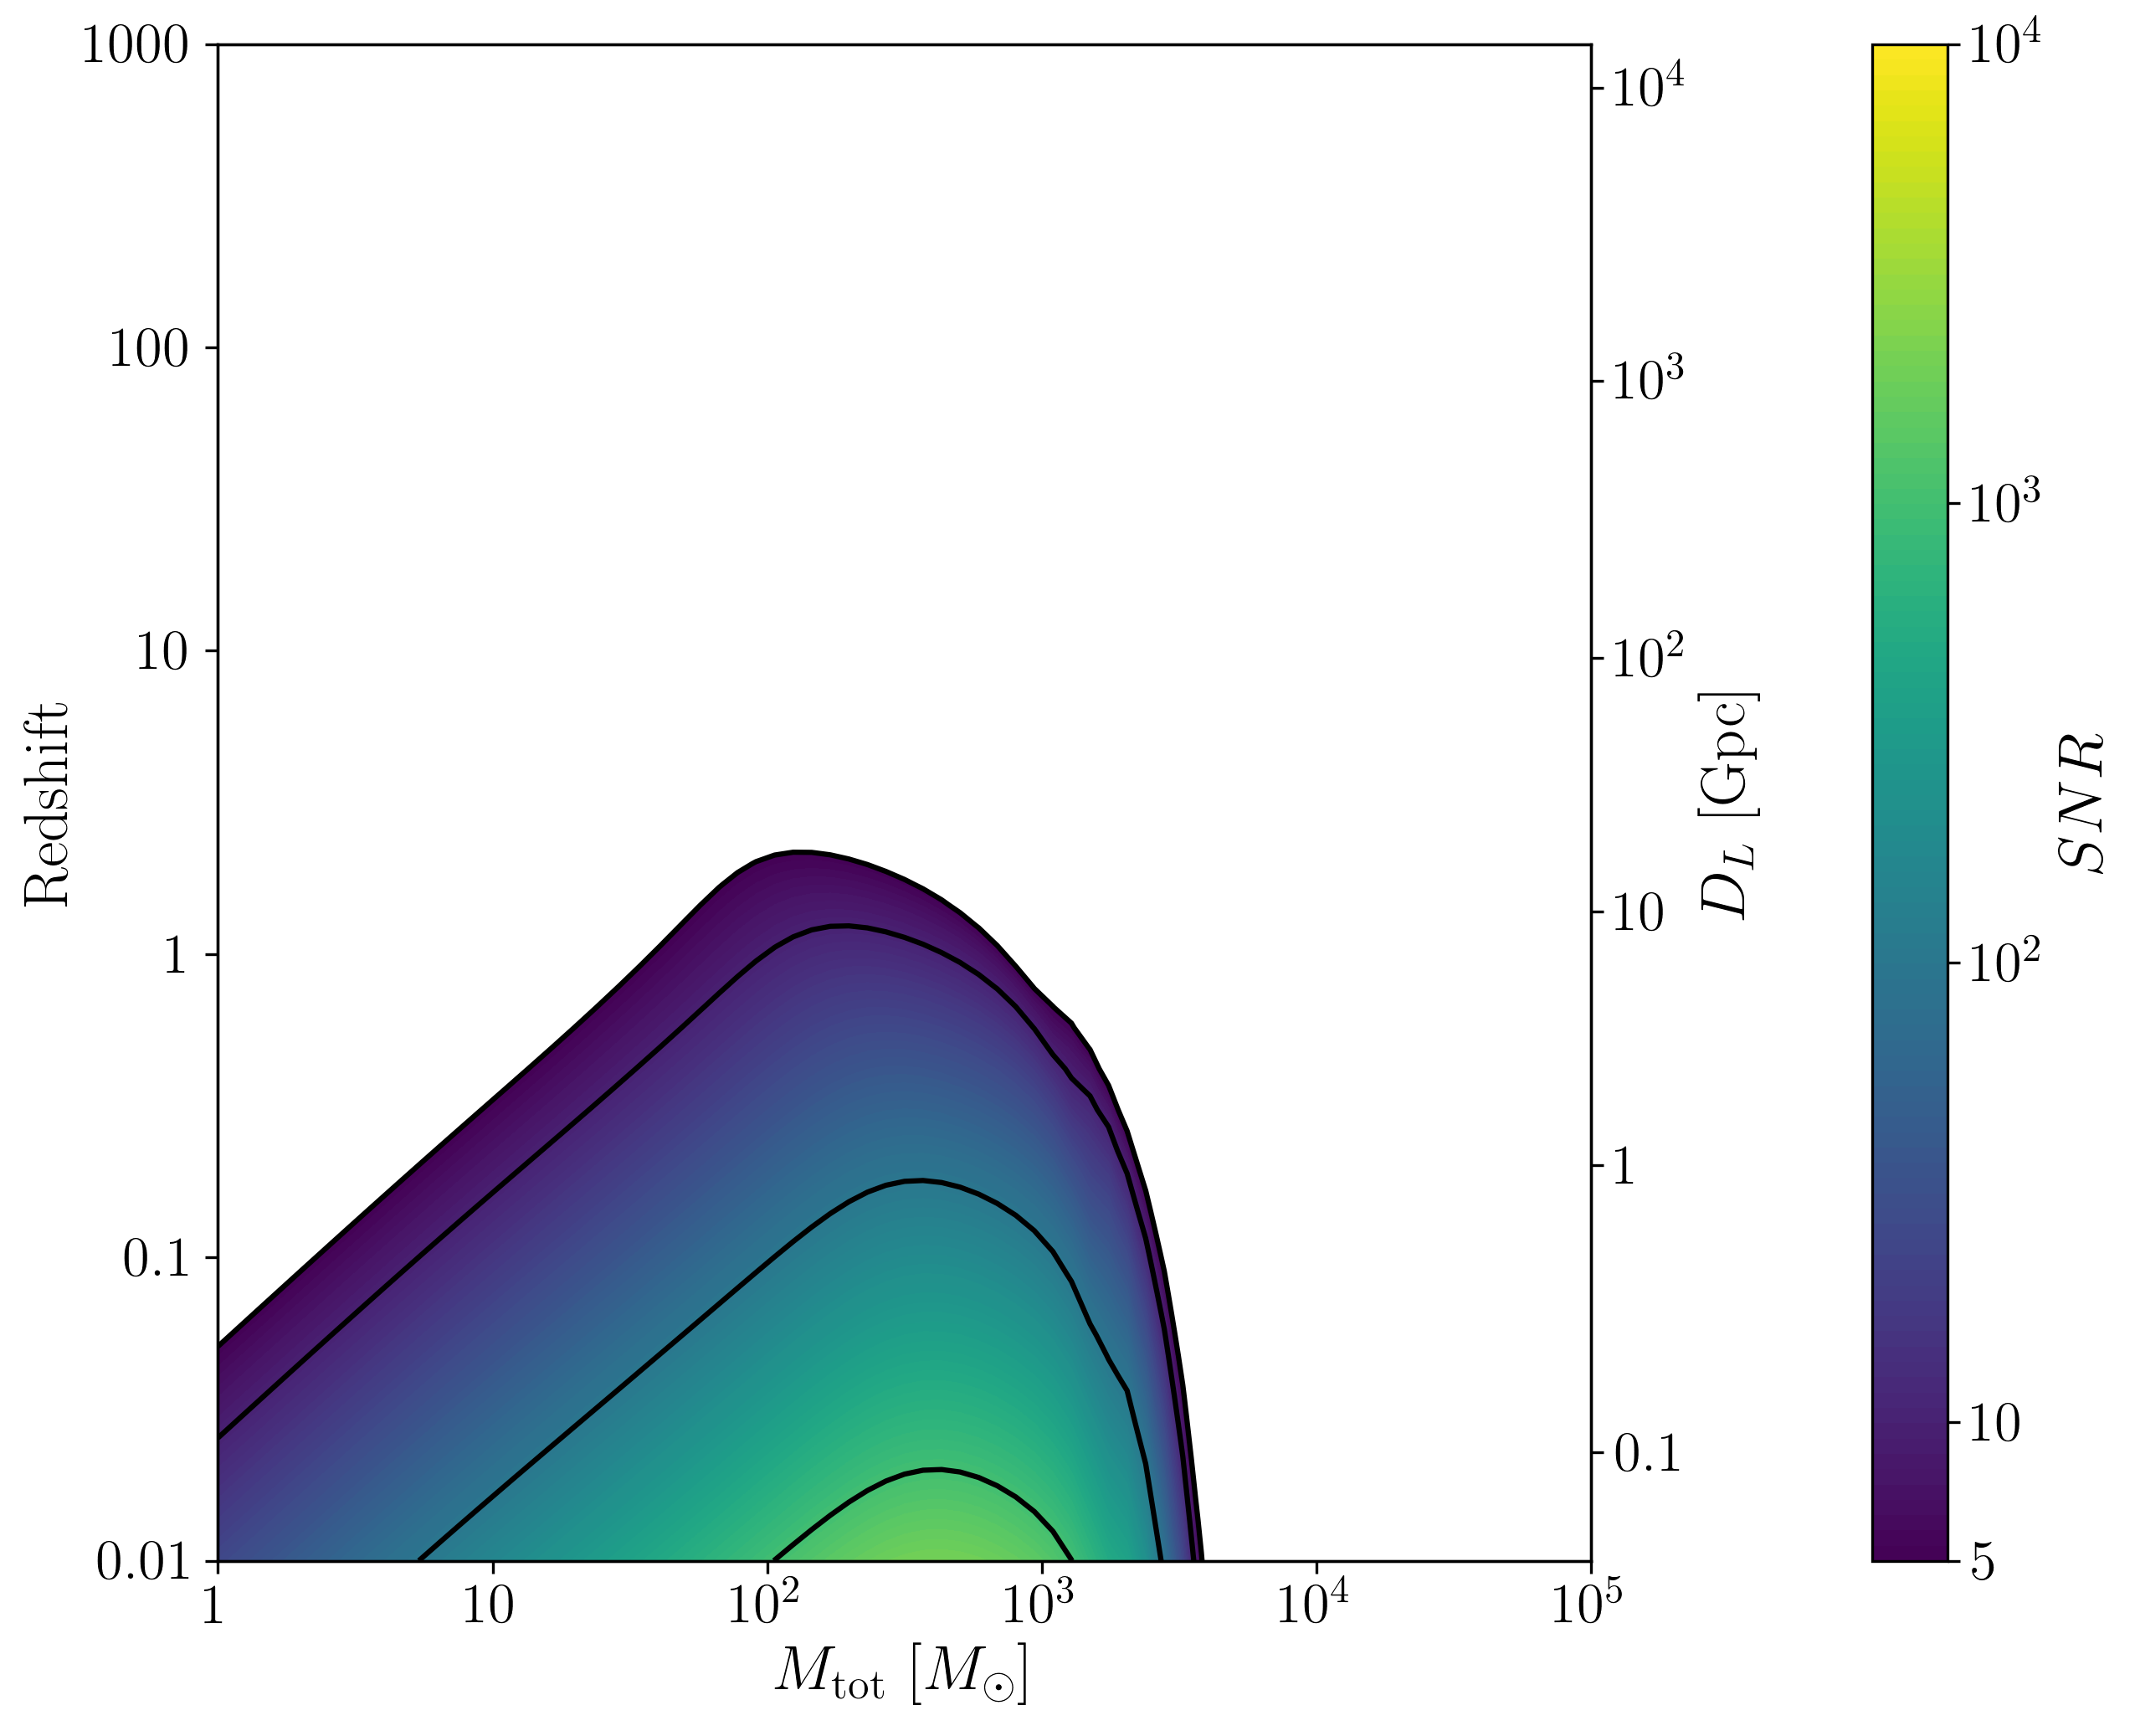

Model:  aLIGO ,  done. t = :  33.711605072021484


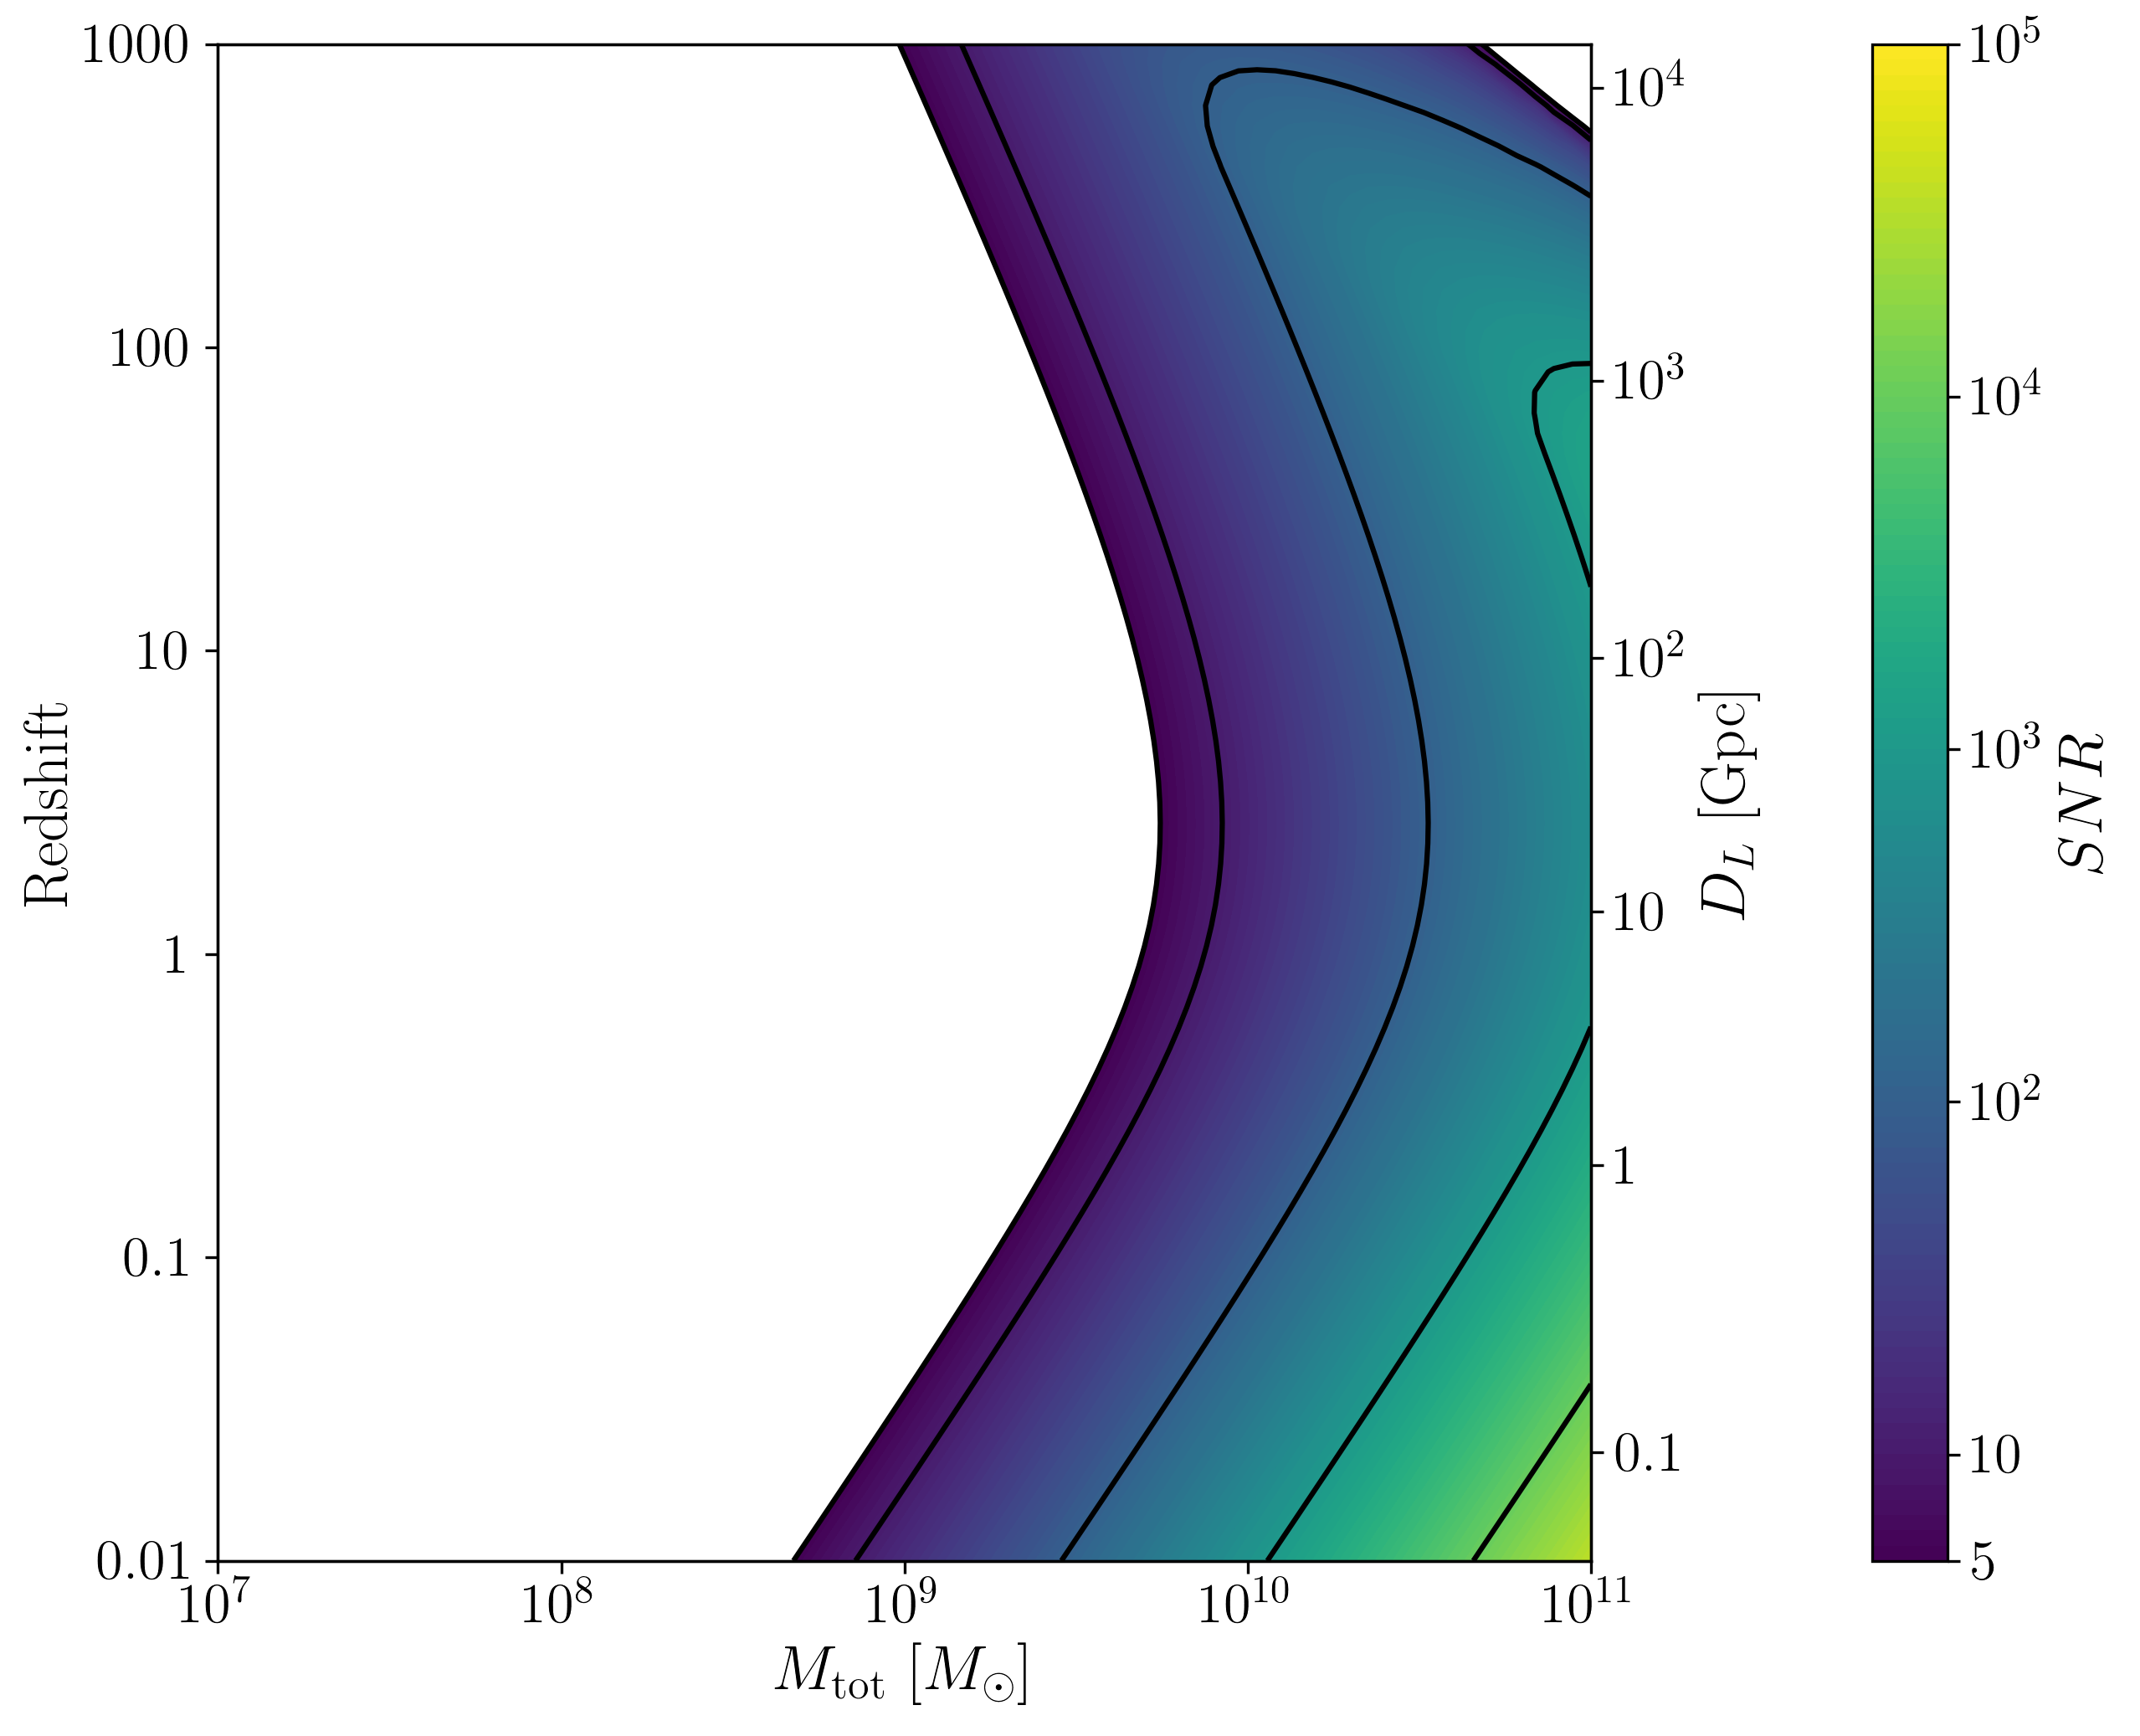

Model:  NANOGrav ,  done. t = :  26.11200213432312


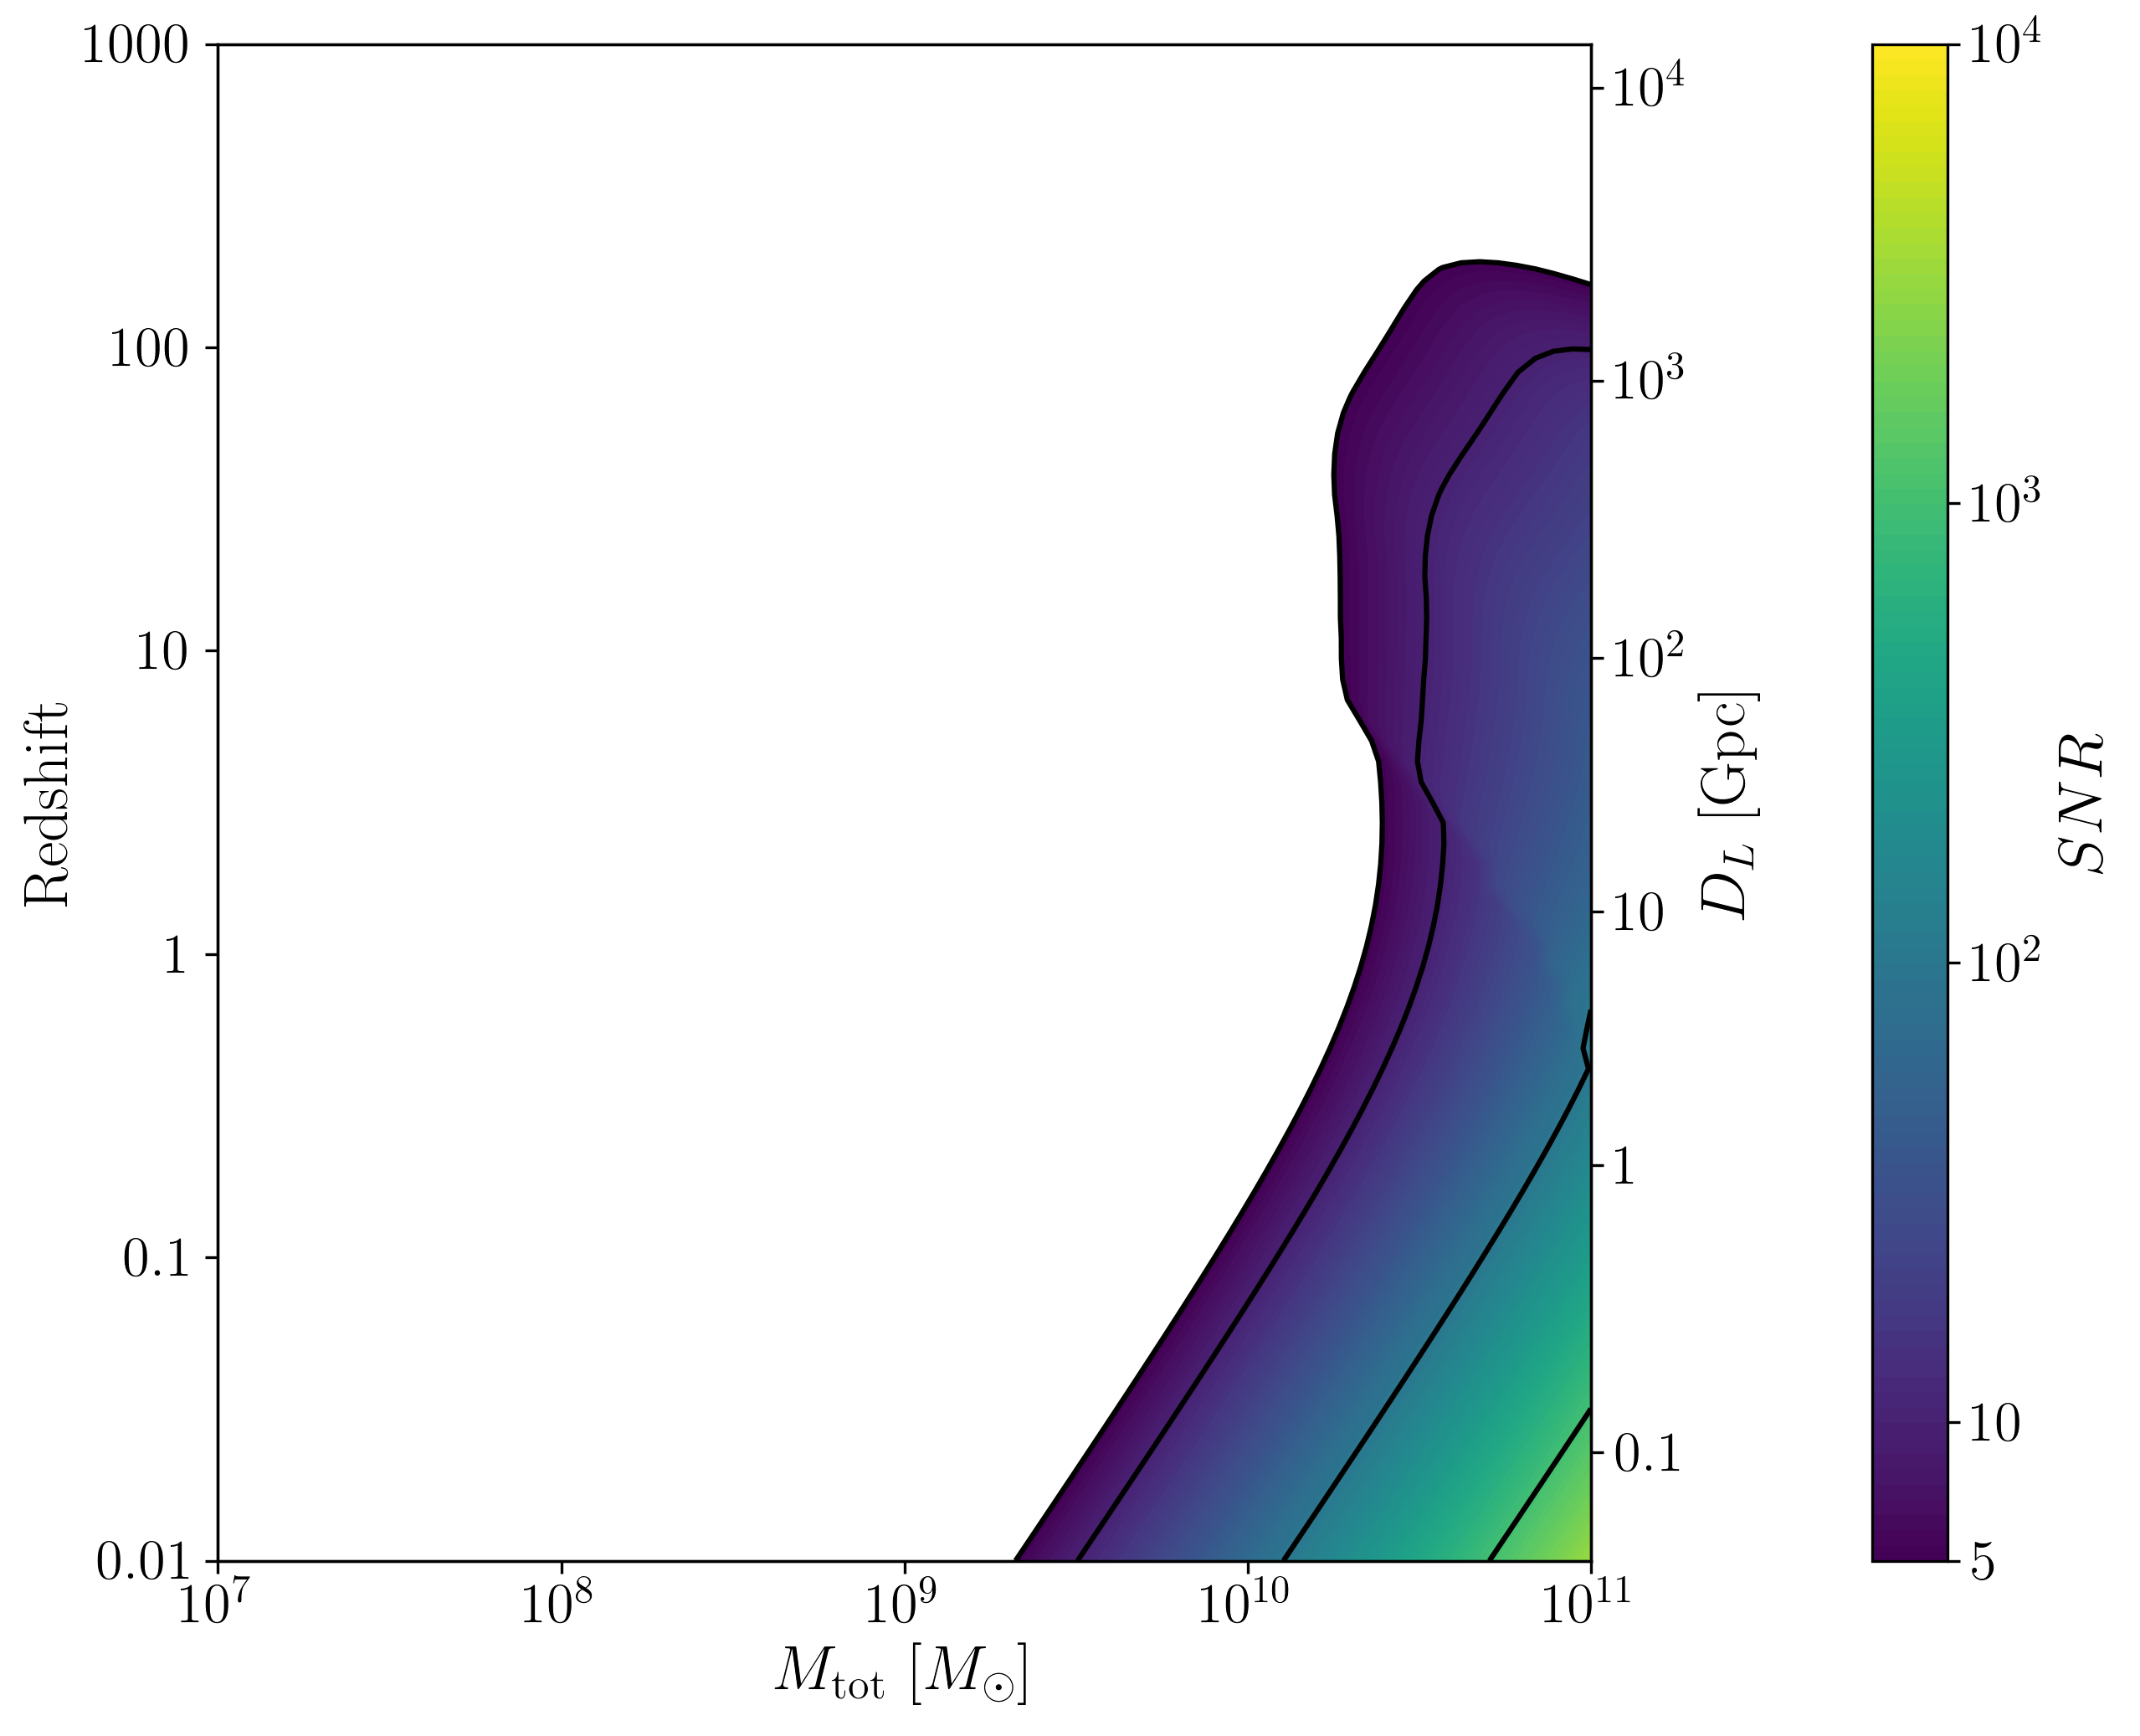

Model:  NANOGrav, WN and RN ,  done. t = :  28.75184416770935


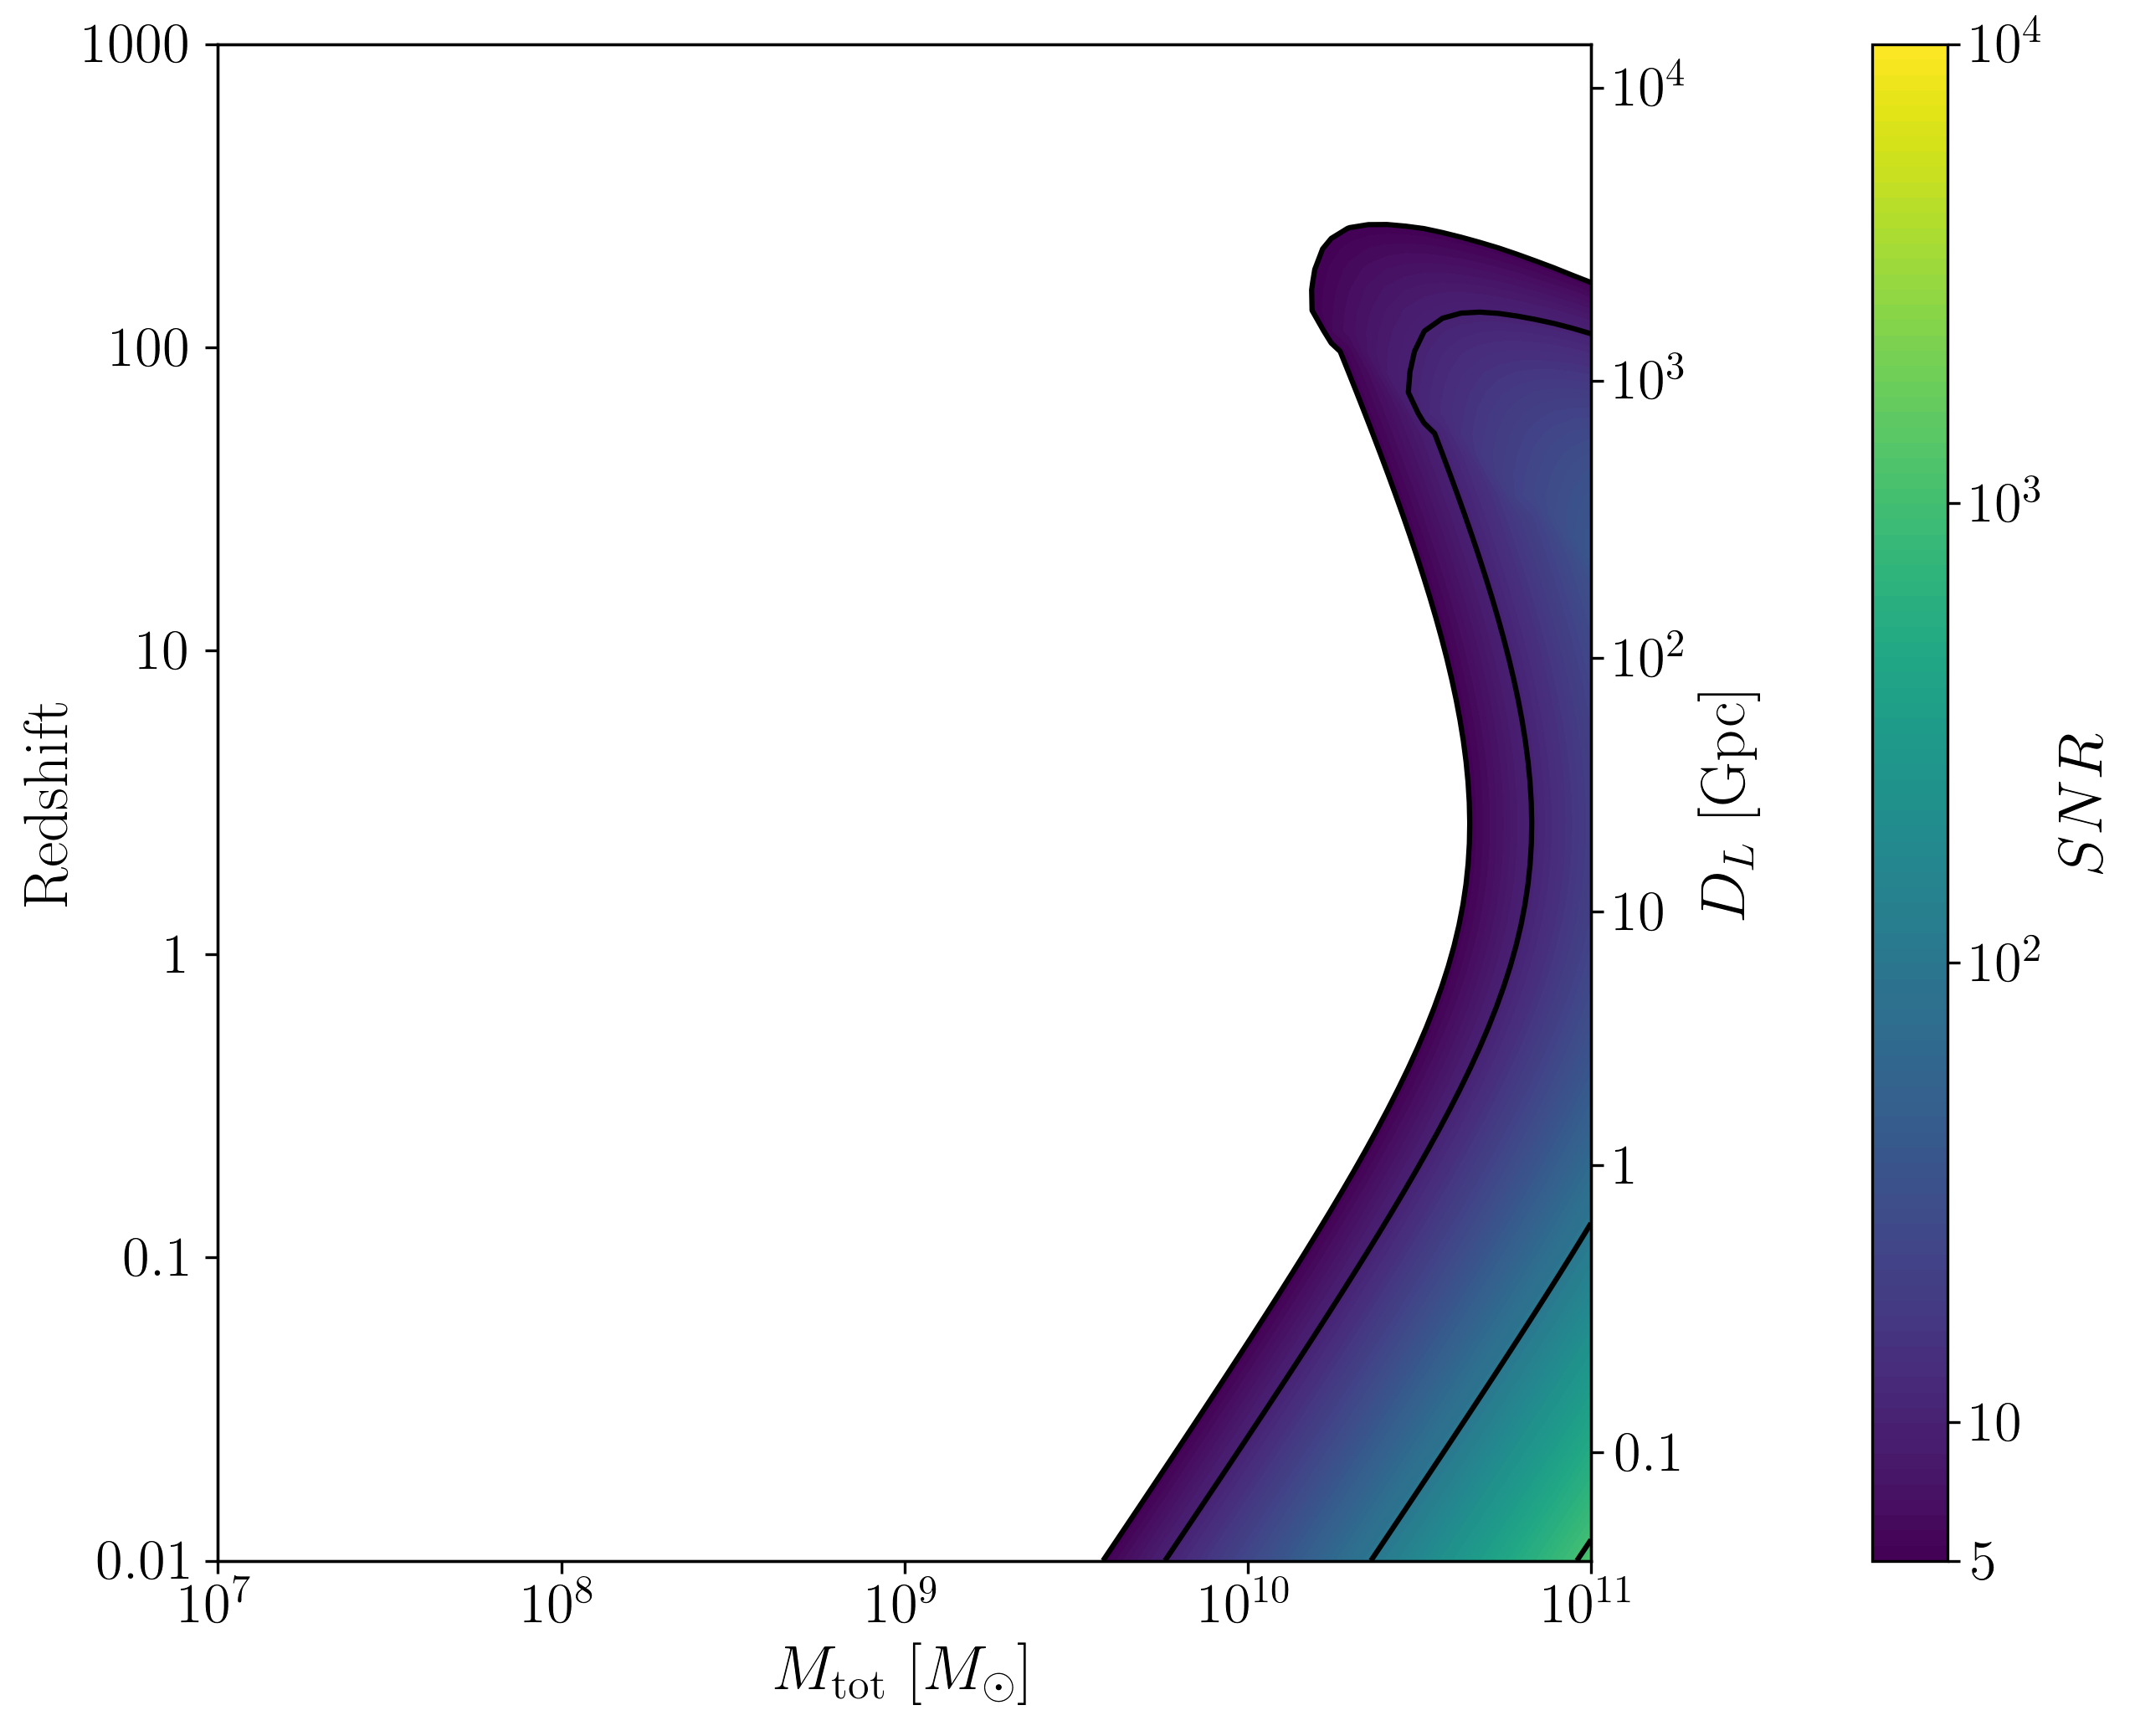

Model:  NANOGrav 11yr ,  done. t = :  25.26868510246277


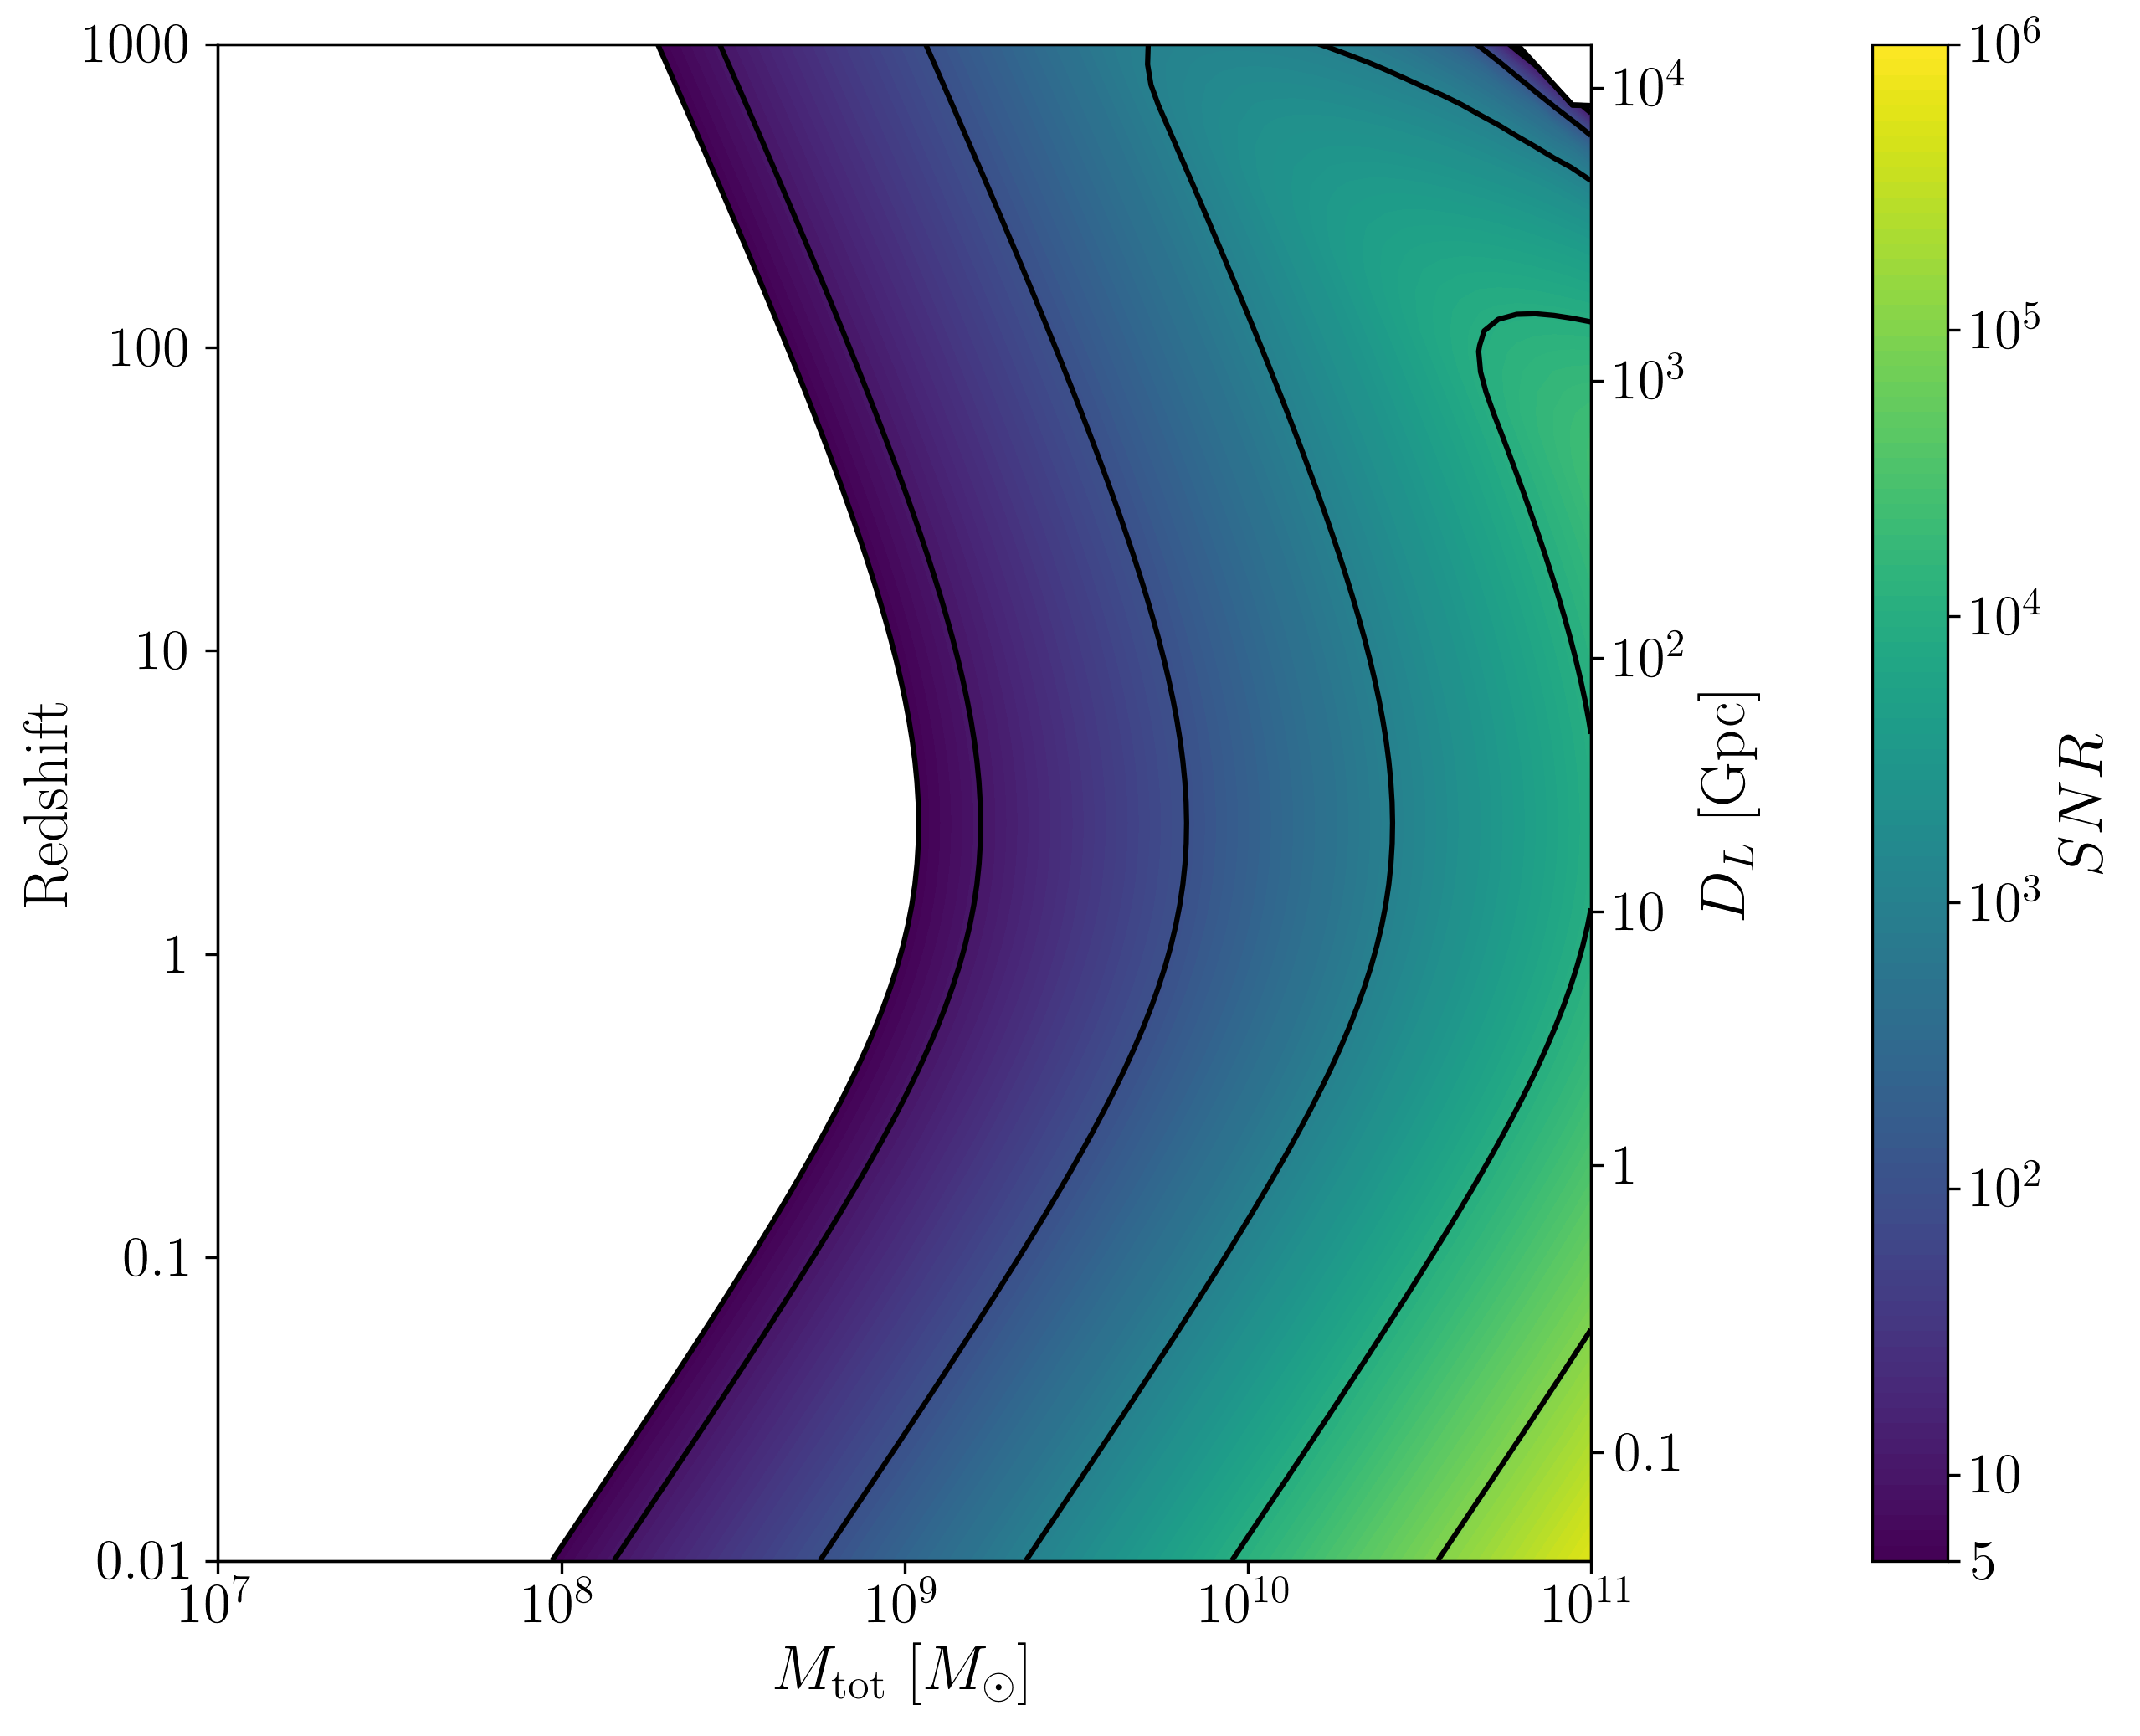

Model:  SKA ,  done. t = :  36.12715291976929


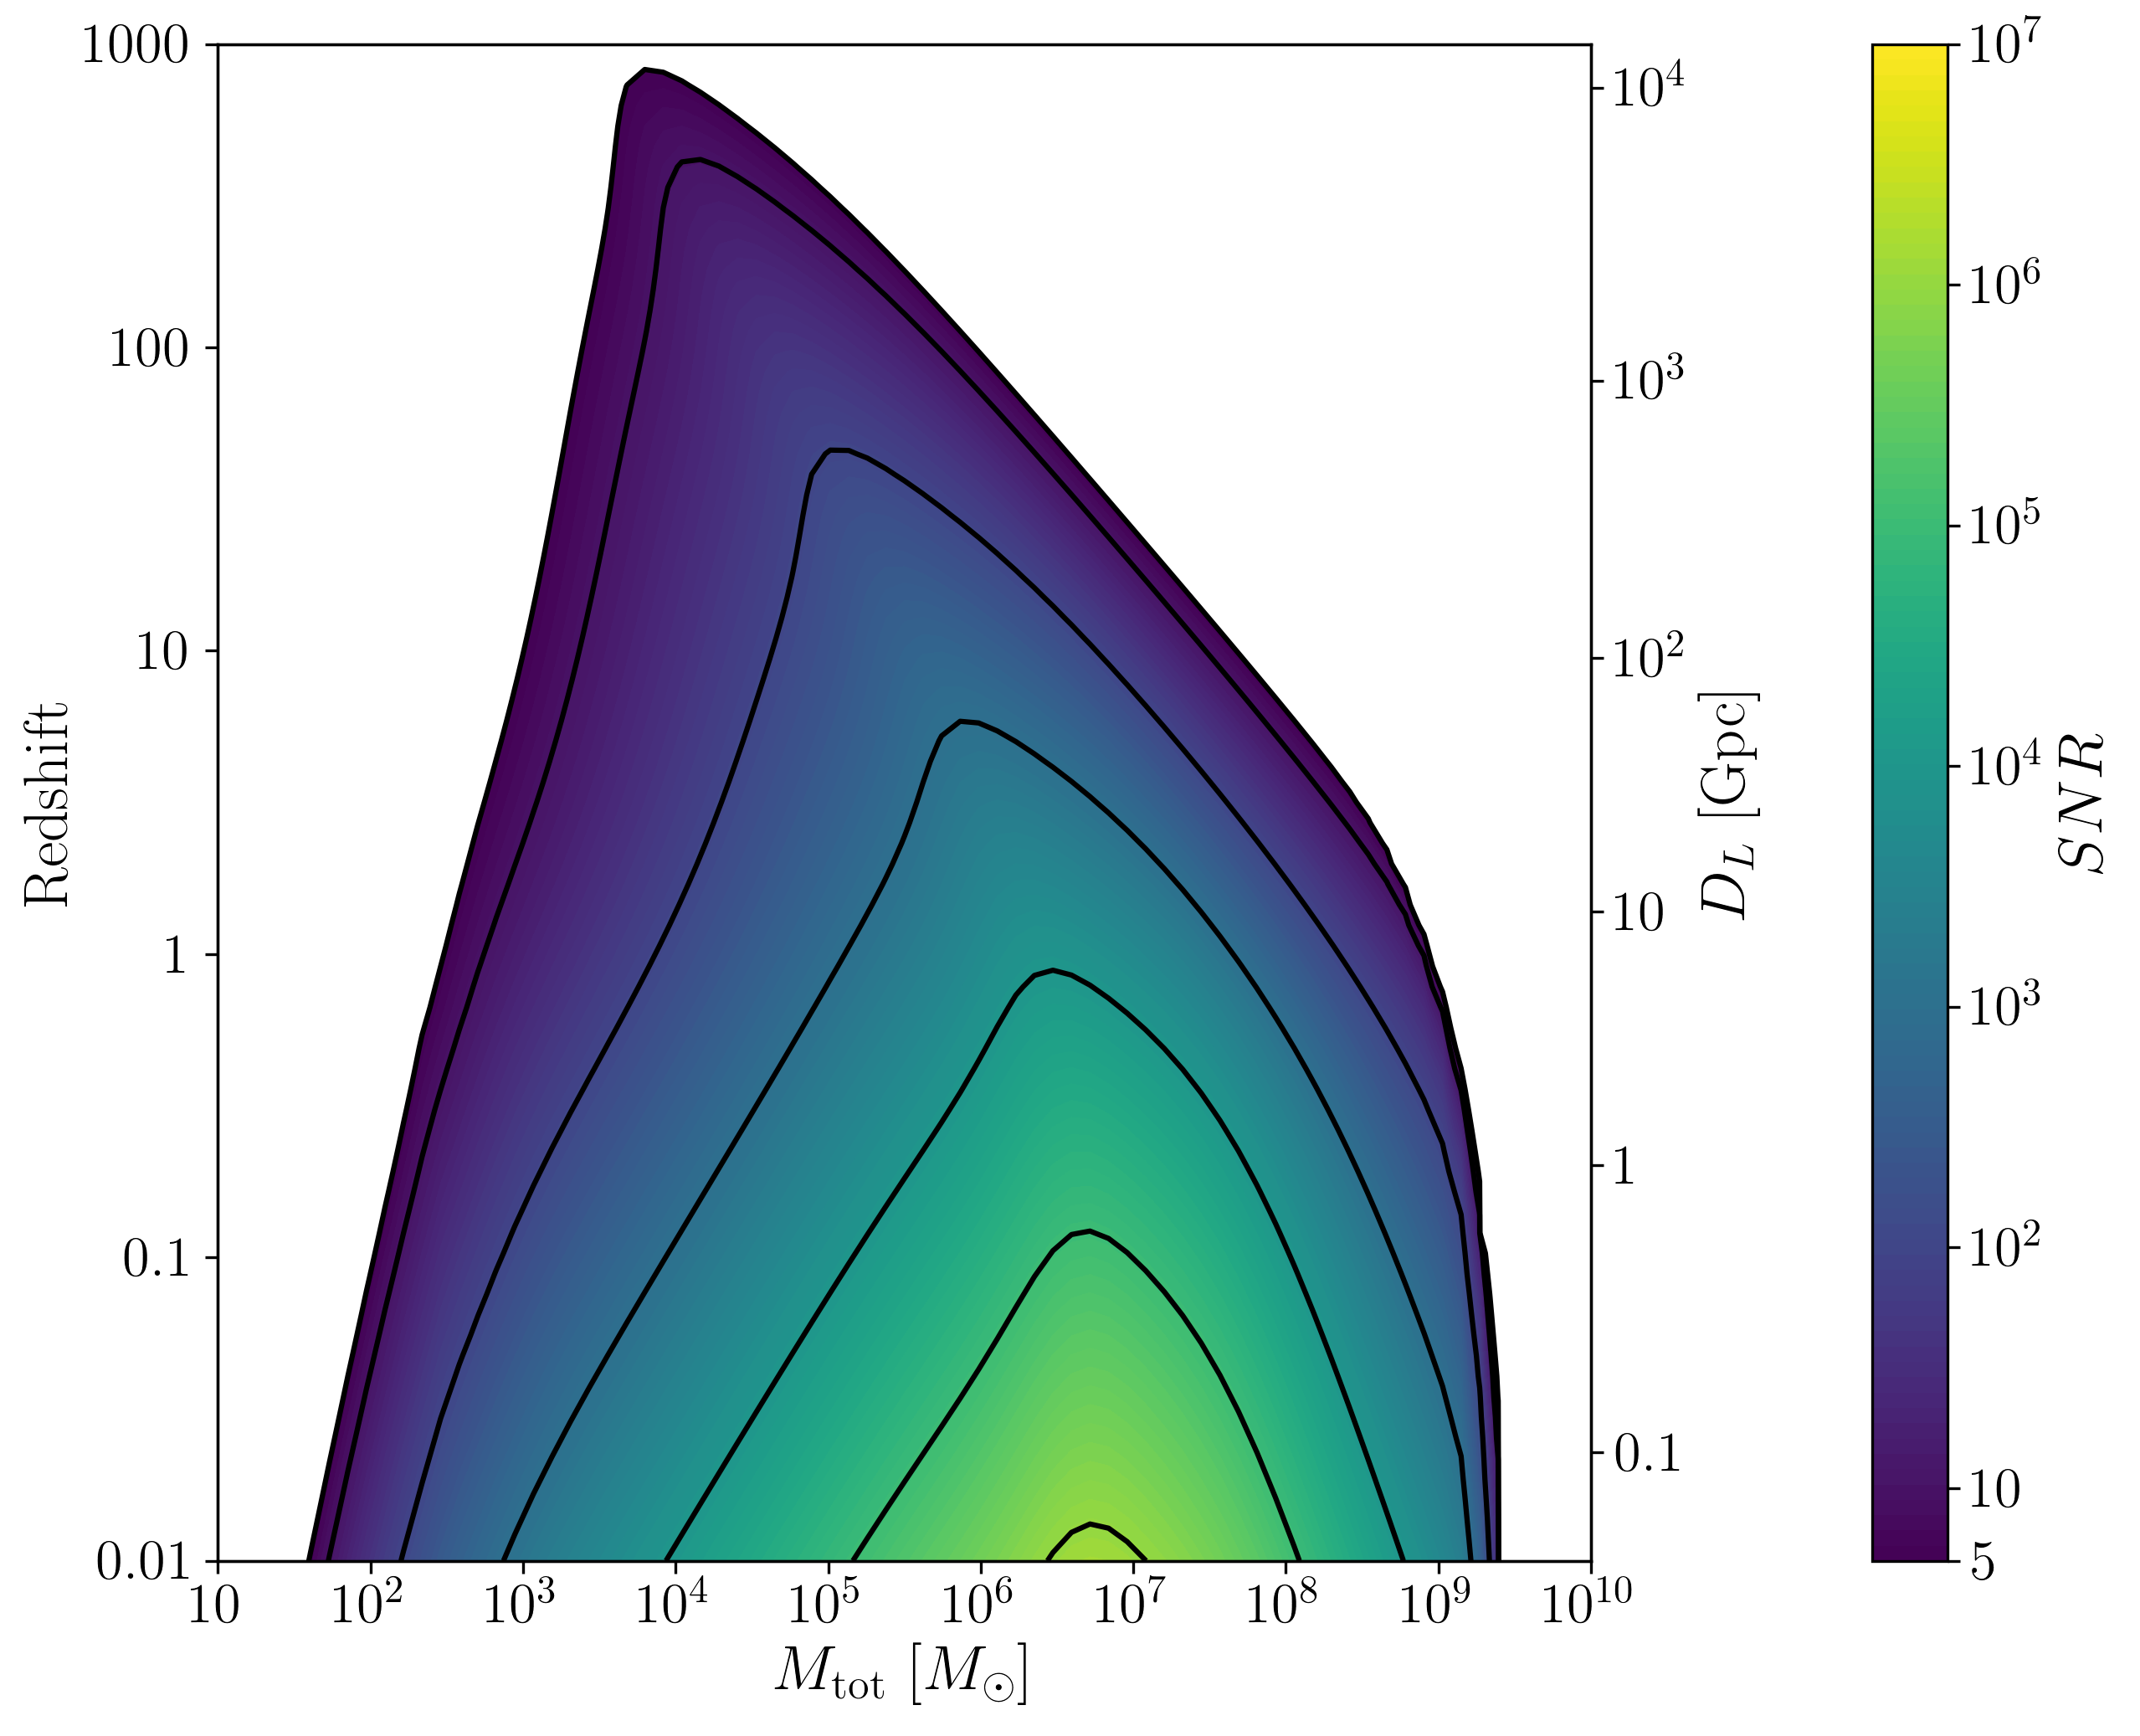

Model:  Alt_LISA ,  done. t = :  32.00723218917847


In [11]:
models = range(7)
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,\
                                             var_x,sampleRate_x,var_y,sampleRate_y)
    end = time.time()
    #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,dl_axis=True,smooth_contours=True)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)